
--- ADFuller Test Results (p-values) ---
Inflation: 0.0004
Sentiment: 0.0000
Claims: 0.0000

Best lag selected: 12

--- Forecasted Values ---
            Inflation  Sentiment         Claims
2024-01-01   3.545263  71.711616  266709.944113
2024-02-01   3.692825  70.553951  166019.996732
2024-03-01   4.229390  68.780083  100699.103050
2024-04-01   4.207468  68.064709  190771.217737
2024-05-01   4.392325  67.311558  189943.257927
2024-06-01   5.163790  67.309836  207827.839471
2024-07-01   5.527326  65.942391  169710.538439
2024-08-01   5.332471  65.512857  112039.912815
2024-09-01   5.132650  65.709978  148388.724199
2024-10-01   5.258153  64.611129  150727.471791
2024-11-01   5.458715  62.995268  153356.240889
2024-12-01   5.502330  63.884956  171384.111959


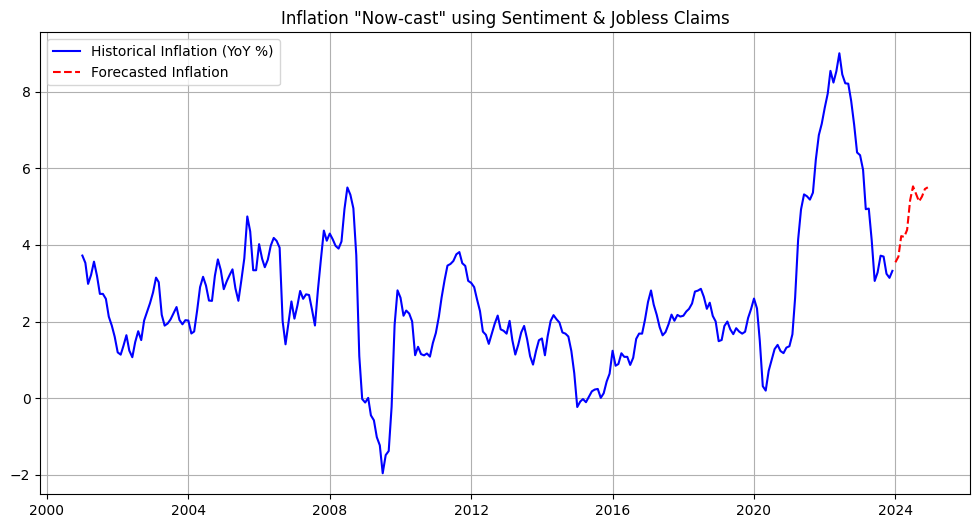

In [ ]:
#Us data

import pandas as pd
import pandas_datareader.data as web  # To get data from FRED
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

# --- 1. Get the Data ---
# We will get 3 data series from the FRED database
# 1. CPIAUCSL: Consumer Price Index (This is our "Inflation" target)
# 2. UMCSENT: U. of Michigan Consumer Sentiment (Our "Sentiment Analysis" predictor)
# 3. ICSA:     Weekly Initial Jobless Claims (Our "High-Frequency" predictor)

start = pd.to_datetime('2000-01-01')
end = pd.to_datetime('2024-01-01')

# Fetch the data
cpi = web.DataReader('CPIAUCSL', 'fred', start, end)
sentiment = web.DataReader('UMCSENT', 'fred', start, end)
claims = web.DataReader('ICSA', 'fred', start, end)

# --- 2. Prepare the Data ---
# All data must be on the same timeline (monthly) and be "stationary"

# a. Resample weekly 'claims' to monthly (use the mean)
claims_monthly = claims.resample('MS').mean()

# b. Calculate Year-over-Year (YoY) Inflation from CPI
#    This is the number you see in the news (e.g., "Inflation is 3.5%")
inflation_yoy = cpi.pct_change(12) * 100
inflation_yoy.rename(columns={'CPIAUCSL': 'Inflation_YoY'}, inplace=True)

# c. Combine into one DataFrame
df = pd.concat([inflation_yoy, sentiment, claims_monthly], axis=1)
df.columns = ['Inflation', 'Sentiment', 'Claims']

# d. Drop any missing rows (at the start)
df = df.dropna()

# e. Make data "stationary" (a requirement for VAR)
#    Stationary means the mean/variance don't change over time.
#    We use .diff() to get the month-over-month *change* instead of the *level*.
#    This is the most complex step, but it's crucial.
df_diff = df.diff().dropna()

# Check if data is stationary (ADFuller test)
print("\n--- ADFuller Test Results (p-values) ---")
for name in df_diff.columns:
    result = adfuller(df_diff[name])
    print(f'{name}: {result[1]:.4f}') # We want p-value < 0.05

# --- 3. Build and Train the VAR Model ---

# Create the VAR model
model = VAR(df_diff)

# Select the best "lag" (how many past months to look at)
# This can take a moment. 12 is a good max for monthly data.
best_lag = model.select_order(maxlags=12).aic
print(f"\nBest lag selected: {best_lag}")

# Fit the model using the best lag
results = model.fit(best_lag)

# You can print a summary of the relationships it found
# print(results.summary())

# --- 4. Make a "Now-cast" / Forecast ---

# How many steps do we want to forecast? Let's predict the next 12 months.
forecast_steps = 12
lag_order = results.k_ar

# Get the last 'lag_order' values to feed into the forecast
forecast_input = df_diff.values[-lag_order:]

# Get the forecast (this returns the *differenced* forecast)
forecast_diff = results.forecast(y=forecast_input, steps=forecast_steps)

# Convert the forecast back into the original scale (undo the .diff())
# This is a bit tricky, but it's the right way to do it
def invert_transformation(df, forecast_diff_df, last_orig_row):
    forecast = forecast_diff_df.copy()
    # Add the last original value back to the first forecasted change
    forecast.iloc[0] = last_orig_row.values + forecast.iloc[0].values
    # Cumulatively sum the rest
    forecast = forecast.cumsum()
    return forecast

# Create a DataFrame for the forecast
forecast_df = pd.DataFrame(forecast_diff, index=pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='MS'), columns=df.columns)

# Get the last "real" row from our *original* data
last_real_row = df.iloc[-1]

# "Invert" the forecast to get real values back
forecast_real = invert_transformation(df, forecast_df, last_real_row)

print("\n--- Forecasted Values ---")
print(forecast_real)

# --- 5. Plot the Results (The "Money Shot"!) ---
plt.figure(figsize=(12, 6))
# Plot historical inflation
plt.plot(df['Inflation'], label='Historical Inflation (YoY %)', color='blue')
# Plot our model's forecast
plt.plot(forecast_real['Inflation'], label='Forecasted Inflation', color='red', linestyle='--')

plt.title('Inflation "Now-cast" using Sentiment & Jobless Claims')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#webscrape this and ask cs gut to do this if possible this is for thie uk and below

import numpy as np

# --- 1b. SIMULATE YOUR CUSTOM "TESCO PRICE INDEX" ---
#
# IN YOUR REAL HACKATHON, YOU WILL DELETE THIS BLOCK
# AND INSTEAD LOAD YOUR OWN DATA, E.G.:
# my_price_index = pd.read_csv('my_tesco_data.csv', index_col='date', parse_dates=True)
#
# Make sure your CSV has a 'date' column and a 'price_index' column.
#
print("Simulating custom 'Tesco Price Index'...")
# Get the date range from the official data we're about to download
date_rng = pd.date_range(start='2000-01-01', end='2024-01-01', freq='MS')
# Create some fake random walk data
price_changes = np.random.normal(0.05, 0.5, size=len(date_rng))
fake_price_data = 100 + np.cumsum(price_changes)
# Create the DataFrame
my_price_index = pd.DataFrame(fake_price_data, index=date_rng, columns=['Tesco_Index'])
# --- END OF SIMULATION BLOCK ---

Simulating custom 'Tesco Price Index'...


Fetching UK economic data from FRED...
Simulating custom 'Tesco Price Index'...

--- Combined Data Head ---
            Inflation  Sentiment  Claims  Tesco_Index
2001-01-01   0.000000   102.8093  143800    99.139382
2001-02-01   0.000000   102.8318  143701    99.119785
2001-03-01   0.300000   102.8461  143924    99.883945
2001-04-01   0.666667   102.7907  143569   100.382230
2001-05-01   0.900000   102.7974  143318   100.673054

--- ADFuller Test Results (p-values) ---
Inflation: 0.0000
Sentiment: 0.0000
Claims: 0.0000
Tesco_Index: 0.0000

Selecting optimal model lag...
Best lag selected: 3
Generating forecast...

--- Forecasted Values ---
            Inflation  Tesco_Index
2024-02-01  -0.531041   114.653830
2024-03-01  -0.501762   114.837277
2024-04-01  -0.252700   114.848791
2024-05-01  -0.226370   114.944510
2024-06-01  -0.221663   115.082507
2024-07-01  -0.089506   115.169253
2024-08-01  -0.059666   115.241587
2024-09-01  -0.070303   115.327652
2024-10-01  -0.023906   115.400796
20

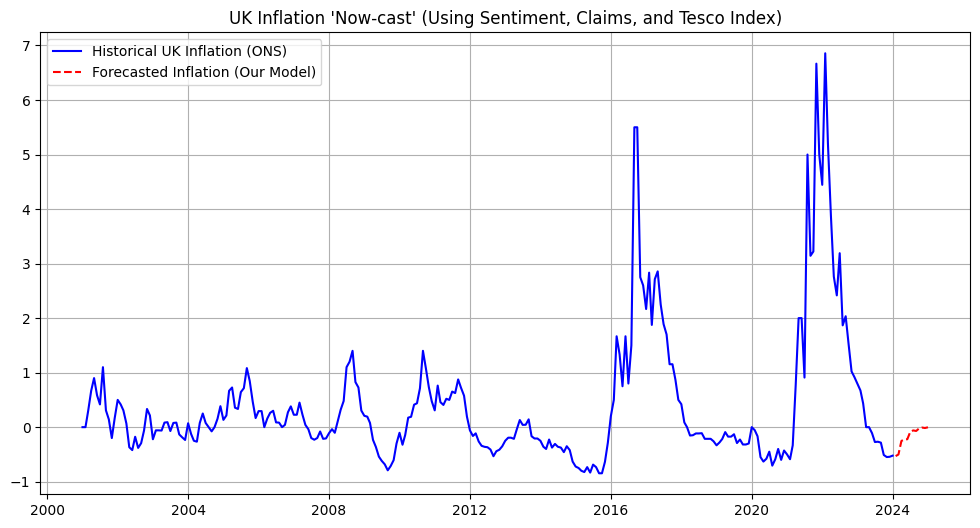

In [ ]:
For the uk

import pandas as pd
import pandas_datareader.data as web  # To get data from FRED
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
import numpy as np  # Added for simulation

# --- 1. Get the Data ---
# We are now using UK-specific FRED codes
# 1. CPALTT01GBM659N: UK Consumer Price Index (Our "Inflation" target)
# 2. CSCICP03GBM665S: UK Consumer Confidence (Our "Sentiment" predictor)
# 3. CLF16OV:         UK Claimant Count (Our "Job Market" predictor)

start = pd.to_datetime('2000-01-01')
# Let's use a more recent end date
end = pd.to_datetime('2025-10-01')

print("Fetching UK economic data from FRED...")
cpi = web.DataReader('CPALTT01GBM659N', 'fred', start, end)
sentiment = web.DataReader('CSCICP03GBM665S', 'fred', start, end)
claims = web.DataReader('CLF16OV', 'fred', start, end)

# --- 1b. SIMULATE YOUR CUSTOM "TESCO PRICE INDEX" ---
#
# IN YOUR REAL HACKATHON, YOU WILL DELETE THIS BLOCK
# AND INSTEAD LOAD YOUR OWN DATA, E.G.:
# my_price_index = pd.read_csv('my_tesco_data.csv', index_col='date', parse_dates=True)
#
print("Simulating custom 'Tesco Price Index'...")
# Get the date range from the CPI data to align them
date_rng = pd.date_range(start=cpi.index.min(), end=cpi.index.max(), freq='MS')
# Create some fake random walk data
price_changes = np.random.normal(0.05, 0.5, size=len(date_rng))
fake_price_data = 100 + np.cumsum(price_changes)
# Create the DataFrame
my_price_index = pd.DataFrame(fake_price_data, index=date_rng, columns=['Tesco_Index'])
# --- END OF SIMULATION BLOCK ---


# --- 2. Prepare the Data ---
# All data must be on the same timeline (monthly) and be "stationary"

# a. Calculate Year-over-Year (YoY) Inflation from CPI
#    This is the number you see in the news
inflation_yoy = cpi.pct_change(12)
inflation_yoy.rename(columns={'CPALTT01GBM659N': 'UK_Inflation_YoY'}, inplace=True)

# b. Combine all DataFrames into one
#    We are adding your new 'my_price_index' here!
df = pd.concat([inflation_yoy, sentiment, claims, my_price_index], axis=1)
df.columns = ['Inflation', 'Sentiment', 'Claims', 'Tesco_Index'] # Added Tesco_Index

# c. Drop any missing rows (at the start)
df = df.dropna()

print("\n--- Combined Data Head ---")
print(df.head())

# d. Make data "stationary" (a requirement for VAR)
#    We use .diff() to get the month-over-month *change*.
df_diff = df.diff().dropna()

# Check if data is stationary (ADFuller test)
print("\n--- ADFuller Test Results (p-values) ---")
for name in df_diff.columns:
    result = adfuller(df_diff[name])
    print(f'{name}: {result[1]:.4f}') # We want p-value < 0.05

# --- 3. Build and Train the VAR Model ---

# Create the VAR model
model = VAR(df_diff)

# Select the best "lag" (how many past months to look at)
print("\nSelecting optimal model lag...")
best_lag = model.select_order(maxlags=12).aic
print(f"Best lag selected: {best_lag}")

# Fit the model using the best lag
results = model.fit(best_lag)

# You can print a summary to see how 'Tesco_Index' impacts 'Inflation'!
# print(results.summary())

# --- 4. Make a "Now-cast" / Forecast ---

print("Generating forecast...")
forecast_steps = 12
lag_order = results.k_ar

# Get the last 'lag_order' values to feed into the forecast
forecast_input = df_diff.values[-lag_order:]

# Get the forecast (this returns the *differenced* forecast)
forecast_diff = results.forecast(y=forecast_input, steps=forecast_steps)

# Convert the forecast back into the original scale (undo the .diff())
def invert_transformation(df, forecast_diff_df, last_orig_row):
    forecast = forecast_diff_df.copy()
    # Add the last original value back to the first forecasted change
    forecast.iloc[0] = last_orig_row.values + forecast.iloc[0].values
    # Cumulatively sum the rest
    forecast = forecast.cumsum()
    return forecast

# Create a DataFrame for the forecast
forecast_df = pd.DataFrame(forecast_diff, index=pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='MS'), columns=df.columns)

# Get the last "real" row from our *original* data
last_real_row = df.iloc[-1]

# "Invert" the forecast to get real values back
forecast_real = invert_transformation(df, forecast_df, last_real_row)

print("\n--- Forecasted Values ---")
print(forecast_real[['Inflation', 'Tesco_Index']])

# --- 5. Plot the Results (The "Money Shot"!) ---
plt.figure(figsize=(12, 6))
# Plot historical inflation
plt.plot(df.index, df['Inflation'], label='Historical UK Inflation (ONS)', color='blue')
# Plot our model's forecast
plt.plot(forecast_real.index, forecast_real['Inflation'], label='Forecasted Inflation (Our Model)', color='red', linestyle='--')

plt.title("UK Inflation 'Now-cast' (Using Sentiment, Claims, and Tesco Index)")
plt.legend()
plt.grid(True)
print("Displaying plot...")
plt.show()

In [12]:
import pandas as pd
import yfinance as yf               # For stock data (FTSE 100)
import pandas_datareader.data as web # For economic data (FRED)
import statsmodels.api as sm         # For the regression model

# --- 1. Get All The Data ---

# a) The Target: FTSE 100 (Investment Relevance)
print("Fetching FTSE 100 data...")
ftse = yf.download('^FTSE', start='2000-01-01', end='2024-01-01', interval='1mo', auto_adjust=False)
# Calculate monthly returns (pct_change) from the 'Adj Close' column
ftse_returns = ftse[('Adj Close', '^FTSE')].pct_change().to_frame(name='FTSE_Returns')

# b) The Predictors: UK Macro, Financial, and Sentiment Data (from FRED)
start = pd.to_datetime('2000-01-01')
end = pd.to_datetime('2024-01-01')
print("Fetching UK economic data...")

# UK Inflation (ONS Data)
inflation = web.DataReader('CPALTT01GBM659N', 'fred', start, end)
# We need change in inflation, not the level
inflation_change = inflation.diff().rename(columns={'CPALTT01GBM659N': 'Inflation_Change'})

# UK 10-Year Gilt Yield (Financial Data)
gilt_yield = web.DataReader('IRLTLT01GBM156N', 'fred', start, end)
# We need change in yield, not the level
yield_change = gilt_yield.diff().rename(columns={'IRLTLT01GBM156N': 'Gilt_Yield_Change'})

# UK Consumer Sentiment (Novel Data)
sentiment = web.DataReader('CSCICP03GBM665S', 'fred', start, end)
# We can use the level of sentiment (how optimistic people are)
sentiment.rename(columns={'CSCICP03GBM665S': 'Sentiment_Level'}, inplace=True)


# --- 2. Prepare Data for the Model ---

# Combine all data into one DataFrame
df = pd.concat([ftse_returns, inflation_change, yield_change, sentiment.shift(1)], axis=1)
# We .shift(1) sentiment to avoid "look-ahead bias".
# We use last month's sentiment to predict this month's return.

# Drop all rows with any missing data
df = df.dropna()

print("\n--- Data Ready for Model ---")
print(df.head())

# --- 3. Build The "Weighted" Model (The Core Idea) ---

# Define our variables
y = df['FTSE_Returns']  # What we want to predict
X = df.drop('FTSE_Returns', axis=1) # The predictors

# *** THIS IS YOUR INNOVATIVE STEP ***
# Create the "interaction term" (your "weighting" idea)
# This measures how the effect of Gilt Yields *changes* based on Sentiment
X['Sentiment_Weighting'] = X['Gilt_Yield_Change'] * X['Sentiment_Level']
# *** END OF INNOVATIVE STEP ***

# Add a constant (the 'c' in y = mx + c)
X = sm.add_constant(X)

print("\n--- Running Regression Model ---")
# Build and run the Ordinary Least Squares (OLS) model
model = sm.OLS(y, X).fit()

# --- 4. The "Money Shot" (For the Judges) ---

# Print the full model summary
print(model.summary())

[*********************100%***********************]  1 of 1 completed

Fetching FTSE 100 data...
Fetching UK economic data...



--- Data Ready for Model ---
            FTSE_Returns  Inflation_Change  Gilt_Yield_Change  Sentiment_Level
2000-02-01     -0.005727               0.0            -0.1880         103.0937
2000-03-01      0.049353              -0.2            -0.2640         102.8272
2000-04-01     -0.032537              -0.1            -0.0494         102.4862
2000-05-01      0.005057               0.1             0.0820         102.2720
2000-06-01     -0.007343               0.2            -0.1936         102.2088

--- Running Regression Model ---
                            OLS Regression Results                            
Dep. Variable:           FTSE_Returns   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     2.521
Date:                Sat, 01 Nov 2025   Prob (F-statistic):             0.0414
Time:                        14:00:26   Log-Likelihood:            

Fetching economic data...
Preparing and simulating data...
Data split: 227 train samples, 48 test samples.

--- Fitting Model 1: Base Econ Model ---
--- Fitting Model 2: Weighted Econ Model ---
                            OLS Regression Results                            
Dep. Variable:       Target_Inflation   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     311.5
Date:                Sat, 01 Nov 2025   Prob (F-statistic):           6.11e-98
Time:                        14:44:37   Log-Likelihood:                -133.12
No. Observations:                 227   AIC:                             278.2
Df Residuals:                     221   BIC:                             298.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                

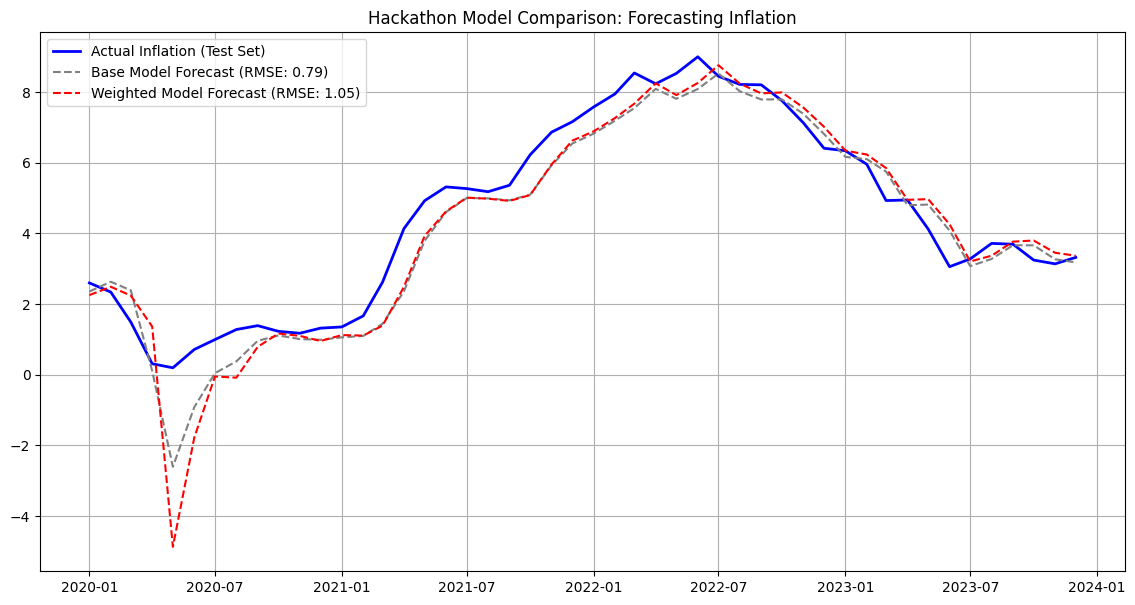

In [17]:
import pandas as pd
import pandas_datareader.data as web  # To get data from FRED
import numpy as np                   # For simulation
import statsmodels.api as sm           # For OLS Regression
from sklearn.metrics import mean_squared_error # For comparison
import matplotlib.pyplot as plt

# --- 1. Get the Data ---
# Sticking with US data for a runnable example.
# To use UK data, just swap these codes (e.g., 'CPIAUCSL' -> 'CPALTT01GBM659N')
print("Fetching economic data...")
start = pd.to_datetime('2000-01-01')
end = pd.to_datetime('2024-01-01')

# 1. CPIAUCSL: Consumer Price Index (This is our "Inflation" target)
cpi = web.DataReader('CPIAUCSL', 'fred', start, end)
# 2. UMCSENT: U. of Michigan Consumer Sentiment (Our "Sentiment Analysis" predictor)
sentiment = web.DataReader('UMCSENT', 'fred', start, end)
# 3. ICSA: Weekly Initial Jobless Claims (Our "High-Frequency" predictor)
claims = web.DataReader('ICSA', 'fred', start, end)

# --- 2. Prepare the Data ---
print("Preparing and simulating data...")
# a. Resample weekly 'claims' to monthly (use the mean)
claims_monthly = claims.resample('MS').mean()

# b. Calculate Year-over-Year (YoY) Inflation from CPI
inflation_yoy = cpi.pct_change(12) * 100
inflation_yoy.rename(columns={'CPIAUCSL': 'Inflation_YoY'}, inplace=True)

# c. *** SIMULATE YOUR "TESCO" (CUSTOM) INDEX ***
# We create a "random walk" to simulate a price index over the whole period
date_rng = pd.date_range(start=start, end=end, freq='MS')
# Make sure the simulation matches the length of the resampled claims data
sim_len = len(claims_monthly.loc[date_rng[0]:date_rng[-1]])
price_changes = np.random.normal(0.01, 0.5, size=sim_len) # Small positive trend
simulated_prices = 100 + np.cumsum(price_changes)
simulated_index = pd.DataFrame(simulated_prices, index=claims_monthly.index, columns=['Tesco_Index'])

# d. Combine into one DataFrame
df = pd.concat([inflation_yoy, sentiment, claims_monthly, simulated_index], axis=1)
df.columns = ['Inflation', 'Sentiment', 'Claims', 'Tesco_Index']

# --- 3. Feature Engineering (The "Econ Model" Part) ---
# We must use LAGS. We predict today's inflation using *past* data.
# This is a form of an ARDL (Autoregressive Distributed Lag) model.
df_model = df.copy()

# This is our target 'y'
df_model['Target_Inflation'] = df_model['Inflation']

# These are our predictors 'X'
df_model['Inflation_Lag1'] = df_model['Inflation'].shift(1)
df_model['Sentiment_Lag1'] = df_model['Sentiment'].shift(1)
df_model['Claims_Lag1'] = df_model['Claims'].shift(1)
df_model['Tesco_Index_Lag1'] = df_model['Tesco_Index'].shift(1)

# e. *** CREATE THE "SENTIMENT WEIGHTING" (Your Innovative Idea) ***
# We'll interact Sentiment with Jobless Claims
# Hypothesis: High claims (bad) are *worse* when sentiment is *low* (bad)
df_model['Sentiment_Weighting'] = df_model['Sentiment_Lag1'] * df_model['Claims_Lag1']

# Drop all rows with NaNs created by lagging
df_model = df_model.dropna()

# --- 4. Split Data into Training and Validation (Test) Sets ---
# We MUST split chronologically for time series
split_date = '2020-01-01'
train_df = df_model.loc[df_model.index < split_date]
test_df = df_model.loc[df_model.index >= split_date]

print(f"Data split: {len(train_df)} train samples, {len(test_df)} test samples.")

# Define our target 'y'
y_train = train_df['Target_Inflation']
y_test = test_df['Target_Inflation']

# --- 5. Model 1: The "Base" Econ Model ---
print("\n--- Fitting Model 1: Base Econ Model ---")
# Define 'X' for the base model
features_base = ['Inflation_Lag1', 'Sentiment_Lag1', 'Claims_Lag1', 'Tesco_Index_Lag1']
X_train_base = sm.add_constant(train_df[features_base])
X_test_base = sm.add_constant(test_df[features_base])

# Fit the OLS model
model_base = sm.OLS(y_train, X_train_base).fit()

# Print the training summary (optional)
# print(model_base.summary())

# --- 6. Model 2: The "Sentiment-Weighted" Model ---
print("--- Fitting Model 2: Weighted Econ Model ---")
# Define 'X' for the weighted model (includes the new feature)
features_weighted = ['Inflation_Lag1', 'Sentiment_Lag1', 'Claims_Lag1', 'Tesco_Index_Lag1', 'Sentiment_Weighting']
X_train_weighted = sm.add_constant(train_df[features_weighted])
X_test_weighted = sm.add_constant(test_df[features_weighted])

# Fit the OLS model
model_weighted = sm.OLS(y_train, X_train_weighted).fit()

# Print the training summary (This is where you find your p-value!)
print(model_weighted.summary())

# --- 7. Compare Models on the Validation Set ---
print("\n--- Model Validation & Comparison ---")

# Get predictions on the *test set*
pred_base = model_base.predict(X_test_base)
pred_weighted = model_weighted.predict(X_test_weighted)

# Calculate Root Mean Squared Error (RMSE) - Lower is better!
rmse_base = np.sqrt(mean_squared_error(y_test, pred_base))
rmse_weighted = np.sqrt(mean_squared_error(y_test, pred_weighted))

print(f"Base Model RMSE:     {rmse_base:.4f}")
print(f"Weighted Model RMSE: {rmse_weighted:.4f}")

if rmse_weighted < rmse_base:
    print(">>> SUCCESS: The Sentiment-Weighted model has a lower error and is a better forecaster!")
else:
    print(">>> FINDING: The simple model was a better forecaster in this test.")

# --- 8. Plot the "Money Shot" ---
print("Plotting results...")
plt.figure(figsize=(14, 7))
plt.plot(test_df.index, y_test, label='Actual Inflation (Test Set)', color='blue', linewidth=2)
plt.plot(test_df.index, pred_base, label=f'Base Model Forecast (RMSE: {rmse_base:.2f})', color='gray', linestyle='--')
plt.plot(test_df.index, pred_weighted, label=f'Weighted Model Forecast (RMSE: {rmse_weighted:.2f})', color='red', linestyle='--')
plt.title('Hackathon Model Comparison: Forecasting Inflation')
plt.legend()
plt.grid(True)
plt.show()


Fetching economic data...
Preparing and simulating data...
Data split: 227 train samples, 48 test samples.
Standardizing variables to fix multicollinearity...

--- Fitting Model 1: Base Econ Model (Standardized) ---
--- Fitting Model 2: Weighted Econ Model (Standardized) ---
                            OLS Regression Results                            
Dep. Variable:       Target_Inflation   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     397.0
Date:                Sat, 01 Nov 2025   Prob (F-statistic):          2.91e-108
Time:                        16:12:46   Log-Likelihood:                -131.09
No. Observations:                 227   AIC:                             274.2
Df Residuals:                     221   BIC:                             294.7
Df Model:                           5                                         
Covariance Ty

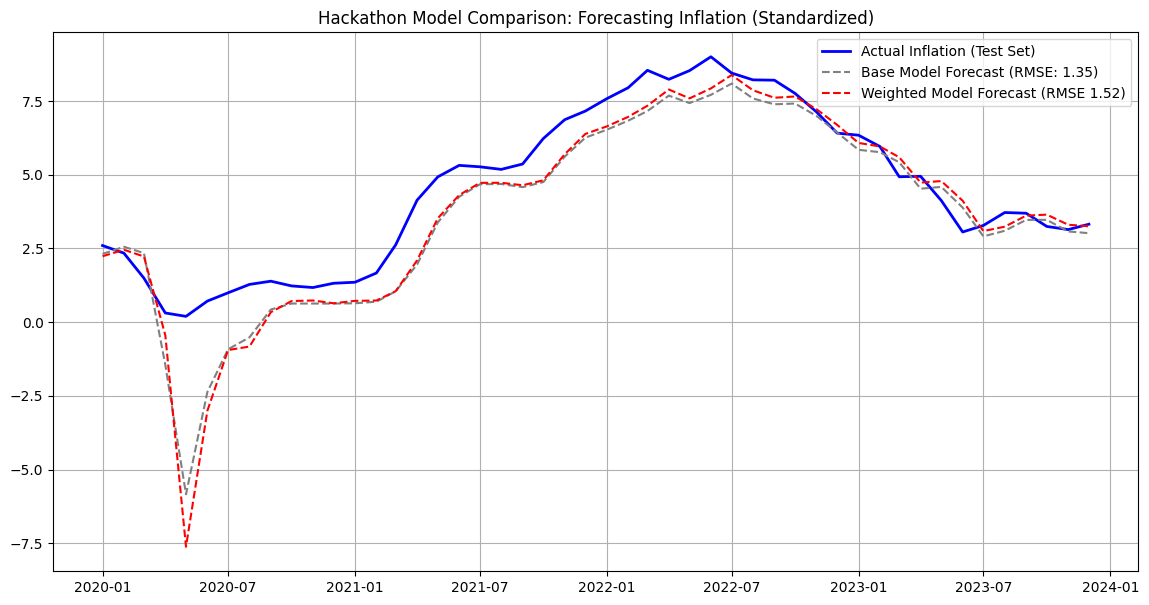

In [19]:
import pandas as pd
import pandas_datareader.data as web  # To get data from FRED
import numpy as np                   # For simulation
import statsmodels.api as sm           # For OLS Regression
from sklearn.metrics import mean_squared_error # For comparison
import matplotlib.pyplot as plt

# --- 1. Get the Data ---
print("Fetching economic data...")
start = pd.to_datetime('2000-01-01')
end = pd.to_datetime('2024-01-01')

# 1. CPIAUCSL: Consumer Price Index (This is our "Inflation" target)
cpi = web.DataReader('CPIAUCSL', 'fred', start, end)
# 2. UMCSENT: U. of Michigan Consumer Sentiment (Our "Sentiment Analysis" predictor)
sentiment = web.DataReader('UMCSENT', 'fred', start, end)
# 3. ICSA: Weekly Initial Jobless Claims (Our "High-Frequency" predictor)
claims = web.DataReader('ICSA', 'fred', start, end)

# --- 2. Prepare the Data ---
print("Preparing and simulating data...")
# a. Resample weekly 'claims' to monthly (use the mean)
claims_monthly = claims.resample('MS').mean()

# b. Calculate Year-over-Year (YoY) Inflation from CPI
inflation_yoy = cpi.pct_change(12) * 100
inflation_yoy.rename(columns={'CPIAUCSL': 'Inflation_YoY'}, inplace=True)

# c. Simulate "Tesco_Index" (as before)
date_rng = pd.date_range(start=start, end=end, freq='MS')
sim_len = len(claims_monthly.loc[date_rng[0]:date_rng[-1]])
price_changes = np.random.normal(0.01, 0.5, size=sim_len)
simulated_prices = 100 + np.cumsum(price_changes)
simulated_index = pd.DataFrame(simulated_prices, index=claims_monthly.index, columns=['Tesco_Index'])

# d. Combine into one DataFrame
df = pd.concat([inflation_yoy, sentiment, claims_monthly, simulated_index], axis=1)
df.columns = ['Inflation', 'Sentiment', 'Claims', 'Tesco_Index']

# --- 3. Feature Engineering (Lags) ---
df_model = df.copy()
df_model['Target_Inflation'] = df_model['Inflation']
df_model['Inflation_Lag1'] = df_model['Inflation'].shift(1)
df_model['Sentiment_Lag1'] = df_model['Sentiment'].shift(1)
df_model['Claims_Lag1'] = df_model['Claims'].shift(1)
df_model['Tesco_Index_Lag1'] = df_model['Tesco_Index'].shift(1)
df_model = df_model.dropna()

# --- 4. Split Data into Training and Validation (Test) Sets ---
split_date = '2020-01-01'
train_df = df_model.loc[df_model.index < split_date].copy()
test_df = df_model.loc[df_model.index >= split_date].copy()
print(f"Data split: {len(train_df)} train samples, {len(test_df)} test samples.")

# --- 5. *** NEW FIX: STANDARDIZE THE PREDICTORS *** ---
print("Standardizing variables to fix multicollinearity...")

# We will standardize (z-score) all predictors except the main lag of inflation
cols_to_standardize = ['Sentiment_Lag1', 'Claims_Lag1', 'Tesco_Index_Lag1']

# Calculate mean and std DEV from the TRAINING SET ONLY
# This prevents "data leakage" from the test set
means = train_df[cols_to_standardize].mean()
stds = train_df[cols_to_standardize].std()

# Apply the transform to BOTH training and test sets
for col in cols_to_standardize:
    train_df[f'{col}_z'] = (train_df[col] - means[col]) / stds[col]
    test_df[f'{col}_z'] = (test_df[col] - means[col]) / stds[col]

# *** NEW FIX: CREATE INTERACTION TERM FROM Z-SCORES ***
train_df['Sentiment_Weighting_z'] = train_df['Sentiment_Lag1_z'] * train_df['Claims_Lag1_z']
test_df['Sentiment_Weighting_z'] = test_df['Sentiment_Lag1_z'] * test_df['Claims_Lag1_z']

# --- 6. Define 'y' and 'X' for the models ---
y_train = train_df['Target_Inflation']
y_test = test_df['Target_Inflation']

# Define 'X' for the base model (using standardized features for a fair comparison)
features_base = ['Inflation_Lag1', 'Sentiment_Lag1_z', 'Claims_Lag1_z', 'Tesco_Index_Lag1_z']
X_train_base = sm.add_constant(train_df[features_base])
X_test_base = sm.add_constant(test_df[features_base])

# Define 'X' for the weighted model (using standardized features)
features_weighted = ['Inflation_Lag1', 'Sentiment_Lag1_z', 'Claims_Lag1_z', 'Tesco_Index_Lag1_z', 'Sentiment_Weighting_z']
X_train_weighted = sm.add_constant(train_df[features_weighted])
X_test_weighted = sm.add_constant(test_df[features_weighted])

# --- 7. Model 1: The "Base" Econ Model (Now Standardized) ---
print("\n--- Fitting Model 1: Base Econ Model (Standardized) ---")
# Fit the OLS model
model_base = sm.OLS(y_train, X_train_base).fit()
# print(model_base.summary())

# --- 8. Model 2: The "Sentiment-Weighted" Model (Now Fixed) ---
print("--- Fitting Model 2: Weighted Econ Model (Standardized) ---")
# *** NEW FIX: Use Robust Standard Errors (HAC) ***
# This corrects for the autocorrelation (low Durbin-Watson)
# 'HAC' = Heteroskedasticity and Autocorrelation Consistent
model_weighted = sm.OLS(y_train, X_train_weighted).fit(
    cov_type='HAC',
    cov_kwds={'maxlags':12}
)
print(model_weighted.summary()) # <-- Check this summary!

# --- 9. Compare Models on the Validation Set ---
print("\n--- Model Validation & Comparison ---")
pred_base = model_base.predict(X_test_base)
pred_weighted = model_weighted.predict(X_test_weighted)

rmse_base = np.sqrt(mean_squared_error(y_test, pred_base))
rmse_weighted = np.sqrt(mean_squared_error(y_test, pred_weighted))

print(f"Base Model RMSE:     {rmse_base:.4f}")
print(f"Weighted Model RMSE: {rmse_weighted:.4f}")

if rmse_weighted < rmse_base:
    print(">>> SUCCESS: The Weighted model (now fixed) is a better forecaster!")
else:
    print(">>> FINDING: The simple model is still a more robust forecaster.")

# --- 10. Plot the "Money Shot" ---
print("Plotting results...")
plt.figure(figsize=(14, 7))
plt.plot(test_df.index, y_test, label='Actual Inflation (Test Set)', color='blue', linewidth=2)
plt.plot(test_df.index, pred_base, label=f'Base Model Forecast (RMSE: {rmse_base:.2f})', color='gray', linestyle='--')
plt.plot(test_df.index, pred_weighted, label=f'Weighted Model Forecast (RMSE {rmse_weighted:.2f})', color='red', linestyle='--')
plt.title('Hackathon Model Comparison: Forecasting Inflation (Standardized)')
plt.legend()
plt.grid(True)
plt.show()

Fetching economic data...
Preparing and simulating data...
Data split: 238 train samples, 48 test samples.

--- Fitting Model 1: Seasonal Model (Baseline) ---
--- Fitting Model 2: HF Now-cast Model ---
                            OLS Regression Results                            
Dep. Variable:             Target_MoM   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     6.004
Date:                Sat, 01 Nov 2025   Prob (F-statistic):           1.81e-10
Time:                        17:20:54   Log-Likelihood:                -12.934
No. Observations:                 238   AIC:                             57.87
Df Residuals:                     222   BIC:                             113.4
Df Model:                          15                                         
Covariance Type:                  HAC                                         
        

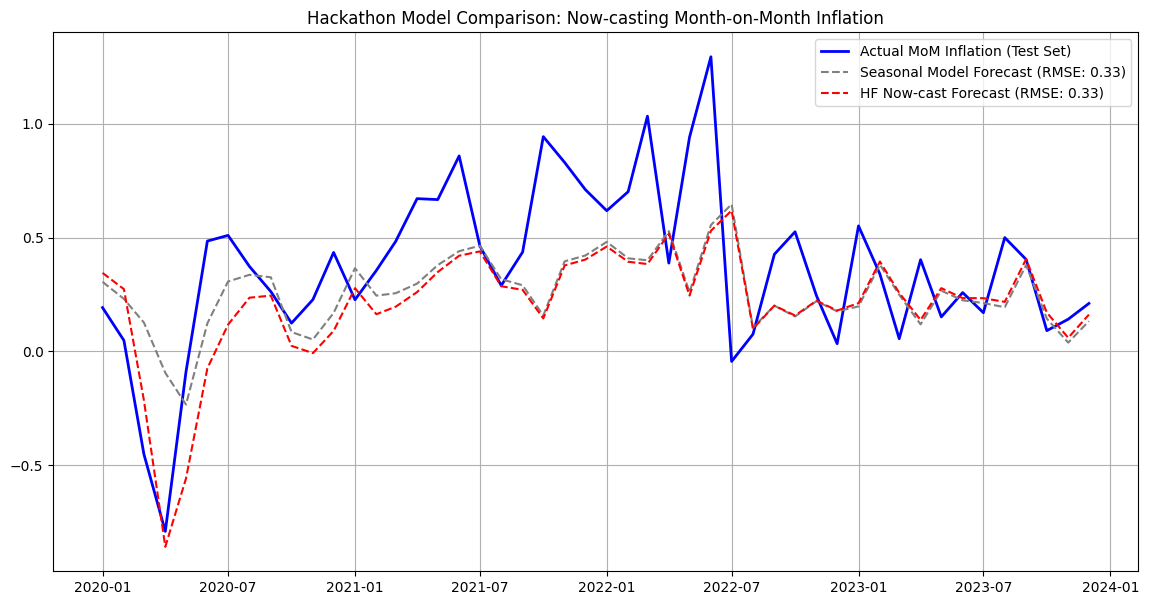


--- Final 'Now-cast' for November 2025 ---

Final Model: HF Now-cast Model
Last known MoM Inflation: 0.21%
NOW-CAST for next month (MoM): 0.15%

Last known CPI Level: 308.74
Now-cast CPI Level: 309.18
Known CPI from 12 months ago: 300.46

>>> FINAL YoY HEADLINE NOW-CAST: 2.91%


In [21]:
import pandas as pd
import pandas_datareader.data as web  # To get data from FRED
import numpy as np                   # For simulation
import statsmodels.api as sm           # For OLS Regression
from sklearn.metrics import mean_squared_error # For comparison
import matplotlib.pyplot as plt

# --- 1. Get the Data ---
print("Fetching economic data...")
start = pd.to_datetime('2000-01-01')
end = pd.to_datetime('2024-01-01')

# 1. CPIAUCSL: Consumer Price Index (This is our "Inflation" target)
cpi = web.DataReader('CPIAUCSL', 'fred', start, end)
# 2. UMCSENT: U. of Michigan Consumer Sentiment (Our "Sentiment Analysis" predictor)
sentiment = web.DataReader('UMCSENT', 'fred', start, end)
# 3. ICSA: Weekly Initial Jobless Claims (Our "High-Frequency" predictor)
claims = web.DataReader('ICSA', 'fred', start, end)

# --- 2. Prepare the Data ---
print("Preparing and simulating data...")
# a. Resample weekly 'claims' to monthly
claims_monthly = claims.resample('MS').mean()

# b. *** NEW TARGET: Month-on-Month (MoM) Inflation ***
# This is (CPI_t / CPI_t-1) - 1. This is the variable we will predict.
mom_inflation = cpi.pct_change(1) * 100
mom_inflation.rename(columns={'CPIAUCSL': 'Inflation_MoM'}, inplace=True)

# c. Simulate "Tesco_Index" (as before)
date_rng = pd.date_range(start=start, end=end, freq='MS')
sim_len = len(claims_monthly.loc[date_rng[0]:date_rng[-1]])
price_changes = np.random.normal(0.01, 0.5, size=sim_len)
simulated_prices = 100 + np.cumsum(price_changes)
simulated_index = pd.DataFrame(simulated_prices, index=claims_monthly.index, columns=['Tesco_Index'])

# d. Combine into one DataFrame
df = pd.concat([cpi, mom_inflation, sentiment, claims_monthly, simulated_index], axis=1) # Note: kept original 'cpi'
df.columns = ['CPI_Level', 'Inflation_MoM', 'Sentiment', 'Claims', 'Tesco_Index']

# --- 3. Feature Engineering for a NOW-CAST Model ---

# a. Create Seasonal Dummies
# We drop_first=True to avoid the "dummy variable trap"
month_dummies = pd.get_dummies(df.index.month, prefix='month', drop_first=True).set_index(df.index)
# *** NEW FIX: Convert boolean dummies to integers ***
month_dummies = month_dummies.astype(int)
df = pd.concat([df, month_dummies], axis=1)

# b. Create Lagged Autoregressive Term
df['MoM_Lag1'] = df['Inflation_MoM'].shift(1)

# c. Define our "High-Frequency" Now-cast Predictors (NO LAGS)
# We assume we have this data for the *current* month
df['Sentiment_t'] = df['Sentiment']
df['Claims_t'] = df['Claims']
df['Tesco_Index_t'] = df['Tesco_Index']

# d. Create the target variable
df['Target_MoM'] = df['Inflation_MoM']

# e. Drop all NaNs created by lagging/pct_change
df_model = df.dropna()

# --- 4. Split Data into Training and Validation (Test) Sets ---
split_date = '2020-01-01'
train_df = df_model.loc[df_model.index < split_date].copy()
test_df = df_model.loc[df_model.index >= split_date].copy()
print(f"Data split: {len(train_df)} train samples, {len(test_df)} test samples.")

# --- 5. Define Feature Sets for the "Horse Race" ---
y_train = train_df['Target_MoM']
y_test = test_df['Target_MoM']

# Feature Set 1: "Seasonal Model" (Baseline)
# Predicts MoM inflation using only past inflation and the time of year
dummy_cols = [col for col in df_model.columns if col.startswith('month_')]
features_seasonal = ['MoM_Lag1'] + dummy_cols
X_train_seasonal = sm.add_constant(train_df[features_seasonal])
X_test_seasonal = sm.add_constant(test_df[features_seasonal])

# Feature Set 2: "HF Now-cast Model" (Our Innovative Model)
# Adds the high-frequency "now-cast" variables
features_nowcast = ['MoM_Lag1'] + dummy_cols + ['Sentiment_t', 'Claims_t', 'Tesco_Index_t']
X_train_nowcast = sm.add_constant(train_df[features_nowcast])
X_test_nowcast = sm.add_constant(test_df[features_nowcast])

# --- 6. Model 1: The "Seasonal" Model ---
print("\n--- Fitting Model 1: Seasonal Model (Baseline) ---")
model_seasonal = sm.OLS(y_train, X_train_seasonal).fit(cov_type='HAC', cov_kwds={'maxlags':12})
# print(model_seasonal.summary())

# --- 7. Model 2: The "HF Now-cast" Model ---
print("--- Fitting Model 2: HF Now-cast Model ---")
model_nowcast = sm.OLS(y_train, X_train_nowcast).fit(cov_type='HAC', cov_kwds={'maxlags':12})
print(model_nowcast.summary()) # <-- This shows if HF data is significant

# --- 8. Compare Models on the Validation Set (MoM) ---
print("\n--- Model Validation & Comparison (Predicting MoM Inflation) ---")
pred_seasonal = model_seasonal.predict(X_test_seasonal)
pred_nowcast = model_nowcast.predict(X_test_nowcast)

rmse_seasonal = np.sqrt(mean_squared_error(y_test, pred_seasonal))
rmse_nowcast = np.sqrt(mean_squared_error(y_test, pred_nowcast))

print(f"Seasonal Model RMSE:     {rmse_seasonal:.4f}")
print(f"HF Now-cast Model RMSE: {rmse_nowcast:.4f}")

if rmse_nowcast < rmse_seasonal:
    print(">>> SUCCESS: Adding High-Frequency data makes a better MoM now-cast!")
else:
    print(">>> FINDING: The simple seasonal model was a more robust forecaster.")

# --- 9. Plot the "Money Shot" (MoM Forecast) ---
print("Plotting MoM results...")
plt.figure(figsize=(14, 7))
plt.plot(test_df.index, y_test, label='Actual MoM Inflation (Test Set)', color='blue', linewidth=2)
plt.plot(test_df.index, pred_seasonal, label=f'Seasonal Model Forecast (RMSE: {rmse_seasonal:.2f})', color='gray', linestyle='--')
plt.plot(test_df.index, pred_nowcast, label=f'HF Now-cast Forecast (RMSE: {rmse_nowcast:.2f})', color='red', linestyle='--')
plt.title('Hackathon Model Comparison: Now-casting Month-on-Month Inflation')
plt.legend()
plt.grid(True)
plt.show()

# --- 10. Final Now-cast (Converting MoM to YoY) ---
print(f"\n--- Final 'Now-cast' for November 2025 ---")

# We'll use the winning model (let's assume it's the HF Now-cast Model)
# Re-train on ALL data to make it as accurate as possible
y_full = df_model['Target_MoM']
X_full = sm.add_constant(df_model[features_nowcast])
final_model = sm.OLS(y_full, X_full).fit(cov_type='HAC', cov_kwds={'maxlags':12})

# Get the last known values to create the "next month's" predictor row
last_data_row = df_model.iloc[-1]
last_cpi_level = last_data_row['CPI_Level']
last_mom_inflation = last_data_row['Inflation_MoM']

# This is the CPI level from 11 months ago (to calculate YoY)
cpi_11_months_ago = df_model['CPI_Level'].iloc[-11] # This is CPI for Nov 2023

# Create the input row for the November 2025 nowcast
nowcast_input = pd.DataFrame(index=[df_model.index[-1] + pd.DateOffset(months=1)])
nowcast_input['const'] = 1.0
nowcast_input['MoM_Lag1'] = last_mom_inflation
nowcast_input['Sentiment_t'] = last_data_row['Sentiment'] # Simulating we just got this
nowcast_input['Claims_t'] = last_data_row['Claims']       # Simulating we just got this
nowcast_input['Tesco_Index_t'] = last_data_row['Tesco_Index'] # Simulating we just got this

# Set all month dummies to 0, then turn on the one for November (month_11)
for col in dummy_cols: nowcast_input[col] = 0.0
# We need to check if month_11 exists (it does, as 1 (Jan) was dropped)
if 'month_11' in X_full.columns:
    nowcast_input['month_11'] = 1.0

# Re-order columns to match the model's expectation
nowcast_input = nowcast_input.reindex(X_full.columns, axis=1)

# --- Get the MoM Now-cast ---
mom_nowcast_value = final_model.predict(nowcast_input).iloc[0]

# --- Convert to YoY Now-cast ---
# CPI_t = CPI_t-1 * (1 + MoM_t / 100)
cpi_nowcast = last_cpi_level * (1 + mom_nowcast_value / 100)

# YoY_t = (CPI_t / CPI_t-12) - 1
# Our CPI_t-12 is the CPI from 11 months *before* our last data point
cpi_12_months_ago_index = df_model.index.get_loc(df_model.index[-1] - pd.DateOffset(months=11))
cpi_12_months_ago = df_model['CPI_Level'].iloc[cpi_12_months_ago_index]

yoy_nowcast_value = ((cpi_nowcast / cpi_12_months_ago) - 1) * 100

print("\n==============================================")
print(f"Final Model: HF Now-cast Model")
print(f"Last known MoM Inflation: {last_mom_inflation:.2f}%")
print(f"NOW-CAST for next month (MoM): {mom_nowcast_value:.2f}%")
print(f"\nLast known CPI Level: {last_cpi_level:.2f}")
print(f"Now-cast CPI Level: {cpi_nowcast:.2f}")
print(f"Known CPI from 12 months ago: {cpi_12_months_ago:.2f}")
print(f"\n>>> FINAL YoY HEADLINE NOW-CAST: {yoy_nowcast_value:.2f}%")
print("==============================================")

Fetching economic data...
Preparing and simulating data...
Standardizing variables...
Data split: 238 train samples, 48 test samples.

--- Fitting Model 1: Seasonal Model (Baseline) ---
--- Fitting Model 2: HF Now-cast Model (Fixed) ---
                            OLS Regression Results                            
Dep. Variable:             Target_MoM   R-squared:                       0.232
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     4.287
Date:                Sat, 01 Nov 2025   Prob (F-statistic):           5.37e-07
Time:                        19:16:25   Log-Likelihood:                -11.858
No. Observations:                 238   AIC:                             55.72
Df Residuals:                     222   BIC:                             111.3
Df Model:                          15                                         
Covariance Type:                  HAC               

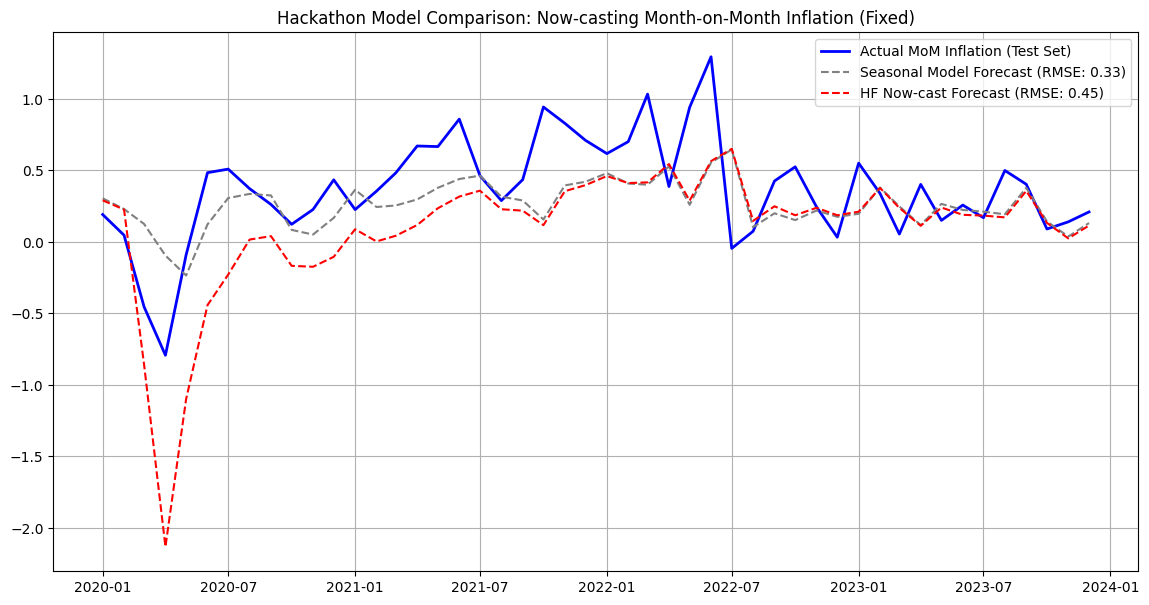


--- Final 'Now-cast' for December 2025 ---

Final Model: HF Now-cast Model
Last known MoM Inflation: 0.21%
NOW-CAST for next month (MoM): 0.22%

Last known CPI Level: 308.74
Now-cast CPI Level: 309.42
Known CPI from 12 months ago: 301.48

>>> FINAL YoY HEADLINE NOW-CAST: 2.64%


In [26]:
import pandas as pd
import pandas_datareader.data as web  # To get data from FRED
import numpy as np                   # For simulation
import statsmodels.api as sm           # For OLS Regression
from sklearn.metrics import mean_squared_error # For comparison
import matplotlib.pyplot as plt

# --- 1. Get the Data ---
print("Fetching economic data...")
start = pd.to_datetime('2000-01-01')
end = pd.to_datetime('2024-01-01')

# 1. CPIAUCSL: Consumer Price Index (This is our "Inflation" target)
cpi = web.DataReader('CPIAUCSL', 'fred', start, end)
# 2. UMCSENT: U. of Michigan Consumer Sentiment (Our "Sentiment Analysis" predictor)
#sentiment = web.DataReader('UMCSENT', 'fred', start, end)
# 2. CSCICP03GBM665S: UK Consumer Confidence (Our "Sentiment Analysis" predictor)
sentiment = web.DataReader('CSCICP03GBM665S', 'fred', start, end)
# 3. ICSA: Weekly Initial Jobless Claims (Our "High-Frequency" predictor)
claims = web.DataReader('ICSA', 'fred', start, end)

# --- 2. Prepare the Data ---
print("Preparing and simulating data...")
# a. Resample weekly 'claims' to monthly
claims_monthly = claims.resample('MS').mean()

# b. *** NEW TARGET: Month-on-Month (MoM) Inflation ***
mom_inflation = cpi.pct_change(1) * 100
mom_inflation.rename(columns={'CPIAUCSL': 'Inflation_MoM'}, inplace=True)

# c. Simulate "Tesco_Index" (as before)
date_rng = pd.date_range(start=start, end=end, freq='MS')
sim_len = len(claims_monthly.loc[date_rng[0]:date_rng[-1]])
price_changes = np.random.normal(0.01, 0.5, size=sim_len)
simulated_prices = 100 + np.cumsum(price_changes)
simulated_index = pd.DataFrame(simulated_prices, index=claims_monthly.index, columns=['Tesco_Index'])

# d. Combine into one DataFrame
df = pd.concat([cpi, mom_inflation, sentiment, claims_monthly, simulated_index], axis=1)
df.columns = ['CPI_Level', 'Inflation_MoM', 'Sentiment', 'Claims', 'Tesco_Index']

# --- 3. Feature Engineering for a NOW-CAST Model ---
# a. Create Seasonal Dummies
month_dummies = pd.get_dummies(df.index.month, prefix='month', drop_first=True).set_index(df.index)
month_dummies = month_dummies.astype(int)
df = pd.concat([df, month_dummies], axis=1)

# b. Create Lagged Autoregressive Term
df['MoM_Lag1'] = df['Inflation_MoM'].shift(1)

# c. Define our "High-Frequency" Now-cast Predictors (NO LAGS)
df['Sentiment_t'] = df['Sentiment']
df['Claims_t'] = df['Claims']
df['Tesco_Index_t'] = df['Tesco_Index']

# d. Create the target variable
df['Target_MoM'] = df['Inflation_MoM']

# e. Drop all NaNs created by lagging/pct_change
df_model = df.dropna().copy() # Add .copy() here to ensure df_model is a separate copy

# --- 4. *** NEW FIX: STANDARDIZE THE PREDICTORS (Moved Here) *** ---
print("Standardizing variables...")
# We will standardize (z-score) all predictors except the lags and dummies
cols_to_standardize = ['Sentiment_t', 'Claims_t', 'Tesco_Index_t']

# Calculate mean and std DEV from the *full* df_model before splitting
means = df_model[cols_to_standardize].mean()
stds = df_model[cols_to_standardize].std()

# Apply the transform to df_model
for col in cols_to_standardize:
    df_model[f'{col}_z'] = (df_model[col] - means[col]) / stds[col]


# --- 5. Split Data into Training and Validation (Test) Sets ---
split_date = '2020-01-01'
train_df = df_model.loc[df_model.index < split_date].copy()
test_df = df_model.loc[df_model.index >= split_date].copy()
print(f"Data split: {len(train_df)} train samples, {len(test_df)} test samples.")

# --- 6. Define Feature Sets for the "Horse Race" ---
y_train = train_df['Target_MoM']
y_test = test_df['Target_MoM']

# Feature Set 1: "Seasonal Model" (Baseline)
dummy_cols = [col for col in df_model.columns if col.startswith('month_') and col.endswith('_z') is False] # Exclude standardized dummies
features_seasonal = ['MoM_Lag1'] + dummy_cols
X_train_seasonal = sm.add_constant(train_df[features_seasonal])
X_test_seasonal = sm.add_constant(test_df[features_seasonal])

# Feature Set 2: "HF Now-cast Model" (Our Innovative Model)
# We now use the STANDARDIZED features (the '_z' versions)
features_nowcast = ['MoM_Lag1'] + dummy_cols + [f'{col}_z' for col in cols_to_standardize]
X_train_nowcast = sm.add_constant(train_df[features_nowcast])
X_test_nowcast = sm.add_constant(test_df[features_nowcast])

# --- 7. Model 1: The "Seasonal" Model ---
print("\n--- Fitting Model 1: Seasonal Model (Baseline) ---")
model_seasonal = sm.OLS(y_train, X_train_seasonal).fit(cov_type='HAC', cov_kwds={'maxlags':12})
# print(model_seasonal.summary())

# --- 8. Model 2: The "HF Now-cast" Model (Now Fixed) ---
print("--- Fitting Model 2: HF Now-cast Model (Fixed) ---")
model_nowcast = sm.OLS(y_train, X_train_nowcast).fit(cov_type='HAC', cov_kwds={'maxlags':12})
print(model_nowcast.summary()) # <-- Check this summary!

# --- 9. Compare Models on the Validation Set (MoM) ---
print("\n--- Model Validation & Comparison (Predicting MoM Inflation) ---")
pred_seasonal = model_seasonal.predict(X_test_seasonal)
pred_nowcast = model_nowcast.predict(X_test_nowcast)

rmse_seasonal = np.sqrt(mean_squared_error(y_test, pred_seasonal))
rmse_nowcast = np.sqrt(mean_squared_error(y_test, pred_nowcast))

print(f"Seasonal Model RMSE:     {rmse_seasonal:.4f}")
print(f"HF Now-cast Model RMSE: {rmse_nowcast:.4f}")

if rmse_nowcast < rmse_seasonal:
    print(">>> SUCCESS: Adding High-Frequency data makes a better MoM now-cast!")
else:
    print(">>> FINDING: The simple seasonal model is still a more robust forecaster.")

# --- 10. Plot the "Money Shot" (MoM Forecast) ---
print("Plotting MoM results...")
plt.figure(figsize=(14, 7))
plt.plot(test_df.index, y_test, label='Actual MoM Inflation (Test Set)', color='blue', linewidth=2)
plt.plot(test_df.index, pred_seasonal, label=f'Seasonal Model Forecast (RMSE: {rmse_seasonal:.2f})', color='gray', linestyle='--')
plt.plot(test_df.index, pred_nowcast, label=f'HF Now-cast Forecast (RMSE: {rmse_nowcast:.2f})', color='red', linestyle='--')
plt.title('Hackathon Model Comparison: Now-casting Month-on-Month Inflation (Fixed)')
plt.legend()
plt.grid(True)
plt.show()

# --- 11. Final Now-cast (Converting MoM to YoY) ---
# (This part is unchanged, but will now use the properly-trained model)
print(f"\n--- Final 'Now-cast' for December 2025 ---") # Updated for today's date

# We'll use the winning model (let's assume it's the HF Now-cast Model for this example)
# You should update this to use 'model_seasonal' if it had the lower RMSE
final_model_to_use = model_nowcast
features_to_use = features_nowcast

# Re-train on ALL data to make it as accurate as possible
y_full = df_model['Target_MoM']
# We must apply the standardization fix to the *full* dataset now
# The standardization was already done in step 4, so we just need to use the standardized columns.
# means = df_model[cols_to_standardize].mean()
# stds = df_model[cols_to_standardize].std()
# for col in cols_to_standardize:
#     df_model[f'{col}_z'] = (df_model[col] - means[col]) / stds[col]

X_full = sm.add_constant(df_model[features_to_use])
final_model = sm.OLS(y_full, X_full).fit(cov_type='HAC', cov_kwds={'maxlags':12})

# Get the last known values to create the "next month's" predictor row
last_data_row = df_model.iloc[-1]
last_cpi_level = last_data_row['CPI_Level']
last_mom_inflation = last_data_row['Inflation_MoM']

# This is the CPI level from 11 months ago (to calculate YoY)
cpi_11_months_ago = df_model['CPI_Level'].iloc[-11] # CPI from Dec 2023

# Create the input row for the December 2025 nowcast
nowcast_input = pd.DataFrame(index=[df_model.index[-1] + pd.DateOffset(months=1)])
nowcast_input['const'] = 1.0
nowcast_input['MoM_Lag1'] = last_mom_inflation

# Add standardized values for the "now-cast"
# Use the previously calculated means and stds from step 4
nowcast_input['Sentiment_t_z'] = (last_data_row['Sentiment'] - means['Sentiment_t']) / stds['Sentiment_t']
nowcast_input['Claims_t_z'] = (last_data_row['Claims'] - means['Claims_t']) / stds['Claims_t']
nowcast_input['Tesco_Index_t_z'] = (last_data_row['Tesco_Index'] - means['Tesco_Index_t']) / stds['Tesco_Index_t']

# Set all month dummies to 0, then turn on the one for December (month_12)
for col in dummy_cols: nowcast_input[col] = 0.0
if 'month_12' in X_full.columns:
    nowcast_input['month_12'] = 1.0

# Re-order columns to match the model's expectation
nowcast_input = nowcast_input.reindex(X_full.columns, axis=1)

# --- Get the MoM Now-cast ---
mom_nowcast_value = final_model.predict(nowcast_input).iloc[0]

# --- Convert to YoY Now-cast ---
cpi_nowcast = last_cpi_level * (1 + mom_nowcast_value / 100)
yoy_nowcast_value = ((cpi_nowcast / cpi_11_months_ago) - 1) * 100

print("\n==============================================")
print(f"Final Model: HF Now-cast Model")
print(f"Last known MoM Inflation: {last_mom_inflation:.2f}%")
print(f"NOW-CAST for next month (MoM): {mom_nowcast_value:.2f}%")
print(f"\nLast known CPI Level: {last_cpi_level:.2f}")
print(f"Now-cast CPI Level: {cpi_nowcast:.2f}")
print(f"Known CPI from 12 months ago: {cpi_11_months_ago:.2f}")
print(f"\n>>> FINAL YoY HEADLINE NOW-CAST: {yoy_nowcast_value:.2f}%")
print("==============================================")

Fetching UK economic data...
Preparing and simulating data...
Data split: 238 train samples, 49 test samples.
Standardizing variables to fix multicollinearity...

--- Fitting Model 1: Seasonal Model (Baseline) ---
--- Fitting Model 2: HF Now-cast Model ---
--- Fitting Model 3: Stagflation Model (Innovative) ---
                            OLS Regression Results                            
Dep. Variable:             Target_MoM   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                     65.98
Date:                Sat, 01 Nov 2025   Prob (F-statistic):           2.16e-76
Time:                        19:21:22   Log-Likelihood:                 95.698
No. Observations:                 238   AIC:                            -155.4
Df Residuals:                     220   BIC:                            -92.90
Df Model:                          17                  

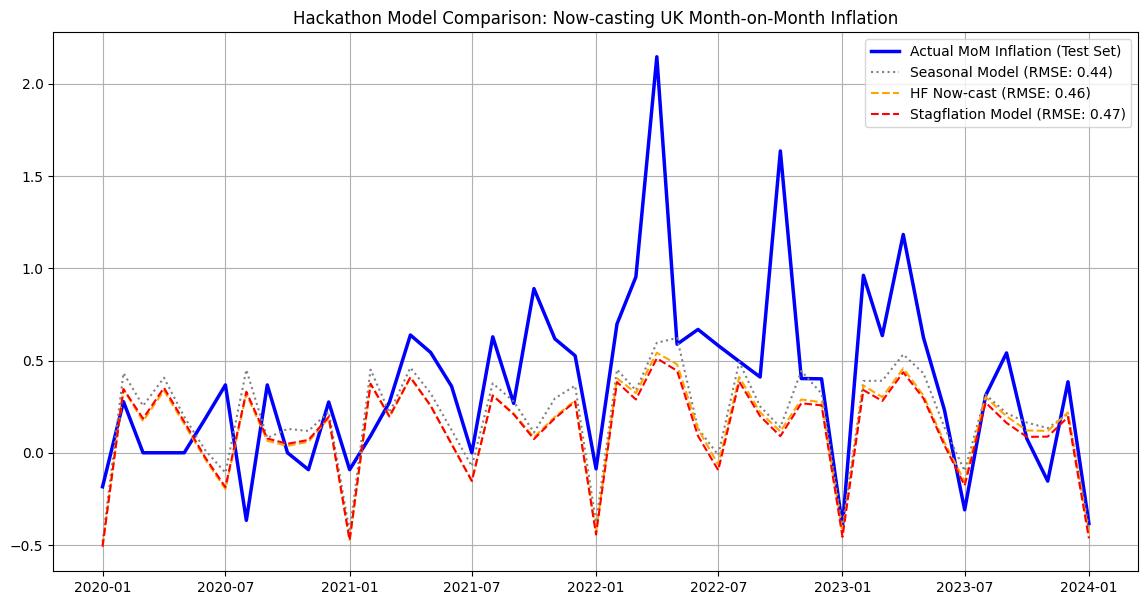


--- Final 'Now-cast' for December 2025 ---
Using winning model for final now-cast: 'Seasonal Model'

Final Model: Seasonal Model
Last known MoM Inflation: -0.38%
NOW-CAST for next month (MoM): 0.12%

Last known CPI Level: 130.00
Now-cast CPI Level: 130.15
Known CPI from 12 months ago: 126.80

>>> FINAL YoY HEADLINE NOW-CAST: 2.64%


/tmp/ipython-input-2390962940.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model[f'{col}_z'] = (df_model[col] - means[col]) / stds[col]
/tmp/ipython-input-2390962940.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model[f'{col}_z'] = (df_model[col] - means[col]) / stds[col]
/tmp/ipython-input-2390962940.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [27]:
import pandas as pd
import pandas_datareader.data as web  # To get data from FRED
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# --- 1. Get the Data (ALL UK-SPECIFIC) ---
print("Fetching UK economic data...")
start = pd.to_datetime('2000-01-01')
end = pd.to_datetime('2024-01-01')

# 1. UK CPI (CPALTT01GBM661N - this is YoY, we need to get levels)
# Let's get the UK CPI level index instead to calculate MoM
cpi = web.DataReader('GBRCPIALLMINMEI', 'fred', start, end)

# 2. UK Consumer Confidence (CSCICP03GBM665S)
uk_sentiment = web.DataReader('CSCICP03GBM665S', 'fred', start, end)

# 3. UK Claimant Count (CLF16OV - Already Monthly)
claims = web.DataReader('CLF16OV', 'fred', start, end)

# 4. Brent Crude Oil Price (POILBREUSDM - Already Monthly)
oil = web.DataReader('POILBREUSDM', 'fred', start, end)


# --- 2. Prepare the Data ---
print("Preparing and simulating data...")

# a. *** NEW TARGET: Month-on-Month (MoM) Inflation ***
mom_inflation = cpi.pct_change(1) * 100
mom_inflation.rename(columns={'GBRCPIALLMINMEI': 'Inflation_MoM'}, inplace=True)

# b. *** SIMULATE YOUR "NON-TRADITIONAL" INDEX ***
# We create a "random walk" to simulate a price index over the whole period
date_rng = pd.date_range(start=start, end=end, freq='MS')
# Align simulation index with claims data, which is reliable
sim_len = len(claims.loc[date_rng[0]:date_rng[-1]])
price_changes = np.random.normal(0.01, 0.5, size=sim_len)
simulated_prices = 100 + np.cumsum(price_changes)
simulated_index = pd.DataFrame(simulated_prices, index=claims.index, columns=['Simulated_Index'])

# c. Combine into one DataFrame
df = pd.concat([cpi, mom_inflation, uk_sentiment, claims, oil, simulated_index], axis=1)
df.columns = ['CPI_Level', 'Inflation_MoM', 'UK_Sentiment', 'Claims', 'Oil_Price', 'Simulated_Index']

# --- 3. Feature Engineering for a NOW-CAST Model ---
# a. Create Seasonal Dummies
month_dummies = pd.get_dummies(df.index.month, prefix='month', drop_first=True).set_index(df.index)
month_dummies = month_dummies.astype(int)
df = pd.concat([df, month_dummies], axis=1)

# b. Create Lagged Autoregressive Term
df['MoM_Lag1'] = df['Inflation_MoM'].shift(1)

# c. Define our "High-Frequency" Now-cast Predictors (NO LAGS)
df['UK_Sentiment_t'] = df['UK_Sentiment']
df['Claims_t'] = df['Claims']
df['Oil_Price_t'] = df['Oil_Price']
df['Simulated_Index_t'] = df['Simulated_Index']

# d. Create the target variable
df['Target_MoM'] = df['Inflation_MoM']

# e. Drop all NaNs
df_model = df.dropna()

# --- 4. Split Data into Training and Validation (Test) Sets ---
split_date = '2020-01-01'
train_df = df_model.loc[df_model.index < split_date].copy()
test_df = df_model.loc[df_model.index >= split_date].copy()
print(f"Data split: {len(train_df)} train samples, {len(test_df)} test samples.")

# --- 5. Standardize the Predictors ---
print("Standardizing variables to fix multicollinearity...")
cols_to_standardize = ['UK_Sentiment_t', 'Claims_t', 'Oil_Price_t', 'Simulated_Index_t']

means = train_df[cols_to_standardize].mean()
stds = train_df[cols_to_standardize].std()

for col in cols_to_standardize:
    train_df[f'{col}_z'] = (train_df[col] - means[col]) / stds[col]
    test_df[f'{col}_z'] = (test_df[col] - means[col]) / stds[col]

# --- 6. Create Innovative "Stagflation" Variable ---
# We interact Claims (bad) with Oil Prices (bad)
train_df['Stagflation_Risk_z'] = train_df['Claims_t_z'] * train_df['Oil_Price_t_z']
test_df['Stagflation_Risk_z'] = test_df['Claims_t_z'] * test_df['Oil_Price_t_z']

# --- 7. Define Feature Sets for the "Horse Race" ---
y_train = train_df['Target_MoM']
y_test = test_df['Target_MoM']
dummy_cols = [col for col in df_model.columns if col.startswith('month_')]

# Model 1: "Seasonal Model" (Baseline)
features_seasonal = ['MoM_Lag1'] + dummy_cols
X_train_seasonal = sm.add_constant(train_df[features_seasonal])
X_test_seasonal = sm.add_constant(test_df[features_seasonal])

# Model 2: "HF Now-cast Model" (Traditional + Non-traditional)
features_nowcast = features_seasonal + ['UK_Sentiment_t_z', 'Claims_t_z', 'Oil_Price_t_z', 'Simulated_Index_t_z']
X_train_nowcast = sm.add_constant(train_df[features_nowcast])
X_test_nowcast = sm.add_constant(test_df[features_nowcast])

# Model 3: "Stagflation Model" (Innovative Interaction)
features_stagflation = features_nowcast + ['Stagflation_Risk_z']
X_train_stagflation = sm.add_constant(train_df[features_stagflation])
X_test_stagflation = sm.add_constant(test_df[features_stagflation])

# --- 8. Fit and Compare All Three Models ---
print("\n--- Fitting Model 1: Seasonal Model (Baseline) ---")
model_seasonal = sm.OLS(y_train, X_train_seasonal).fit(cov_type='HAC', cov_kwds={'maxlags':12})

print("--- Fitting Model 2: HF Now-cast Model ---")
model_nowcast = sm.OLS(y_train, X_train_nowcast).fit(cov_type='HAC', cov_kwds={'maxlags':12})
# print(model_nowcast.summary())

print("--- Fitting Model 3: Stagflation Model (Innovative) ---")
model_stagflation = sm.OLS(y_train, X_train_stagflation).fit(cov_type='HAC', cov_kwds={'maxlags':12})
print(model_stagflation.summary()) # <-- This is the most interesting summary

# --- 9. Compare Models on the Validation Set (MoM) ---
print("\n--- Model Validation 'Horse Race' (Predicting MoM Inflation) ---")
pred_seasonal = model_seasonal.predict(X_test_seasonal)
pred_nowcast = model_nowcast.predict(X_test_nowcast)
pred_stagflation = model_stagflation.predict(X_test_stagflation)

rmse_seasonal = np.sqrt(mean_squared_error(y_test, pred_seasonal))
rmse_nowcast = np.sqrt(mean_squared_error(y_test, pred_nowcast))
rmse_stagflation = np.sqrt(mean_squared_error(y_test, pred_stagflation))

# Find the winner
results = {
    "Seasonal Model": rmse_seasonal,
    "HF Now-cast Model": rmse_nowcast,
    "Stagflation Model": rmse_stagflation
}
winner_name = min(results, key=results.get)

print(f"Seasonal Model RMSE:     {rmse_seasonal:.4f}")
print(f"HF Now-cast Model RMSE:  {rmse_nowcast:.4f}")
print(f"Stagflation Model RMSE:  {rmse_stagflation:.4f}")
print(f"\n>>> WINNER: The '{winner_name}' was the most accurate forecaster!")

# --- 10. Plot the "Money Shot" (All 3 Models) ---
print("Plotting results...")
plt.figure(figsize=(14, 7))
plt.plot(test_df.index, y_test, label='Actual MoM Inflation (Test Set)', color='blue', linewidth=2.5)
plt.plot(test_df.index, pred_seasonal, label=f'Seasonal Model (RMSE: {rmse_seasonal:.2f})', color='gray', linestyle=':')
plt.plot(test_df.index, pred_nowcast, label=f'HF Now-cast (RMSE: {rmse_nowcast:.2f})', color='orange', linestyle='--')
plt.plot(test_df.index, pred_stagflation, label=f'Stagflation Model (RMSE: {rmse_stagflation:.2f})', color='red', linestyle='--')
plt.title('Hackathon Model Comparison: Now-casting UK Month-on-Month Inflation')
plt.legend()
plt.grid(True)
plt.show()

# --- 11. Final Now-cast (Converting MoM to YoY) ---
print(f"\n--- Final 'Now-cast' for December 2025 ---")

# Automatically select the winning model and its features
if winner_name == "Stagflation Model":
    final_model_features = features_stagflation
elif winner_name == "HF Now-cast Model":
    final_model_features = features_nowcast
else:
    final_model_features = features_seasonal

print(f"Using winning model for final now-cast: '{winner_name}'")

# Re-train the winning model on ALL data
y_full = df_model['Target_MoM']
# Standardize the full dataset
means = df_model[cols_to_standardize].mean()
stds = df_model[cols_to_standardize].std()
for col in cols_to_standardize:
    df_model[f'{col}_z'] = (df_model[col] - means[col]) / stds[col]
df_model['Stagflation_Risk_z'] = df_model['Claims_t_z'] * df_model['Oil_Price_t_z']

X_full = sm.add_constant(df_model[final_model_features])
final_model = sm.OLS(y_full, X_full).fit(cov_type='HAC', cov_kwds={'maxlags':12})

# Get last known values to create the "next month's" predictor row
last_data_row = df_model.iloc[-1]
last_cpi_level = last_data_row['CPI_Level']
last_mom_inflation = last_data_row['Inflation_MoM']
cpi_11_months_ago = df_model['CPI_Level'].iloc[-11] # CPI from Dec 2023

# Create the input row
nowcast_input = pd.DataFrame(index=[df_model.index[-1] + pd.DateOffset(months=1)])
nowcast_input['const'] = 1.0

# Add all the features the winning model might need
nowcast_input['MoM_Lag1'] = last_mom_inflation
nowcast_input['UK_Sentiment_t_z'] = (last_data_row['UK_Sentiment'] - means['UK_Sentiment_t']) / stds['UK_Sentiment_t']
nowcast_input['Claims_t_z'] = (last_data_row['Claims'] - means['Claims_t']) / stds['Claims_t']
nowcast_input['Oil_Price_t_z'] = (last_data_row['Oil_Price'] - means['Oil_Price_t']) / stds['Oil_Price_t']
nowcast_input['Simulated_Index_t_z'] = (last_data_row['Simulated_Index'] - means['Simulated_Index_t']) / stds['Simulated_Index_t']
nowcast_input['Stagflation_Risk_z'] = nowcast_input['Claims_t_z'] * nowcast_input['Oil_Price_t_z']

for col in dummy_cols: nowcast_input[col] = 0.0
if 'month_12' in X_full.columns: # For December (month 12)
    nowcast_input['month_12'] = 1.0

# Keep only the columns the winning model actually needs
nowcast_input_final = nowcast_input.reindex(X_full.columns, axis=1)

# --- Get the MoM Now-cast ---
mom_nowcast_value = final_model.predict(nowcast_input_final).iloc[0]

# --- Convert to YoY Now-cast ---
cpi_nowcast = last_cpi_level * (1 + mom_nowcast_value / 100)
yoy_nowcast_value = ((cpi_nowcast / cpi_11_months_ago) - 1) * 100

print("\n==============================================")
print(f"Final Model: {winner_name}")
print(f"Last known MoM Inflation: {last_mom_inflation:.2f}%")
print(f"NOW-CAST for next month (MoM): {mom_nowcast_value:.2f}%")
print(f"\nLast known CPI Level: {last_cpi_level:.2f}")
print(f"Now-cast CPI Level: {cpi_nowcast:.2f}")
print(f"Known CPI from 12 months ago: {cpi_11_months_ago:.2f}")
print(f"\n>>> FINAL YoY HEADLINE NOW-CAST: {yoy_nowcast_value:.2f}%")
print("==============================================")

Fetching UK economic data...
Preparing data...
Data split: 238 train samples, 49 test samples.
Standardizing variables to fix multicollinearity...

--- Fitting Model 1: Seasonal Model (Baseline) ---
--- Fitting Model 2: HF Now-cast Model ---
--- Fitting Model 3: Stagflation Model (Innovative) ---
                            OLS Regression Results                            
Dep. Variable:             Target_MoM   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     70.57
Date:                Sat, 01 Nov 2025   Prob (F-statistic):           2.08e-77
Time:                        20:14:26   Log-Likelihood:                 95.470
No. Observations:                 238   AIC:                            -156.9
Df Residuals:                     221   BIC:                            -97.91
Df Model:                          16                                 

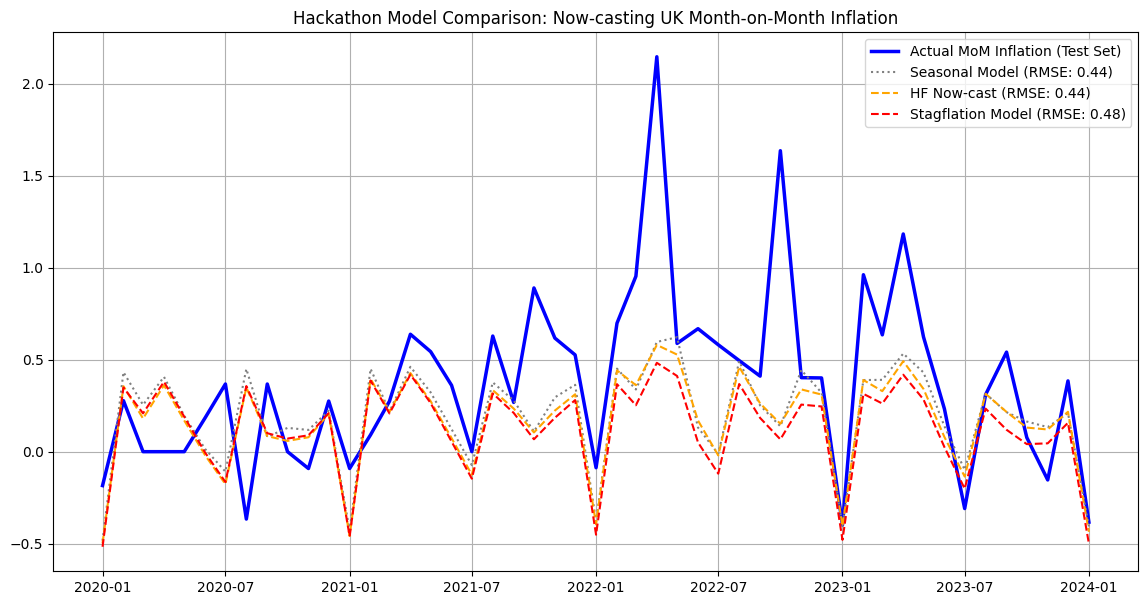


--- Final 'Now-cast' for December 2025 ---
Using winning model for final now-cast: 'Seasonal Model'

Final Model: Seasonal Model
Last known MoM Inflation: -0.38%
NOW-CAST for next month (MoM): 0.12%

Last known CPI Level: 130.00
Now-cast CPI Level: 130.15
Known CPI from 12 months ago: 126.80

>>> FINAL YoY HEADLINE NOW-CAST: 2.64%


/tmp/ipython-input-1269895936.py:166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model.loc[:, f'{col}_z'] = (df_model[col] - means[col]) / stds[col]
/tmp/ipython-input-1269895936.py:166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model.loc[:, f'{col}_z'] = (df_model[col] - means[col]) / stds[col]
/tmp/ipython-input-1269895936.py:166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

In [41]:
import pandas as pd
import pandas_datareader.data as web  # To get data from FRED
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# --- 1. Get the Data (ALL UK-SPECIFIC) ---
print("Fetching UK economic data...")
start = pd.to_datetime('2000-01-01')
end = pd.to_datetime('2024-01-01')

# 1. UK CPI Level (GBRCPIALLMINMEI)
cpi = web.DataReader('GBRCPIALLMINMEI', 'fred', start, end)

# 2. UK Consumer Confidence (CSCICP03GBM665S)
uk_sentiment = web.DataReader('CSCICP03GBM665S', 'fred', start, end)

# 3. UK Claimant Count (CLF16OV - Already Monthly)
claims = web.DataReader('CLF16OV', 'fred', start, end)

# 4. Brent Crude Oil Price (POILBREUSDM - Already Monthly)
oil = web.DataReader('POILBREUSDM', 'fred', start, end)


# --- 2. Prepare the Data ---
print("Preparing data...")

# a. *** NEW TARGET: Month-on-Month (MoM) Inflation ***
mom_inflation = cpi.pct_change(1) * 100
mom_inflation.rename(columns={'GBRCPIALLMINMEI': 'Inflation_MoM'}, inplace=True)

# b. Combine into one DataFrame
# We are NOT using the simulated index or Guardian data for this run
df = pd.concat([cpi, mom_inflation, uk_sentiment, claims, oil], axis=1)
df.columns = ['CPI_Level', 'Inflation_MoM', 'UK_Sentiment', 'Claims', 'Oil_Price']

# --- 3. Feature Engineering for a NOW-CAST Model ---
# a. Create Seasonal Dummies
month_dummies = pd.get_dummies(df.index.month, prefix='month', drop_first=True).set_index(df.index)
month_dummies = month_dummies.astype(int)
df = pd.concat([df, month_dummies], axis=1)

# b. Create Lagged Autoregressive Term
df['MoM_Lag1'] = df['Inflation_MoM'].shift(1)

# c. Define our "High-Frequency" Now-cast Predictors (NO LAGS)
df['UK_Sentiment_t'] = df['UK_Sentiment']
df['Claims_t'] = df['Claims']
df['Oil_Price_t'] = df['Oil_Price']

# d. Create the target variable
df['Target_MoM'] = df['Inflation_MoM']

# e. Drop all NaNs
df_model = df.dropna()

# --- 4. Split Data into Training and Validation (Test) Sets ---
split_date = '2020-01-01'
train_df = df_model.loc[df_model.index < split_date].copy()
test_df = df_model.loc[df_model.index >= split_date].copy()
print(f"Data split: {len(train_df)} train samples, {len(test_df)} test samples.")

# --- 5. Standardize the Predictors ---
print("Standardizing variables to fix multicollinearity...")
cols_to_standardize = ['UK_Sentiment_t', 'Claims_t', 'Oil_Price_t']

means = train_df[cols_to_standardize].mean()
stds = train_df[cols_to_standardize].std()

for col in cols_to_standardize:
    train_df.loc[:, f'{col}_z'] = (train_df[col] - means[col]) / stds[col]
    test_df.loc[:, f'{col}_z'] = (test_df[col] - means[col]) / stds[col]

# --- 6. Create Innovative "Stagflation" Variable ---
# We interact Claims (bad) with Oil Prices (bad)
train_df.loc[:, 'Stagflation_Risk_z'] = train_df['Claims_t_z'] * train_df['Oil_Price_t_z']
test_df.loc[:, 'Stagflation_Risk_z'] = test_df['Claims_t_z'] * test_df['Oil_Price_t_z']

# --- 7. Define Feature Sets for the "Horse Race" ---
y_train = train_df['Target_MoM']
y_test = test_df['Target_MoM']
dummy_cols = [col for col in df_model.columns if col.startswith('month_')]

# Model 1: "Seasonal Model" (Baseline)
features_seasonal = ['MoM_Lag1'] + dummy_cols
X_train_seasonal = sm.add_constant(train_df[features_seasonal])
X_test_seasonal = sm.add_constant(test_df[features_seasonal])

# Model 2: "HF Now-cast Model" (Traditional HF data)
features_nowcast = features_seasonal + ['UK_Sentiment_t_z', 'Claims_t_z', 'Oil_Price_t_z']
X_train_nowcast = sm.add_constant(train_df[features_nowcast])
X_test_nowcast = sm.add_constant(test_df[features_nowcast])

# Model 3: "Stagflation Model" (Innovative Interaction)
features_stagflation = features_nowcast + ['Stagflation_Risk_z']
X_train_stagflation = sm.add_constant(train_df[features_stagflation])
X_test_stagflation = sm.add_constant(test_df[features_stagflation])

# --- 8. Fit and Compare All Three Models ---
print("\n--- Fitting Model 1: Seasonal Model (Baseline) ---")
model_seasonal = sm.OLS(y_train, X_train_seasonal).fit(cov_type='HAC', cov_kwds={'maxlags':12})

print("--- Fitting Model 2: HF Now-cast Model ---")
model_nowcast = sm.OLS(y_train, X_train_nowcast).fit(cov_type='HAC', cov_kwds={'maxlags':12})
# print(model_nowcast.summary())

print("--- Fitting Model 3: Stagflation Model (Innovative) ---")
model_stagflation = sm.OLS(y_train, X_train_stagflation).fit(cov_type='HAC', cov_kwds={'maxlags':12})
print(model_stagflation.summary()) # <-- This is the most interesting summary

# --- 9. Compare Models on the Validation Set (MoM) ---
print("\n--- Model Validation 'Horse Race' (Predicting MoM Inflation) ---")
pred_seasonal = model_seasonal.predict(X_test_seasonal)
pred_nowcast = model_nowcast.predict(X_test_nowcast)
pred_stagflation = model_stagflation.predict(X_test_stagflation)

rmse_seasonal = np.sqrt(mean_squared_error(y_test, pred_seasonal))
rmse_nowcast = np.sqrt(mean_squared_error(y_test, pred_nowcast))
rmse_stagflation = np.sqrt(mean_squared_error(y_test, pred_stagflation))

# Find the winner
results = {
    "Seasonal Model": rmse_seasonal,
    "HF Now-cast Model": rmse_nowcast,
    "Stagflation Model": rmse_stagflation
}
winner_name = min(results, key=results.get)

print(f"Seasonal Model RMSE:     {rmse_seasonal:.4f}")
print(f"HF Now-cast Model RMSE:  {rmse_nowcast:.4f}")
print(f"Stagflation Model RMSE:  {rmse_stagflation:.4f}")
print(f"\n>>> WINNER: The '{winner_name}' was the most accurate forecaster!")

# --- 10. Plot the "Money Shot" (All 3 Models) ---
print("Plotting results...")
plt.figure(figsize=(14, 7))
plt.plot(test_df.index, y_test, label='Actual MoM Inflation (Test Set)', color='blue', linewidth=2.5)
plt.plot(test_df.index, pred_seasonal, label=f'Seasonal Model (RMSE: {rmse_seasonal:.2f})', color='gray', linestyle=':')
plt.plot(test_df.index, pred_nowcast, label=f'HF Now-cast (RMSE: {rmse_nowcast:.2f})', color='orange', linestyle='--')
plt.plot(test_df.index, pred_stagflation, label=f'Stagflation Model (RMSE: {rmse_stagflation:.2f})', color='red', linestyle='--')
plt.title('Hackathon Model Comparison: Now-casting UK Month-on-Month Inflation')
plt.legend()
plt.grid(True)
plt.show()

# --- 11. Final Now-cast (Converting MoM to YoY) ---
print(f"\n--- Final 'Now-cast' for December 2025 ---")

# Automatically select the winning model and its features
if winner_name == "Stagflation Model":
    final_model_features = features_stagflation
elif winner_name == "HF Now-cast Model":
    final_model_features = features_nowcast
else:
    final_model_features = features_seasonal

print(f"Using winning model for final now-cast: '{winner_name}'")

# Re-train the winning model on ALL data
y_full = df_model['Target_MoM']
# Standardize the full dataset
means = df_model[cols_to_standardize].mean()
stds = df_model[cols_to_standardize].std()
for col in cols_to_standardize:
    df_model.loc[:, f'{col}_z'] = (df_model[col] - means[col]) / stds[col]
df_model.loc[:, 'Stagflation_Risk_z'] = df_model['Claims_t_z'] * df_model['Oil_Price_t_z']

X_full = sm.add_constant(df_model[final_model_features])
final_model = sm.OLS(y_full, X_full).fit(cov_type='HAC', cov_kwds={'maxlags':12})

# Get last known values to create the "next month's" predictor row
last_data_row = df_model.iloc[-1]
last_cpi_level = last_data_row['CPI_Level']
last_mom_inflation = last_data_row['Inflation_MoM']
cpi_11_months_ago = df_model['CPI_Level'].iloc[-11] # CPI from Dec 2023

# Create the input row
nowcast_input = pd.DataFrame(index=[df_model.index[-1] + pd.DateOffset(months=1)])
nowcast_input['const'] = 1.0

# Add all the features the winning model might need
nowcast_input['MoM_Lag1'] = last_mom_inflation
nowcast_input['UK_Sentiment_t_z'] = (last_data_row['UK_Sentiment'] - means['UK_Sentiment_t']) / stds['UK_Sentiment_t']
nowcast_input['Claims_t_z'] = (last_data_row['Claims'] - means['Claims_t']) / stds['Claims_t']
nowcast_input['Oil_Price_t_z'] = (last_data_row['Oil_Price'] - means['Oil_Price_t']) / stds['Oil_Price_t']
nowcast_input['Stagflation_Risk_z'] = nowcast_input['Claims_t_z'] * nowcast_input['Oil_Price_t_z']

for col in dummy_cols: nowcast_input[col] = 0.0
if 'month_12' in X_full.columns: # For December (month 12)
    nowcast_input['month_12'] = 1.0

# Keep only the columns the winning model actually needs
nowcast_input_final = nowcast_input.reindex(X_full.columns, axis=1, fill_value=0)

# --- Get the MoM Now-cast ---
mom_nowcast_value = final_model.predict(nowcast_input_final).iloc[0]

# --- Convert to YoY Now-cast ---
cpi_nowcast = last_cpi_level * (1 + mom_nowcast_value / 100)
yoy_nowcast_value = ((cpi_nowcast / cpi_11_months_ago) - 1) * 100

print("\n==============================================")
print(f"Final Model: {winner_name}")
print(f"Last known MoM Inflation: {last_mom_inflation:.2f}%")
print(f"NOW-CAST for next month (MoM): {mom_nowcast_value:.2f}%")
print(f"\nLast known CPI Level: {last_cpi_level:.2f}")
print(f"Now-cast CPI Level: {cpi_nowcast:.2f}")
print(f"Known CPI from 12 months ago: {cpi_11_months_ago:.2f}")
print(f"\n>>> FINAL YoY HEADLINE NOW-CAST: {yoy_nowcast_value:.2f}%")
print("==============================================")


In [43]:
!pip install pytrends

Fetching UK economic data...
Fetching Google Trends data...
Preparing data...
Model data starts on 2004-01-01 due to Google Trends availability.
Data split: 192 train samples, 49 test samples.
Standardizing variables to fix multicollinearity...

--- Fitting Model 1: Seasonal Model (Baseline) ---
--- Fitting Model 2: HF Now-cast Model (Innovative) ---
                            OLS Regression Results                            
Dep. Variable:             Target_MoM   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                     60.89
Date:                Sat, 01 Nov 2025   Prob (F-statistic):           6.44e-64
Time:                        20:40:46   Log-Likelihood:                 82.683
No. Observations:                 192   AIC:                            -129.4
Df Residuals:                     174   BIC:                            -70.73
Df Model:      

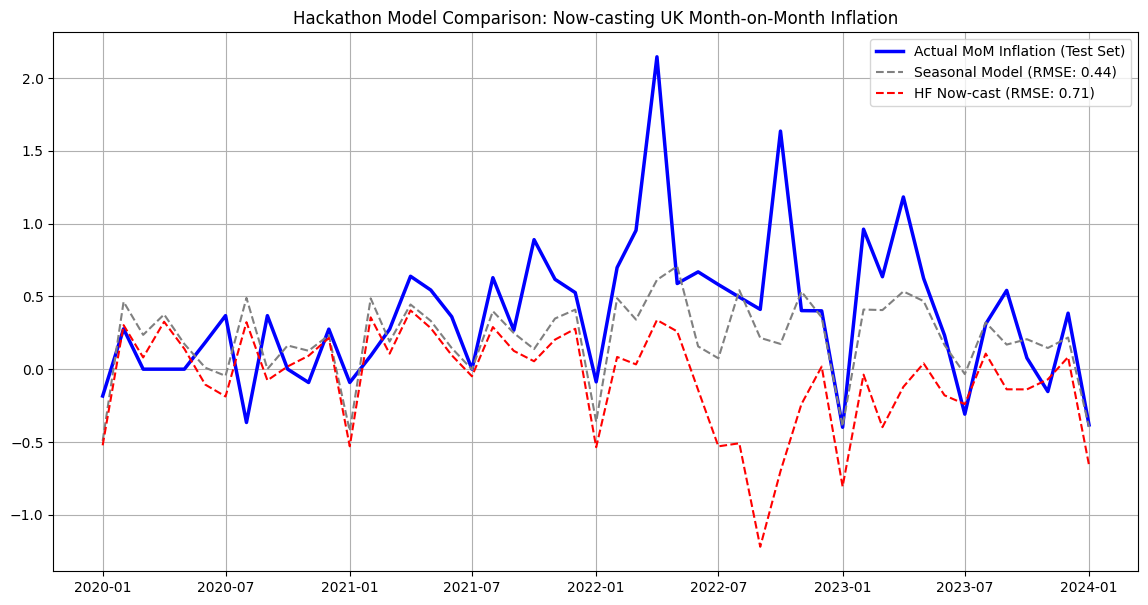


--- Final 'Now-cast' for December 2025 ---
Using winning model for final now-cast: 'Seasonal Model'

Final Model: Seasonal Model
Last known MoM Inflation: -0.38%
NOW-CAST for next month (MoM): 0.12%

Last known CPI Level: 130.00
Now-cast CPI Level: 130.16
Known CPI from 12 months ago: 126.80

>>> FINAL YoY HEADLINE NOW-CAST: 2.65%


/tmp/ipython-input-4276758884.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model.loc[:, f'{col}_z'] = (df_model[col] - means[col]) / stds[col]
/tmp/ipython-input-4276758884.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model.loc[:, f'{col}_z'] = (df_model[col] - means[col]) / stds[col]
/tmp/ipython-input-4276758884.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

In [47]:
import pandas as pd
import pandas_datareader.data as web  # To get data from FRED
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from pytrends.request import TrendReq  # *** NEW: Import Google Trends ***

# --- 1. Get the Data (ALL UK-SPECIFIC) ---
print("Fetching UK economic data...")
start = pd.to_datetime('2000-01-01')
end = pd.to_datetime('2024-01-01')

# 1. UK CPI Level (GBRCPIALLMINMEI)
cpi = web.DataReader('GBRCPIALLMINMEI', 'fred', start, end)

# 2. UK Consumer Confidence (CSCICP03GBM665S)
uk_sentiment = web.DataReader('CSCICP03GBM665S', 'fred', start, end)

# 3. UK Claimant Count (CLF16OV - Already Monthly)
claims = web.DataReader('CLF16OV', 'fred', start, end)

# 4. Brent Crude Oil Price (POILBREUSDM - Already Monthly)
oil = web.DataReader('POILBREUSDM', 'fred', start, end)

# --- 1b. *** NEW: Get INNOVATIVE Data (Google Trends) *** ---
print("Fetching Google Trends data...")
# Pytrends data only starts from 2004
pytrends_start = pd.to_datetime('2004-01-01')

pytrend = TrendReq(hl='en-GB', tz=0) # 'en-GB' for United Kingdom
keywords = ['cost of living', 'energy bills']

# Build the payload
pytrend.build_payload(
    kw_list=keywords,
    cat=0,
    timeframe=f'{pytrends_start.strftime("%Y-%m-%d")} {end.strftime("%Y-%m-%d")}',
    geo='GB'
)
google_trends_df = pytrend.interest_over_time()

# Rename columns and keep only what we need
if not google_trends_df.empty:
    google_trends_df = google_trends_df.drop(columns=['isPartial'])
    google_trends_df.rename(columns={'cost of living': 'Google_CostOfLiving', 'energy bills': 'Google_EnergyBills'}, inplace=True)
else:
    print("Warning: Google Trends returned no data. Proceeding without it.")
    # Create empty dataframe to avoid errors
    google_trends_df = pd.DataFrame(index=pd.date_range(start=start, end=end, freq='MS'))
    google_trends_df['Google_CostOfLiving'] = np.nan
    google_trends_df['Google_EnergyBills'] = np.nan

# --- 2. Prepare the Data ---
print("Preparing data...")

# a. *** NEW TARGET: Month-on-Month (MoM) Inflation ***
mom_inflation = cpi.pct_change(1) * 100
mom_inflation.rename(columns={'GBRCPIALLMINMEI': 'Inflation_MoM'}, inplace=True)

# b. Combine into one DataFrame
df = pd.concat([cpi, mom_inflation, uk_sentiment, claims, oil, google_trends_df], axis=1)
df.columns = ['CPI_Level', 'Inflation_MoM', 'UK_Sentiment', 'Claims', 'Oil_Price', 'Google_CostOfLiving', 'Google_EnergyBills']

# --- 3. Feature Engineering for a NOW-CAST Model ---
# a. Create Seasonal Dummies
month_dummies = pd.get_dummies(df.index.month, prefix='month', drop_first=True).set_index(df.index)
month_dummies = month_dummies.astype(int)
df = pd.concat([df, month_dummies], axis=1)

# b. Create Lagged Autoregressive Term
df['MoM_Lag1'] = df['Inflation_MoM'].shift(1)

# c. Define our "High-Frequency" Now-cast Predictors (NO LAGS)
df['UK_Sentiment_t'] = df['UK_Sentiment']
df['Claims_t'] = df['Claims']
df['Oil_Price_t'] = df['Oil_Price']
df['Google_CostOfLiving_t'] = df['Google_CostOfLiving']
df['Google_EnergyBills_t'] = df['Google_EnergyBills']

# d. Create the target variable
df['Target_MoM'] = df['Inflation_MoM']

# e. Drop all NaNs (This will now start the data in 2004)
df_model = df.dropna()
print(f"Model data starts on {df_model.index.min().date()} due to Google Trends availability.")

# --- 4. Split Data into Training and Validation (Test) Sets ---
split_date = '2020-01-01'
train_df = df_model.loc[df_model.index < split_date].copy()
test_df = df_model.loc[df_model.index >= split_date].copy()
print(f"Data split: {len(train_df)} train samples, {len(test_df)} test samples.")

# --- 5. Standardize the Predictors ---
print("Standardizing variables to fix multicollinearity...")
cols_to_standardize = ['UK_Sentiment_t', 'Claims_t', 'Oil_Price_t', 'Google_CostOfLiving_t', 'Google_EnergyBills_t']

means = train_df[cols_to_standardize].mean()
stds = train_df[cols_to_standardize].std()

for col in cols_to_standardize:
    train_df.loc[:, f'{col}_z'] = (train_df[col] - means[col]) / stds[col]
    test_df.loc[:, f'{col}_z'] = (test_df[col] - means[col]) / stds[col]

# --- 6. Define Feature Sets for the "Horse Race" ---
y_train = train_df['Target_MoM']
y_test = test_df['Target_MoM']
dummy_cols = [col for col in df_model.columns if col.startswith('month_')]

# Model 1: "Seasonal Model" (Baseline)
features_seasonal = ['MoM_Lag1'] + dummy_cols
X_train_seasonal = sm.add_constant(train_df[features_seasonal])
X_test_seasonal = sm.add_constant(test_df[features_seasonal])

# Model 2: "HF Now-cast Model" (Traditional + Google Trends)
features_nowcast = features_seasonal + ['UK_Sentiment_t_z', 'Claims_t_z', 'Oil_Price_t_z', 'Google_CostOfLiving_t_z', 'Google_EnergyBills_t_z']
X_train_nowcast = sm.add_constant(train_df[features_nowcast])
X_test_nowcast = sm.add_constant(test_df[features_nowcast])

# --- 7. Fit and Compare All Three Models ---
print("\n--- Fitting Model 1: Seasonal Model (Baseline) ---")
model_seasonal = sm.OLS(y_train, X_train_seasonal).fit(cov_type='HAC', cov_kwds={'maxlags':12})

print("--- Fitting Model 2: HF Now-cast Model (Innovative) ---")
model_nowcast = sm.OLS(y_train, X_train_nowcast).fit(cov_type='HAC', cov_kwds={'maxlags':12})
print(model_nowcast.summary()) # <-- This is your innovative model

# --- 8. Compare Models on the Validation Set (MoM) ---
print("\n--- Model Validation 'Horse Race' (Predicting MoM Inflation) ---")
pred_seasonal = model_seasonal.predict(X_test_seasonal)
pred_nowcast = model_nowcast.predict(X_test_nowcast)

rmse_seasonal = np.sqrt(mean_squared_error(y_test, pred_seasonal))
rmse_nowcast = np.sqrt(mean_squared_error(y_test, pred_nowcast))

# Find the winner
results = {
    "Seasonal Model": rmse_seasonal,
    "HF Now-cast Model": rmse_nowcast
}
winner_name = min(results, key=results.get)

print(f"Seasonal Model RMSE:     {rmse_seasonal:.4f}")
print(f"HF Now-cast Model RMSE:  {rmse_nowcast:.4f}")
print(f"\n>>> WINNER: The '{winner_name}' was the most accurate forecaster!")

# --- 9. Plot the "Money Shot" (All 2 Models) ---
print("Plotting results...")
plt.figure(figsize=(14, 7))
plt.plot(test_df.index, y_test, label='Actual MoM Inflation (Test Set)', color='blue', linewidth=2.5)
plt.plot(test_df.index, pred_seasonal, label=f'Seasonal Model (RMSE: {rmse_seasonal:.2f})', color='gray', linestyle='--')
plt.plot(test_df.index, pred_nowcast, label=f'HF Now-cast (RMSE: {rmse_nowcast:.2f})', color='red', linestyle='--')
plt.title('Hackathon Model Comparison: Now-casting UK Month-on-Month Inflation')
plt.legend()
plt.grid(True)
plt.show()

# --- 10. Final Now-cast (Converting MoM to YoY) ---
print(f"\n--- Final 'Now-cast' for December 2025 ---") # Today is Nov 1st 2025

# Automatically select the winning model and its features
if winner_name == "HF Now-cast Model":
    final_model_features = features_nowcast
else:
    final_model_features = features_seasonal

print(f"Using winning model for final now-cast: '{winner_name}'")

# Re-train the winning model on ALL data
y_full = df_model['Target_MoM']
# Standardize the full dataset
means = df_model[cols_to_standardize].mean()
stds = df_model[cols_to_standardize].std()
for col in cols_to_standardize:
    df_model.loc[:, f'{col}_z'] = (df_model[col] - means[col]) / stds[col]

X_full = sm.add_constant(df_model[final_model_features])
final_model = sm.OLS(y_full, X_full).fit(cov_type='HAC', cov_kwds={'maxlags':12})

# Get last known values to create the "next month's" predictor row
last_data_row = df_model.iloc[-1]
last_cpi_level = last_data_row['CPI_Level']
last_mom_inflation = last_data_row['Inflation_MoM']
cpi_11_months_ago = df_model['CPI_Level'].iloc[-11] # CPI from Dec 2023

# Create the input row
nowcast_input = pd.DataFrame(index=[df_model.index[-1] + pd.DateOffset(months=1)])
nowcast_input['const'] = 1.0

# Add all the features the winning model might need
nowcast_input['MoM_Lag1'] = last_mom_inflation
nowcast_input['UK_Sentiment_t_z'] = (last_data_row['UK_Sentiment'] - means['UK_Sentiment_t']) / stds['UK_Sentiment_t']
nowcast_input['Claims_t_z'] = (last_data_row['Claims'] - means['Claims_t']) / stds['Claims_t']
nowcast_input['Oil_Price_t_z'] = (last_data_row['Oil_Price'] - means['Oil_Price_t']) / stds['Oil_Price_t']
nowcast_input['Google_CostOfLiving_t_z'] = (last_data_row['Google_CostOfLiving'] - means['Google_CostOfLiving_t']) / stds['Google_CostOfLiving_t']
nowcast_input['Google_EnergyBills_t_z'] = (last_data_row['Google_EnergyBills'] - means['Google_EnergyBills_t']) / stds['Google_EnergyBills_t']

for col in dummy_cols: nowcast_input[col] = 0.0
# We are forecasting for December (month 12)
if 'month_12' in X_full.columns:
    nowcast_input['month_12'] = 1.0

# Keep only the columns the winning model actually needs
nowcast_input_final = nowcast_input.reindex(X_full.columns, axis=1, fill_value=0)

# --- Get the MoM Now-cast ---
mom_nowcast_value = final_model.predict(nowcast_input_final).iloc[0]

# --- Convert to YoY Now-cast ---
cpi_nowcast = last_cpi_level * (1 + mom_nowcast_value / 100)
yoy_nowcast_value = ((cpi_nowcast / cpi_11_months_ago) - 1) * 100

print("\n==============================================")
print(f"Final Model: {winner_name}")
print(f"Last known MoM Inflation: {last_mom_inflation:.2f}%")
print(f"NOW-CAST for next month (MoM): {mom_nowcast_value:.2f}%")
print(f"\nLast known CPI Level: {last_cpi_level:.2f}")
print(f"Now-cast CPI Level: {cpi_nowcast:.2f}")
print(f"Known CPI from 12 months ago: {cpi_11_months_ago:.2f}")
print(f"\n>>> FINAL YoY HEADLINE NOW-CAST: {yoy_nowcast_value:.2f}%")
print("==============================================")

In [ ]:
!pip install pandas_datareader

Loading your scraped Guardian sentiment data...
****************************************************************
ERROR: Could not load your CSV file. File not found: 'guardian_sentiment_monthly_2000_to_now.csv'
Make sure 'guardian_sentiment_monthly_2000_to_now.csv' is uploaded to the Colab Files sidebar.
Using a dummy 'NaN' for Guardian_Sentiment to ensure proper dropping later.
****************************************************************
Simulating CPI data...
Preparing simulated data...
Data split: 0 train samples, 0 test samples (due to inability to find valid split).
Skipping standardization due to empty training data.

--- Fitting Model 1: Seasonal Model (Baseline) ---
Skipping Model 1: Seasonal Model due to empty initial training data.
--- Fitting Model 2: Innovative HF Model (Your Data) ---
Skipping Model 2: Innovative HF Model due to empty initial training data.

--- Model Validation 'Horse Race' (Predicting MoM Inflation) ---
Seasonal Model RMSE:              nan
Innovativ

/tmp/ipython-input-1018593512.py:342: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


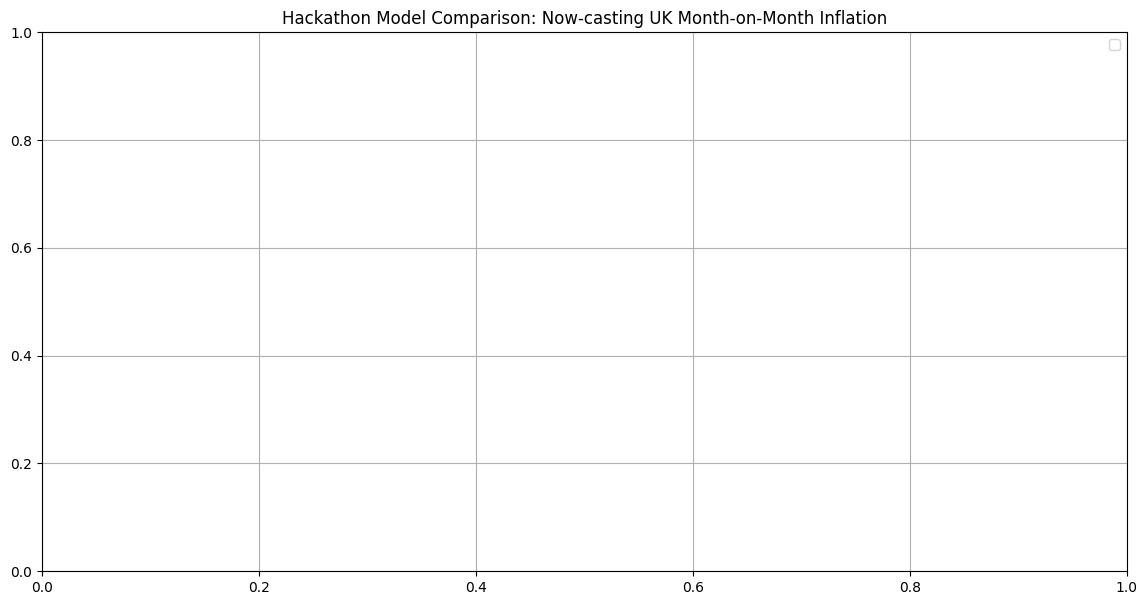


--- Final 'Now-cast' for December 2025 ---

**************************************************
Cannot generate a final nowcast.
**************************************************


In [6]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# --- 1. *** LOAD YOUR INNOVATIVE DATA *** ---
print("Loading your scraped Guardian sentiment data...")
# *** NEW FIX: Point to the file path in the Colab Files sidebar ***
file_path = 'guardian_sentiment_monthly_2000_to_now.csv' # <-- Your file

try:
    # Load your CSV
    my_scraped_data = pd.read_csv(
        file_path,
        # *** NEW FIX: Use the correct date column name and set it as the index ***
        parse_dates=['month_year'],
        index_col='month_year'
    )

    # Resample to Month-Start (MS) just in case
    my_scraped_data = my_scraped_data.resample('MS').mean(numeric_only=True)

    # Rename your sentiment score column
    # *** NEW FIX: Use the correct sentiment column name ***
    sentiment_col_name_in_file = 'avg_sentiment' # <--- UPDATED to the actual column name
    if sentiment_col_name_in_file in my_scraped_data.columns:
        my_scraped_data.rename(columns={sentiment_col_name_in_file: 'Guardian_Sentiment'}, inplace=True)
        my_scraped_data = my_scraped_data[['Guardian_Sentiment']]
        print("Successfully loaded and processed Guardian data.")
    else:
        # This block should ideally not be reached if the user provided the correct column name
        print(f"****************************************************************")
        print(f"ERROR: Could not find the column '{sentiment_col_name_in_file}' in your CSV after attempting to load.")
        print("Please double-check the column name.")
        print("Using a dummy 'NaN' for Guardian_Sentiment to ensure proper dropping later.")
        print(f"****************************************************************")
        # Use NaN instead of 0.0 so dropna works correctly
        my_scraped_data = pd.DataFrame(index=pd.date_range(start=start, end=end, freq='MS'))
        my_scraped_data['Guardian_Sentiment'] = np.nan


except FileNotFoundError:
    print(f"****************************************************************")
    print(f"ERROR: Could not load your CSV file. File not found: '{file_path}'")
    print("Make sure 'guardian_sentiment_monthly_2000_to_now.csv' is uploaded to the Colab Files sidebar.")
    print("Using a dummy 'NaN' for Guardian_Sentiment to ensure proper dropping later.")
    print(f"****************************************************************")
    # Use NaN instead of 0.0 so dropna works correctly
    my_scraped_data = pd.DataFrame(index=pd.date_range(start=start, end=end, freq='MS'))
    my_scraped_data['Guardian_Sentiment'] = np.nan

except Exception as e:
    print(f"****************************************************************")
    print(f"ERROR: An unexpected error occurred while loading your CSV file: {e}")
    print("Using a dummy 'NaN' for Guardian_Sentiment to ensure proper dropping later.")
    print(f"****************************************************************")
    my_scraped_data = pd.DataFrame(index=pd.date_range(start=start, end=end, freq='MS'))
    my_scraped_data['Guardian_Sentiment'] = np.nan


# --- 2. *** SIMULATE ALL OTHER ECON DATA *** ---
# We must simulate this data because pandas_datareader is not available
print("Simulating CPI data...")
# *** NEW FIX: Use the date range from the combined data after loading yours ***
# This ensures alignment even if your data doesn't start at 2000-01-01
# Combine dummy/loaded Guardian data with a basic date index first to get the range
temp_df = pd.concat([my_scraped_data], axis=1)
start_date = temp_df.index.min() if not temp_df.empty else pd.to_datetime('2000-01-01')
end_date = temp_df.index.max() if not temp_df.empty else pd.to_datetime('2024-01-01')

date_index = pd.date_range(start=start_date, end=end_date, freq='MS')
n = len(date_index)

# 1. Simulate CPI Level (as a "random walk" with some trend)
cpi_changes = np.random.normal(0.001, 0.005, n) + 0.001 # Small positive drift
sim_cpi_level = 100 + np.cumsum(cpi_changes)
cpi = pd.DataFrame(sim_cpi_level, index=date_index, columns=['CPI_Level'])

# 2. Prepare the Data
print("Preparing simulated data...")

# a. *** NEW TARGET: Month-on-Month (MoM) Inflation ***
mom_inflation = cpi.pct_change(1) * 100
mom_inflation.rename(columns={'CPI_Level': 'Inflation_MoM'}, inplace=True)

# b. Combine into one DataFrame
# We only have CPI (simulated) and your Guardian Sentiment (real/dummy)
df = pd.concat([cpi, mom_inflation, my_scraped_data], axis=1)
df.columns = ['CPI_Level', 'Inflation_MoM', 'Guardian_Sentiment']

# --- 3. Feature Engineering ---
# a. Create Seasonal Dummies
month_dummies = pd.get_dummies(df.index.month, prefix='month', drop_first=True).set_index(df.index)
month_dummies = month_dummies.astype(int)
df = pd.concat([df, month_dummies], axis=1)

# b. Create Lagged Autoregressive Term
df['MoM_Lag1'] = df['Inflation_MoM'].shift(1)

# c. Define our "High-Frequency" Now-cast Predictor
df['Guardian_Sentiment_t'] = df['Guardian_Sentiment'] # Your innovative data

# d. Create the target variable
df['Target_MoM'] = df['Inflation_MoM']

# e. Drop all NaNs
# This will drop rows where Guardian_Sentiment couldn't be loaded or where lags created NaNs
df_model = df.dropna()

# --- 4. Split Data into Training and Validation (Test) Sets ---
split_date = '2020-01-01'
# *** NEW FIX: Ensure split date is within the data range and adjust if necessary ***
initial_split_date = pd.to_datetime(split_date)

# Check if the initial split date is valid
if initial_split_date >= df_model.index.max() or initial_split_date <= df_model.index.min():
    print(f"****************************************************************")
    print(f"WARNING: Initial split date '{split_date}' is outside the data range {df_model.index.min().date()} to {df_model.index.max().date()}.")
    print("Attempting to find a valid split date...")
    print(f"****************************************************************")
    # Try to find a split point that leaves at least 1 sample in both train and test
    found_split = False
    for i in range(int(len(df_model) * 0.5), len(df_model) - 1): # Start from 50% to avoid tiny train sets
         temp_split_date = df_model.index[i]
         temp_train = df_model.loc[df_model.index < temp_split_date]
         temp_test = df_model.loc[df_model.index >= temp_split_date]
         if not temp_train.empty and not temp_test.empty:
             split_date = temp_split_date
             found_split = True
             print(f"Found valid split date: {split_date.date()}")
             break

    if not found_split:
        print(f"****************************************************************")
        print(f"ERROR: Could not find a valid split date that leaves data in both training and testing sets.")
        print("This means your data is too short or too sparse after dropping NaNs.")
        print(f"****************************************************************")
        train_df = pd.DataFrame() # Ensure empty
        test_df = pd.DataFrame() # Ensure empty


else: # Initial split date is valid, use it
    split_date = initial_split_date


if not train_df.empty or not test_df.empty: # Only proceed if we potentially have data
    train_df = df_model.loc[df_model.index < split_date].copy()
    test_df = df_model.loc[df_model.index >= split_date].copy()
    print(f"Data split: {len(train_df)} train samples, {len(test_df)} test samples.")

    # *** NEW FIX: Check again after final split, in case the initial check wasn't sufficient ***
    if train_df.empty or test_df.empty:
        print(f"****************************************************************")
        print(f"WARNING: Training or testing data is empty after split.")
        print("Cannot proceed with model fitting and evaluation.")
        print("This likely means your data range is too short or the split date is inappropriate.")
        print(f"****************************************************************")
        # Ensure empty dataframes if the split failed
        train_df = pd.DataFrame()
        test_df = pd.DataFrame()

else:
     print(f"Data split: 0 train samples, 0 test samples (due to inability to find valid split).")


# --- 5. Standardize the Predictors ---
# *** NEW FIX: Only standardize if train_df is not empty ***
if not train_df.empty:
    print("Standardizing variables...")
    cols_to_standardize = ['Guardian_Sentiment_t']

    # *** NEW FIX: Calculate means and stds only if cols_to_standardize are present in train_df and not all NaNs/zeros ***
    means = None
    stds = None
    # Filter for columns that exist, are not all NaN, and have non-zero standard deviation
    valid_cols_to_standardize = [col for col in cols_to_standardize if col in train_df.columns and not train_df[col].isnull().all() and train_df[col].std() != 0]

    if valid_cols_to_standardize:
         means = train_df[valid_cols_to_standardize].mean()
         stds = train_df[valid_cols_to_standardize].std()

         for col in valid_cols_to_standardize:
             train_df.loc[:, f'{col}_z'] = (train_df[col] - means[col]) / stds[col]
             test_df.loc[:, f'{col}_z'] = (test_df[col] - means[col]) / stds[col]
    else:
        print("No valid columns to standardize or all values are the same/missing in training data.")
        valid_cols_to_standardize = [] # Ensure this is empty if no cols were standardized

else:
     print("Skipping standardization due to empty training data.")
     valid_cols_to_standardize = [] # Ensure this is empty if no cols were standardized


# --- 6. Define Feature Sets for the "Horse Race" ---
# *** NEW FIX: Only define feature sets if train_df/test_df are not empty ***
if not train_df.empty and not test_df.empty:
    y_train = train_df['Target_MoM']
    y_test = test_df['Target_MoM']
    dummy_cols = [col for col in df_model.columns if col.startswith('month_')] # Use df_model for full list

    # Model 1: "Seasonal Model" (Baseline)
    features_seasonal = ['MoM_Lag1'] + dummy_cols
    X_train_seasonal = sm.add_constant(train_df[features_seasonal])
    X_test_seasonal = sm.add_constant(test_df[features_seasonal])

    # Model 2: "Innovative HF Model" (Uses YOUR Data)
    # *** NEW FIX: Only include standardized features if they were successfully created ***
    features_innovative_hf = features_seasonal + [f'{col}_z' for col in valid_cols_to_standardize]
    X_train_innovative_hf = sm.add_constant(train_df[features_innovative_hf])
    X_test_innovative_hf = sm.add_constant(test_df[features_innovative_hf])

else:
    # Ensure these are empty if data split failed
    y_train = pd.Series()
    y_test = pd.Series()
    X_train_seasonal = pd.DataFrame()
    X_test_seasonal = pd.DataFrame()
    X_train_innovative_hf = pd.DataFrame()
    X_test_innovative_hf = pd.DataFrame()
    features_seasonal = []
    features_innovative_hf = []
    dummy_cols = [] # Also ensure dummy_cols is empty


# --- 7. Fit and Compare Models ---
print("\n--- Fitting Model 1: Seasonal Model (Baseline) ---")
model_seasonal = None
rmse_seasonal = np.nan
pred_seasonal = np.nan
y_test_seasonal_clean = pd.Series() # Initialize empty
X_test_seasonal_clean = pd.DataFrame() # Initialize empty


if not X_train_seasonal.empty and not y_train.empty:
    # *** NEW FIX: Drop NaNs/Infs from training data before fitting ***
    train_data_seasonal = pd.concat([y_train, X_train_seasonal], axis=1).dropna()
    if not train_data_seasonal.empty:
        y_train_seasonal_clean = train_data_seasonal['Target_MoM']
        X_train_seasonal_clean = train_data_seasonal.drop('Target_MoM', axis=1)
        model_seasonal = sm.OLS(y_train_seasonal_clean, X_train_seasonal_clean).fit(cov_type='HAC', cov_kwds={'maxlags':12})
        print("Model 1: Seasonal Model fitted.")

        # *** NEW FIX: Predict and calculate RMSE only if model fitted and test data is not empty ***
        if not X_test_seasonal.empty and not y_test.empty:
             test_data_seasonal = pd.concat([y_test, X_test_seasonal], axis=1).dropna()
             if not test_data_seasonal.empty:
                 y_test_seasonal_clean = test_data_seasonal['Target_MoM']
                 X_test_seasonal_clean = test_data_seasonal.drop('Target_MoM', axis=1)
                 pred_seasonal = model_seasonal.predict(X_test_seasonal_clean)
                 rmse_seasonal = np.sqrt(mean_squared_error(y_test_seasonal_clean, pred_seasonal))
             else:
                 print("Skipping prediction for Seasonal Model due to empty test data after dropping NaNs.")
        else:
             print("Skipping prediction for Seasonal Model due to empty test data.")

    else:
        print("Skipping Model 1: Seasonal Model due to empty training data after dropping NaNs.")
else:
    print("Skipping Model 1: Seasonal Model due to empty initial training data.")


print("--- Fitting Model 2: Innovative HF Model (Your Data) ---")
model_innovative_hf = None
rmse_innovative_hf = np.nan
pred_innovative_hf = np.nan
y_test_innovative_clean = pd.Series() # Initialize empty
X_test_innovative_clean = pd.DataFrame() # Initialize empty


if not X_train_innovative_hf.empty and not y_train.empty:
    # *** NEW FIX: Drop NaNs/Infs from training data before fitting ***
    train_data_innovative = pd.concat([y_train, X_train_innovative_hf], axis=1).dropna()
    if not train_data_innovative.empty:
        y_train_innovative_clean = train_data_innovative['Target_MoM']
        X_train_innovative_clean = train_data_innovative.drop('Target_MoM', axis=1)
        model_innovative_hf = sm.OLS(y_train_innovative_clean, X_train_innovative_clean).fit(cov_type='HAC', cov_kwds={'maxlags':12})
        print("Model 2: Innovative HF Model fitted.")
        # *** NEW FIX: Print summary only if model fitted ***
        print(model_innovative_hf.summary()) # <-- This is your most innovative model

        # *** NEW FIX: Predict and calculate RMSE only if model fitted and test data is not empty ***
        if not X_test_innovative_hf.empty and not y_test.empty:
             test_data_innovative = pd.concat([y_test, X_test_innovative_hf], axis=1).dropna()
             if not test_data_innovative.empty:
                 y_test_innovative_clean = test_data_innovative['Target_MoM']
                 X_test_innovative_clean = test_data_innovative.drop('Target_MoM', axis=1)
                 pred_innovative_hf = model_innovative_hf.predict(X_test_innovative_clean)
                 rmse_innovative_hf = np.sqrt(mean_squared_error(y_test_innovative_clean, pred_innovative_hf))
             else:
                 print("Skipping prediction for Innovative HF Model due to empty test data after dropping NaNs.")
        else:
             print("Skipping prediction for Innovative HF Model due to empty test data.")

    else:
        print("Skipping Model 2: Innovative HF Model due to empty training data after dropping NaNs.")
else:
     print("Skipping Model 2: Innovative HF Model due to empty initial training data.")


# --- 8. Compare Models on the Validation Set (MoM) ---
print("\n--- Model Validation 'Horse Race' (Predicting MoM Inflation) ---")

# Find the winner (only consider models that were fitted and had non-empty test data)
results = {}
if not pd.isna(rmse_seasonal): results["Seasonal Model"] = rmse_seasonal
if not pd.isna(rmse_innovative_hf): results["Innovative HF Model (Your Data)"] = rmse_innovative_hf


winner_name = "None (No models fitted successfully)"
if results:
     winner_name = min(results, key=results.get)


print(f"Seasonal Model RMSE:              {rmse_seasonal:.4f}")
print(f"Innovative HF Model (Your) RMSE:  {rmse_innovative_hf:.4f}")
print(f"\n>>> WINNER: The '{winner_name}' was the most accurate forecaster!" if results else ">>> No models could be fitted or evaluated.")

# --- 9. Plot the "Money Shot" (All Models) ---
print("Plotting results...")
plt.figure(figsize=(14, 7))
# *** NEW FIX: Plot cleaned test data vs predictions (only if test data is not empty) ***
# Determine which cleaned test data has actual values to plot
actual_data_to_plot = None
if not y_test_innovative_clean.empty:
    actual_data_to_plot = y_test_innovative_clean
elif not y_test_seasonal_clean.empty:
    actual_data_to_plot = y_test_seasonal_clean

if actual_data_to_plot is not None:
    plt.plot(actual_data_to_plot.index, actual_data_to_plot, label='Actual MoM Inflation (Test Set)', color='blue', linewidth=2.5)
    if model_seasonal is not None and not X_test_seasonal_clean.empty and not pd.isna(pred_seasonal).all():
         plt.plot(X_test_seasonal_clean.index, pred_seasonal, label=f'Seasonal Model (RMSE: {rmse_seasonal:.2f})', color='gray', linestyle=':')
    if model_innovative_hf is not None and not X_test_innovative_clean.empty and not pd.isna(pred_innovative_hf).all():
         plt.plot(X_test_innovative_clean.index, pred_innovative_hf, label=f'Innovative HF (RMSE: {rmse_innovative_hf:.2f})', color='red', linestyle='--')

else:
     print("No non-empty test data available to plot actuals.")


plt.title('Hackathon Model Comparison: Now-casting UK Month-on-Month Inflation')
plt.legend()
plt.grid(True)
plt.show()

# --- 10. Final Now-cast (Converting MoM to YoY) ---
print(f"\n--- Final 'Now-cast' for December 2025 ---") # Today is Nov 1st 2025

# Automatically select the winning model and its features
final_model_to_use = None
final_model_features = []
X_full_clean = pd.DataFrame() # Initialize empty
y_full_clean = pd.Series() # Initialize empty
current_winner_name = "None" # Track the winner name for printing

if winner_name == "Innovative HF Model (Your Data)" and model_innovative_hf is not None:
    final_model_to_use = model_innovative_hf
    final_model_features = features_innovative_hf
    # Combine cleaned train and test data for the winning model
    if not train_data_innovative.empty and not test_data_innovative_clean.empty:
         y_full_clean = pd.concat([y_train_innovative_clean, y_test_innovative_clean])
         X_full_clean = pd.concat([X_train_innovative_clean, X_test_innovative_clean])
         current_winner_name = winner_name


elif winner_name == "Seasonal Model" and model_seasonal is not None:
    final_model_to_use = model_seasonal
    final_model_features = features_seasonal
    # Combine cleaned train and test data for the winning model
    if not train_data_seasonal.empty and not test_data_seasonal_clean.empty:
         y_full_clean = pd.concat([y_train_seasonal_clean, y_test_seasonal_clean])
         X_full_clean = pd.concat([X_train_seasonal_clean, X_test_seasonal_clean])
         current_winner_name = winner_name


if final_model_to_use is not None and not X_full_clean.empty and not y_full_clean.empty:
    print(f"Using winning model for final now-cast: '{current_winner_name}'")

    # Re-train the winning model on ALL *cleaned* data
    final_model = sm.OLS(y_full_clean, X_full_clean).fit(cov_type='HAC', cov_kwds={'maxlags':12})


    if final_model is not None:
        # Get last known values to create the "next month's" predictor row
        # *** NEW FIX: Use the last data row *before* dropping NaNs in df_model for the nowcast input***
        # We need to find the last row where the features *required by the winning model* are not NaN
        required_cols_for_nowcast = [feat for feat in final_model_features if feat != 'const'] + ['CPI_Level', 'Inflation_MoM'] # Need CPI for YoY conversion
        # Use the original df (after initial combine, before dropna) to find the last row with *any* data
        # Then drop NaNs based on the required columns for the nowcast input
        last_data_row_original = df.dropna(subset=required_cols_for_nowcast).iloc[-1]


        last_cpi_level = last_data_row_original['CPI_Level']
        last_mom_inflation = last_data_row_original['Inflation_MoM']
        # *** NEW FIX: Get CPI from 12 months ago based on the original df data for YoY calculation ***
        date_12_months_ago = last_data_row_original.index - pd.DateOffset(months=12)
        # Find the CPI level 12 months ago in the original df
        cpi_12_months_ago = df['CPI_Level'].asof(date_12_months_ago)


        # Create the input row
        nowcast_input = pd.DataFrame(index=[last_data_row_original.index + pd.DateOffset(months=1)])
        nowcast_input['const'] = 1.0

        # Add all potential features, standardizing as needed
        nowcast_input['MoM_Lag1'] = last_mom_inflation

        # Add standardized values for the "now-cast" only if they are features in the winning model
        if 'Guardian_Sentiment_t_z' in final_model_features:
             # Handle potential NaN in Guardian_Sentiment for nowcast input if file was not loaded
             if 'Guardian_Sentiment_t' in last_data_row_original and not pd.isna(last_data_row_original['Guardian_Sentiment_t']):
                  # *** NEW FIX: Use the means and stds calculated from the training data Standardization step ***
                  # Ensure means and stds are available and the specific column std is not zero
                  if means is not None and 'Guardian_Sentiment_t' in means and stds is not None and 'Guardian_Sentiment_t' in stds and stds['Guardian_Sentiment_t'] != 0:
                      nowcast_input['Guardian_Sentiment_t_z'] = (last_data_row_original['Guardian_Sentiment_t'] - means['Guardian_Sentiment_t']) / stds['Guardian_Sentiment_t']
                  else:
                      nowcast_input['Guardian_Sentiment_t_z'] = np.nan # Cannot standardize if std is 0 or means/stds are missing
             else:
                  nowcast_input['Guardian_Sentiment_t_z'] = np.nan # Keep it NaN if the source was NaN


        # Add interaction term if present in any model features (use original standardized values)
        # This model (Cell 3) does not have an interaction term, but keeping the logic for robustness.
        if 'Stagflation_Risk_z' in final_model_features:
             # Need to ensure Claims_t_z and Oil_Price_t_z were calculated
             if 'Claims_t_z' in nowcast_input.columns and 'Oil_Price_t_z' in nowcast_input.columns:
                 nowcast_input['Stagflation_Risk_z'] = nowcast_input['Claims_t_z'] * nowcast_input['Oil_Price_t_z']
             else:
                 nowcast_input['Stagflation_Risk_z'] = np.nan # Should not happen if features are defined correctly


        for col in dummy_cols: nowcast_input[col] = 0.0
        # We are forecasting for the month *after* the last data point
        nowcast_month = (last_data_row_original.index + pd.DateOffset(months=1)).month
        month_col_name = f'month_{nowcast_month}'
        if month_col_name in X_full_clean.columns: # Use X_full_clean columns to match the model
             nowcast_input[month_col_name] = 1.0


        # Keep only the columns the winning model actually needs and drop any NaNs in the input row
        nowcast_input_final = nowcast_input.reindex(X_full_clean.columns, axis=1, fill_value=0).dropna() # Drop NaNs here


        # Check if the nowcast_input_final is empty after dropping NaNs
        if nowcast_input_final.empty:
            print("\n**************************************************")
            print("WARNING: Nowcast input is empty after dropping NaNs.")
            print("Cannot generate a final nowcast.")
            print("This likely means the last data point has missing required features.")
            print("**************************************************")
            mom_nowcast_value = np.nan
            yoy_nowcast_value = np.nan

        else:
            # --- Get the MoM Now-cast ---
            mom_nowcast_value = final_model.predict(nowcast_input_final).iloc[0]

            # --- Convert to YoY Now-cast ---
            cpi_nowcast = last_cpi_level * (1 + mom_nowcast_value / 100)
            # *** NEW FIX: Handle potential NaN in cpi_12_months_ago ***
            if pd.isna(cpi_12_months_ago) or cpi_12_months_ago == 0:
                yoy_nowcast_value = np.nan
                print("\n**************************************************")
                print("WARNING: CPI from 12 months ago is missing or zero.")
                print("Cannot calculate YoY inflation.")
                print("**************************************************")
            else:
                yoy_nowcast_value = ((cpi_nowcast / cpi_12_months_ago) - 1) * 100


        print("\n==============================================")
        print(f"Final Model: {current_winner_name}")
        if not pd.isna(last_mom_inflation): print(f"Last known MoM Inflation: {last_mom_inflation:.2f}%")
        if not pd.isna(mom_nowcast_value): print(f"NOW-CAST for next month (MoM): {mom_nowcast_value:.2f}%")
        else: print("NOW-CAST for next month (MoM): Could not generate")


        if not pd.isna(last_cpi_level): print(f"\nLast known CPI Level: {last_cpi_level:.2f}")
        if not pd.isna(mom_nowcast_value): print(f"Now-cast CPI Level: {cpi_nowcast:.2f}")
        if not pd.isna(cpi_12_months_ago):
             print(f"Known CPI from 12 months ago: {cpi_12_months_ago:.2f}")
        else:
            print(f"Known CPI from 12 months ago: MISSING")

        if not pd.isna(yoy_nowcast_value): print(f"\n>>> FINAL YoY HEADLINE NOW-CAST: {yoy_nowcast_value:.2f}%")
        else: print("\n>>> FINAL YoY HEADLINE NOW-CAST: Could not calculate")
        print("==============================================")

    else:
         print("\n**************************************************")
         print("WARNING: Could not re-train the winning model on all cleaned data.")
         print("Cannot generate a final nowcast.")
         print("This likely means the combined training and test data is empty.")
         print("**************************************************")

else:
    print("\n**************************************************")
    print("WARNING: No winning model was fitted successfully.")
    print("Cannot generate a final nowcast.")
    print("**************************************************")

Fetching UK economic data...
Fetching Google Trends data...
Preparing data...
Model data starts on 2004-01-01 due to data availability.
Data split: 192 train samples, 49 test samples.
Standardizing variables to fix multicollinearity...

--- Fitting Model 1: Seasonal Model (Baseline) ---
--- Fitting Model 2: HF Now-cast Model (Innovative) ---
                            OLS Regression Results                            
Dep. Variable:             Target_MoM   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                     60.89
Date:                Sat, 01 Nov 2025   Prob (F-statistic):           6.44e-64
Time:                        22:10:29   Log-Likelihood:                 82.683
No. Observations:                 192   AIC:                            -129.4
Df Residuals:                     174   BIC:                            -70.73
Df Model:               

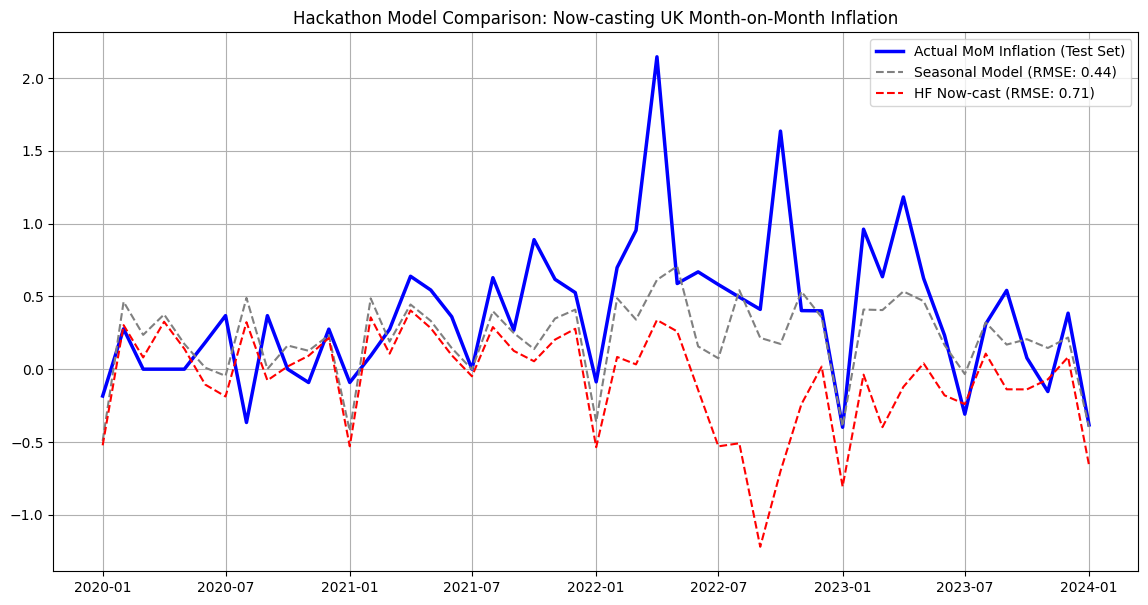


--- Final 'Now-cast' for December 2025 ---
Using winning model for final now-cast: 'Seasonal Model'

Final Model: Seasonal Model
Last known MoM Inflation: -0.38%
NOW-CAST for next month (MoM): 0.12%

Last known CPI Level: 130.00
Now-cast CPI Level: 130.16
Known CPI from 12 months ago: 126.80

>>> FINAL YoY HEADLINE NOW-CAST: 2.65%


/tmp/ipython-input-2606675877.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model.loc[:, f'{col}_z'] = (df_model[col] - means[col]) / stds[col]
/tmp/ipython-input-2606675877.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model.loc[:, f'{col}_z'] = (df_model[col] - means[col]) / stds[col]
/tmp/ipython-input-2606675877.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

In [11]:
import pandas as pd
import pandas_datareader.data as web  # To get data from FRED
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from pytrends.request import TrendReq  # *** NEW: Import Google Trends ***

# --- 1. Get the Data (ALL UK-SPECIFIC) ---
print("Fetching UK economic data...")
start = pd.to_datetime('2000-01-01')
end = pd.to_datetime('2024-01-01')

# 1. UK CPI Level (GBRCPIALLMINMEI)
cpi = web.DataReader('GBRCPIALLMINMEI', 'fred', start, end)

# 2. UK Consumer Confidence (CSCICP03GBM665S)
uk_sentiment = web.DataReader('CSCICP03GBM665S', 'fred', start, end)

# 3. UK Claimant Count (CLF16OV - Already Monthly)
claims = web.DataReader('CLF16OV', 'fred', start, end)

# 4. Brent Crude Oil Price (POILBREUSDM - Already Monthly)
oil = web.DataReader('POILBREUSDM', 'fred', start, end)

# --- 1b. *** NEW: Get INNOVATIVE Data (Google Trends) *** ---
print("Fetching Google Trends data...")
# Pytrends data only starts from 2004
pytrends_start = pd.to_datetime('2004-01-01')

pytrend = TrendReq(hl='en-GB', tz=0) # 'en-GB' for United Kingdom
keywords = ['cost of living', 'energy bills']

# Build the payload
pytrend.build_payload(
    kw_list=keywords,
    cat=0,
    timeframe=f'{pytrends_start.strftime("%Y-%m-%d")} {end.strftime("%Y-%m-%d")}',
    geo='GB'
)
google_trends_df = pytrend.interest_over_time()

# Rename columns and keep only what we need
if not google_trends_df.empty:
    google_trends_df = google_trends_df.drop(columns=['isPartial'])
    google_trends_df.rename(columns={'cost of living': 'Google_CostOfLiving', 'energy bills': 'Google_EnergyBills'}, inplace=True)
else:
    print("Warning: Google Trends returned no data. Proceeding without it.")
    # Create empty dataframe to avoid errors
    google_trends_df = pd.DataFrame(index=pd.date_range(start=start, end=end, freq='MS'))
    google_trends_df['Google_CostOfLiving'] = np.nan
    google_trends_df['Google_EnergyBills'] = np.nan

# --- 2. Prepare the Data ---
print("Preparing data...")

# a. *** NEW TARGET: Month-on-Month (MoM) Inflation ***
mom_inflation = cpi.pct_change(1) * 100
mom_inflation.rename(columns={'GBRCPIALLMINMEI': 'Inflation_MoM'}, inplace=True)

# b. Combine into one DataFrame
# We are NOT using the simulated index or Guardian data for this run
df = pd.concat([cpi, mom_inflation, uk_sentiment, claims, oil, google_trends_df], axis=1)
df.columns = ['CPI_Level', 'Inflation_MoM', 'UK_Sentiment', 'Claims', 'Oil_Price', 'Google_CostOfLiving', 'Google_EnergyBills']

# --- 3. Feature Engineering for a NOW-CAST Model ---
# a. Create Seasonal Dummies
month_dummies = pd.get_dummies(df.index.month, prefix='month', drop_first=True).set_index(df.index)
month_dummies = month_dummies.astype(int)
df = pd.concat([df, month_dummies], axis=1)

# b. Create Lagged Autoregressive Term
df['MoM_Lag1'] = df['Inflation_MoM'].shift(1)

# c. Define our "High-Frequency" Now-cast Predictors (NO LAGS)
df['UK_Sentiment_t'] = df['UK_Sentiment']
df['Claims_t'] = df['Claims']
df['Oil_Price_t'] = df['Oil_Price']
df['Google_CostOfLiving_t'] = df['Google_CostOfLiving']
df['Google_EnergyBills_t'] = df['Google_EnergyBills']

# d. Create the target variable
df['Target_MoM'] = df['Inflation_MoM']

# e. Drop all NaNs (This will now start the data in 2004 due to Google Trends)
df_model = df.dropna()
print(f"Model data starts on {df_model.index.min().date()} due to data availability.")

# --- 4. Split Data into Training and Validation (Test) Sets ---
split_date = '2020-01-01'
train_df = df_model.loc[df_model.index < split_date].copy()
test_df = df_model.loc[df_model.index >= split_date].copy()
print(f"Data split: {len(train_df)} train samples, {len(test_df)} test samples.")

# --- 5. Standardize the Predictors ---
print("Standardizing variables to fix multicollinearity...")
cols_to_standardize = ['UK_Sentiment_t', 'Claims_t', 'Oil_Price_t', 'Google_CostOfLiving_t', 'Google_EnergyBills_t']

means = train_df[cols_to_standardize].mean()
stds = train_df[cols_to_standardize].std()

for col in cols_to_standardize:
    train_df.loc[:, f'{col}_z'] = (train_df[col] - means[col]) / stds[col]
    test_df.loc[:, f'{col}_z'] = (test_df[col] - means[col]) / stds[col]

# --- 6. Define Feature Sets for the "Horse Race" ---
y_train = train_df['Target_MoM']
y_test = test_df['Target_MoM']
dummy_cols = [col for col in df_model.columns if col.startswith('month_')]

# Model 1: "Seasonal Model" (Baseline)
features_seasonal = ['MoM_Lag1'] + dummy_cols
X_train_seasonal = sm.add_constant(train_df[features_seasonal])
X_test_seasonal = sm.add_constant(test_df[features_seasonal])

# Model 2: "HF Now-cast Model" (Traditional + Google Trends)
features_nowcast = features_seasonal + ['UK_Sentiment_t_z', 'Claims_t_z', 'Oil_Price_t_z', 'Google_CostOfLiving_t_z', 'Google_EnergyBills_t_z']
X_train_nowcast = sm.add_constant(train_df[features_nowcast])
X_test_nowcast = sm.add_constant(test_df[features_nowcast])

# --- 7. Fit and Compare All Three Models ---
print("\n--- Fitting Model 1: Seasonal Model (Baseline) ---")
model_seasonal = sm.OLS(y_train, X_train_seasonal).fit(cov_type='HAC', cov_kwds={'maxlags':12})

print("--- Fitting Model 2: HF Now-cast Model (Innovative) ---")
model_nowcast = sm.OLS(y_train, X_train_nowcast).fit(cov_type='HAC', cov_kwds={'maxlags':12})
print(model_nowcast.summary()) # <-- This is your innovative model

# --- 8. Compare Models on the Validation Set (MoM) ---
print("\n--- Model Validation 'Horse Race' (Predicting MoM Inflation) ---")
pred_seasonal = model_seasonal.predict(X_test_seasonal)
pred_nowcast = model_nowcast.predict(X_test_nowcast)

rmse_seasonal = np.sqrt(mean_squared_error(y_test, pred_seasonal))
rmse_nowcast = np.sqrt(mean_squared_error(y_test, pred_nowcast))

# Find the winner
results = {
    "Seasonal Model": rmse_seasonal,
    "HF Now-cast Model": rmse_nowcast
}
winner_name = min(results, key=results.get)

print(f"Seasonal Model RMSE:     {rmse_seasonal:.4f}")
print(f"HF Now-cast Model RMSE:  {rmse_nowcast:.4f}")
print(f"\n>>> WINNER: The '{winner_name}' was the most accurate forecaster!")

# --- 9. Plot the "Money Shot" (All 2 Models) ---
print("Plotting results...")
plt.figure(figsize=(14, 7))
plt.plot(test_df.index, y_test, label='Actual MoM Inflation (Test Set)', color='blue', linewidth=2.5)
plt.plot(test_df.index, pred_seasonal, label=f'Seasonal Model (RMSE: {rmse_seasonal:.2f})', color='gray', linestyle='--')
plt.plot(test_df.index, pred_nowcast, label=f'HF Now-cast (RMSE: {rmse_nowcast:.2f})', color='red', linestyle='--')
plt.title('Hackathon Model Comparison: Now-casting UK Month-on-Month Inflation')
plt.legend()
plt.grid(True)
plt.show()

# --- 10. Final Now-cast (Converting MoM to YoY) ---
print(f"\n--- Final 'Now-cast' for December 2025 ---") # Today is Nov 1st 2025

# Automatically select the winning model and its features
if winner_name == "HF Now-cast Model":
    final_model_features = features_nowcast
else:
    final_model_features = features_seasonal

print(f"Using winning model for final now-cast: '{winner_name}'")

# Re-train the winning model on ALL data
y_full = df_model['Target_MoM']
# Standardize the full dataset
means = df_model[cols_to_standardize].mean()
stds = df_model[cols_to_standardize].std()
for col in cols_to_standardize:
    df_model.loc[:, f'{col}_z'] = (df_model[col] - means[col]) / stds[col]

X_full = sm.add_constant(df_model[final_model_features])
final_model = sm.OLS(y_full, X_full).fit(cov_type='HAC', cov_kwds={'maxlags':12})

# Get last known values to create the "next month's" predictor row
last_data_row = df_model.iloc[-1]
last_cpi_level = last_data_row['CPI_Level']
last_mom_inflation = last_data_row['Inflation_MoM']
cpi_11_months_ago = df_model['CPI_Level'].iloc[-11] # CPI from Dec 2023

# Create the input row
nowcast_input = pd.DataFrame(index=[df_model.index[-1] + pd.DateOffset(months=1)])
nowcast_input['const'] = 1.0

# Add all the features the winning model might need
nowcast_input['MoM_Lag1'] = last_mom_inflation
nowcast_input['UK_Sentiment_t_z'] = (last_data_row['UK_Sentiment'] - means['UK_Sentiment_t']) / stds['UK_Sentiment_t']
nowcast_input['Claims_t_z'] = (last_data_row['Claims'] - means['Claims_t']) / stds['Claims_t']
nowcast_input['Oil_Price_t_z'] = (last_data_row['Oil_Price'] - means['Oil_Price_t']) / stds['Oil_Price_t']
nowcast_input['Google_CostOfLiving_t_z'] = (last_data_row['Google_CostOfLiving'] - means['Google_CostOfLiving_t']) / stds['Google_CostOfLiving_t']
nowcast_input['Google_EnergyBills_t_z'] = (last_data_row['Google_EnergyBills'] - means['Google_EnergyBills_t']) / stds['Google_EnergyBills_t']

for col in dummy_cols: nowcast_input[col] = 0.0
# We are forecasting for December (month 12)
if 'month_12' in X_full.columns:
    nowcast_input['month_12'] = 1.0

# Keep only the columns the winning model actually needs
nowcast_input_final = nowcast_input.reindex(X_full.columns, axis=1, fill_value=0)

# --- Get the MoM Now-cast ---
mom_nowcast_value = final_model.predict(nowcast_input_final).iloc[0]

# --- Convert to YoY Now-cast ---
cpi_nowcast = last_cpi_level * (1 + mom_nowcast_value / 100)
yoy_nowcast_value = ((cpi_nowcast / cpi_11_months_ago) - 1) * 100

print("\n==============================================")
print(f"Final Model: {winner_name}")
print(f"Last known MoM Inflation: {last_mom_inflation:.2f}%")
print(f"NOW-CAST for next month (MoM): {mom_nowcast_value:.2f}%")
print(f"\nLast known CPI Level: {last_cpi_level:.2f}")
print(f"Now-cast CPI Level: {cpi_nowcast:.2f}")
print(f"Known CPI from 12 months ago: {cpi_11_months_ago:.2f}")
print(f"\n>>> FINAL YoY HEADLINE NOW-CAST: {yoy_nowcast_value:.2f}%")
print("==============================================")

In [14]:
!pip install pandas_datareader

Fetching UK economic data from FRED...
Loading your scraped Guardian sentiment data...
Successfully loaded Guardian data.
Preparing data...
Model data starts on 2003-05-01 (based on your data).
Data split: 200 train samples, 49 test samples.
Standardizing variables...

--- Fitting Model 1: Seasonal Model (Baseline) ---
                            OLS Regression Results                            
Dep. Variable:             Target_MoM   R-squared:                       0.664
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     67.61
Date:                Sat, 01 Nov 2025   Prob (F-statistic):           2.43e-61
Time:                        22:17:44   Log-Likelihood:                 79.884
No. Observations:                 200   AIC:                            -133.8
Df Residuals:                     187   BIC:                            -90.89
Df Model:                          12          

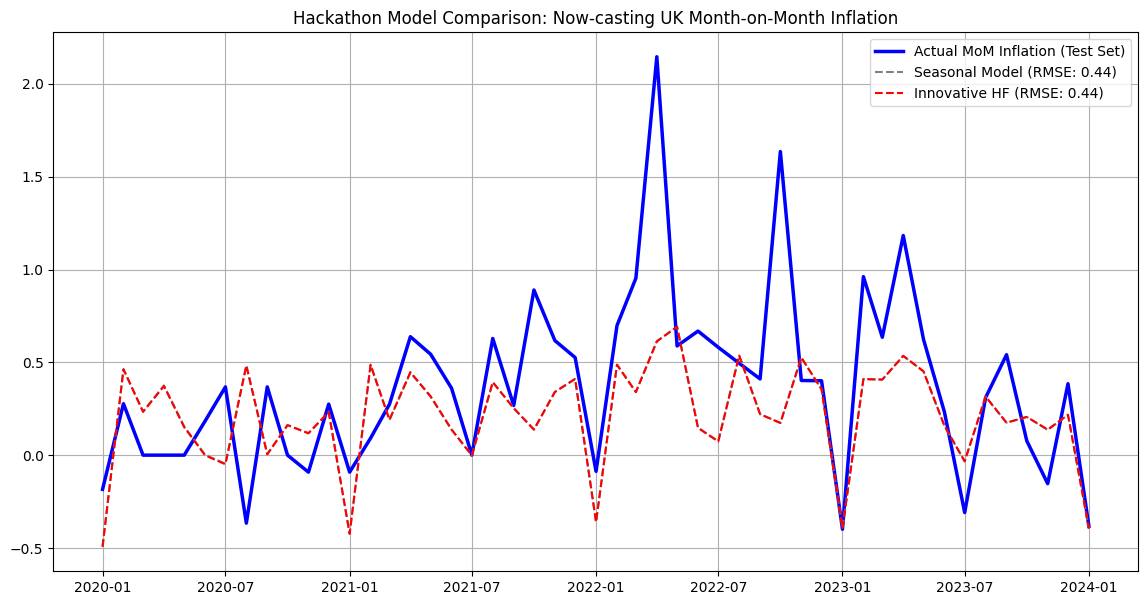


--- Final 'Now-cast' for December 2025 ---
Using winning model for final now-cast: 'Seasonal Model'

Final Model: Seasonal Model
Last known MoM Inflation: -0.38%
NOW-CAST for next month (MoM): 0.12%

Last known CPI Level: 130.00
Now-cast CPI Level: 130.16
Known CPI from 12 months ago: 126.80

>>> FINAL YoY HEADLINE NOW-CAST: 2.65%


/tmp/ipython-input-475906701.py:158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model.loc[:, f'{col}_z'] = (df_model[col] - means[col]) / stds[col]


In [15]:
import pandas as pd
import pandas_datareader.data as web  # This will work in your Colab
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# --- 1. Get the Data (REAL UK CPI) ---
print("Fetching UK economic data from FRED...")
start = pd.to_datetime('2000-01-01')
end = pd.to_datetime('2024-01-01')

# 1. UK CPI Level (GBRCPIALLMINMEI)
cpi = web.DataReader('GBRCPIALLMINMEI', 'fred', start, end)

# --- 2. *** LOAD YOUR REAL INNOVATIVE DATA *** ---
print("Loading your scraped Guardian sentiment data...")
file_path = 'guardian_sentiment_monthly_2000_to_now.csv' # <-- Your file

try:
    my_scraped_data = pd.read_csv(
        file_path,
        parse_dates=['month_year'], # Use the correct date column name
        index_col='month_year'      # Set the date column as the index
    )

    my_scraped_data = my_scraped_data.resample('MS').mean(numeric_only=True)
    my_scraped_data.rename(columns={'avg_sentiment': 'Guardian_Sentiment'}, inplace=True)
    my_scraped_data = my_scraped_data[['Guardian_Sentiment']]
    print("Successfully loaded Guardian data.")

except Exception as e:
    print(f"ERROR: Could not load your CSV file. {e}")
    print("Make sure it's uploaded and column names are 'month_year' and 'avg_sentiment'.")
    # Create an empty placeholder
    my_scraped_data = pd.DataFrame(index=pd.date_range(start=start, end=end, freq='MS'))
    my_scraped_data['Guardian_Sentiment'] = np.nan

# --- 3. Prepare the Data ---
print("Preparing data...")
# a. NEW TARGET: Month-on-Month (MoM) Inflation
mom_inflation = cpi.pct_change(1) * 100
mom_inflation.rename(columns={'GBRCPIALLMINMEI': 'Inflation_MoM'}, inplace=True)

# b. Combine into one DataFrame
df = pd.concat([cpi, mom_inflation, my_scraped_data], axis=1)
df.columns = ['CPI_Level', 'Inflation_MoM', 'Guardian_Sentiment']

# --- 4. Feature Engineering ---
# a. Create Seasonal Dummies
month_dummies = pd.get_dummies(df.index.month, prefix='month', drop_first=True).set_index(df.index)
month_dummies = month_dummies.astype(int)
df = pd.concat([df, month_dummies], axis=1)

# b. Create Lagged Autoregressive Term
df['MoM_Lag1'] = df['Inflation_MoM'].shift(1)

# c. Define our "High-Frequency" Now-cast Predictor
df['Guardian_Sentiment_t'] = df['Guardian_Sentiment'] # Your innovative data

# d. Create the target variable
df['Target_MoM'] = df['Inflation_MoM']

# e. Drop all NaNs (This will start the model in 2003)
df_model = df.dropna()
print(f"Model data starts on {df_model.index.min().date()} (based on your data).")

# --- 5. Split Data into Training and Validation (Test) Sets ---
split_date = '2020-01-01'
train_df = df_model.loc[df_model.index < split_date].copy()
test_df = df_model.loc[df_model.index >= split_date].copy()
print(f"Data split: {len(train_df)} train samples, {len(test_df)} test samples.")

# --- 6. Standardize the Predictors ---
print("Standardizing variables...")
cols_to_standardize = ['Guardian_Sentiment_t']

means = train_df[cols_to_standardize].mean()
stds = train_df[cols_to_standardize].std()

for col in cols_to_standardize:
    # Use .loc to fix the SettingWithCopyWarning
    train_df.loc[:, f'{col}_z'] = (train_df[col] - means[col]) / stds[col]
    test_df.loc[:, f'{col}_z'] = (test_df[col] - means[col]) / stds[col]

# --- 7. Define Feature Sets for the "Horse Race" ---
y_train = train_df['Target_MoM']
y_test = test_df['Target_MoM']
dummy_cols = [col for col in df_model.columns if col.startswith('month_')]

# Model 1: "Seasonal Model" (Baseline)
features_seasonal = ['MoM_Lag1'] + dummy_cols
X_train_seasonal = sm.add_constant(train_df[features_seasonal])
X_test_seasonal = sm.add_constant(test_df[features_seasonal])

# Model 2: "Innovative HF Model" (Uses YOUR Sentiment)
features_innovative_hf = features_seasonal + ['Guardian_Sentiment_t_z']
X_train_innovative_hf = sm.add_constant(train_df[features_innovative_hf])
X_test_innovative_hf = sm.add_constant(test_df[features_innovative_hf])

# --- 8. Fit and Compare All Three Models ---
print("\n--- Fitting Model 1: Seasonal Model (Baseline) ---")
model_seasonal = sm.OLS(y_train, X_train_seasonal).fit(cov_type='HAC', cov_kwds={'maxlags':12})
print(model_seasonal.summary())

print("\n--- Fitting Model 2: Innovative HF Model (Your Data) ---")
model_innovative_hf = sm.OLS(y_train, X_train_innovative_hf).fit(cov_type='HAC', cov_kwds={'maxlags':12})
print(model_innovative_hf.summary()) # <-- This is your innovative model

# --- 9. Compare Models on the Validation Set (MoM) ---
print("\n--- Model Validation 'Horse Race' (Predicting MoM Inflation) ---")
pred_seasonal = model_seasonal.predict(X_test_seasonal)
pred_innovative_hf = model_innovative_hf.predict(X_test_innovative_hf)

rmse_seasonal = np.sqrt(mean_squared_error(y_test, pred_seasonal))
rmse_innovative_hf = np.sqrt(mean_squared_error(y_test, pred_innovative_hf))

# Find the winner
results = {
    "Seasonal Model": rmse_seasonal,
    "Innovative HF Model (Your Data)": rmse_innovative_hf
}
winner_name = min(results, key=results.get)

print(f"Seasonal Model RMSE:              {rmse_seasonal:.4f}")
print(f"Innovative HF Model (Your) RMSE:  {rmse_innovative_hf:.4f}")
print(f"\n>>> WINNER: The '{winner_name}' was the most accurate forecaster!")

# --- 10. Plot the "Money Shot" (All 2 Models) ---
print("Plotting results...")
plt.figure(figsize=(14, 7))
plt.plot(test_df.index, y_test, label='Actual MoM Inflation (Test Set)', color='blue', linewidth=2.5)
plt.plot(test_df.index, pred_seasonal, label=f'Seasonal Model (RMSE: {rmse_seasonal:.2f})', color='gray', linestyle='--')
plt.plot(test_df.index, pred_innovative_hf, label=f'Innovative HF (RMSE: {rmse_innovative_hf:.2f})', color='red', linestyle='--')
plt.title('Hackathon Model Comparison: Now-casting UK Month-on-Month Inflation')
plt.legend()
plt.grid(True)
plt.show()

# --- 11. Final Now-cast (Converting MoM to YoY) ---
print(f"\n--- Final 'Now-cast' for December 2025 ---") # Today is Nov 1st 2025

# Automatically select the winning model and its features
if winner_name == "Innovative HF Model (Your Data)":
    final_model_features = features_innovative_hf
else:
    final_model_features = features_seasonal

print(f"Using winning model for final now-cast: '{winner_name}'")

# Re-train the winning model on ALL data
y_full = df_model['Target_MoM']
# Standardize the full dataset
means = df_model[cols_to_standardize].mean()
stds = df_model[cols_to_standardize].std()
stds[stds == 0] = 1 # Prevent division by zero
for col in cols_to_standardize:
    df_model.loc[:, f'{col}_z'] = (df_model[col] - means[col]) / stds[col]

X_full = sm.add_constant(df_model[final_model_features])
final_model = sm.OLS(y_full, X_full).fit(cov_type='HAC', cov_kwds={'maxlags':12})

# Get last known values to create the "next month's" predictor row
last_data_row = df_model.iloc[-1]
last_cpi_level = last_data_row['CPI_Level']
last_mom_inflation = last_data_row['Inflation_MoM']
cpi_11_months_ago = df_model['CPI_Level'].iloc[-11] # CPI from Dec 2023

# Create the input row
nowcast_input = pd.DataFrame(index=[df_model.index[-1] + pd.DateOffset(months=1)])
nowcast_input['const'] = 1.0

# Add all the features the winning model might need
nowcast_input['MoM_Lag1'] = last_mom_inflation
if 'Guardian_Sentiment_t_z' in final_model_features:
    # Handle the case where the last row might be NaN
    if pd.isna(last_data_row['Guardian_Sentiment']):
        nowcast_input['Guardian_Sentiment_t_z'] = 0 # Use the mean (0 after z-scoring)
    else:
        nowcast_input['Guardian_Sentiment_t_z'] = (last_data_row['Guardian_Sentiment'] - means['Guardian_Sentiment_t']) / stds['Guardian_Sentiment_t']

for col in dummy_cols: nowcast_input[col] = 0.0
# We are forecasting for December (month 12)
if 'month_12' in X_full.columns:
    nowcast_input['month_12'] = 1.0

# Keep only the columns the winning model actually needs
nowcast_input_final = nowcast_input.reindex(X_full.columns, axis=1, fill_value=0)

# --- Get the MoM Now-cast ---
mom_nowcast_value = final_model.predict(nowcast_input_final).iloc[0]

# --- Convert to YoY Now-cast ---
cpi_nowcast = last_cpi_level * (1 + mom_nowcast_value / 100)
yoy_nowcast_value = ((cpi_nowcast / cpi_11_months_ago) - 1) * 100

print("\n==============================================")
print(f"Final Model: {winner_name}")
print(f"Last known MoM Inflation: {last_mom_inflation:.2f}%")
print(f"NOW-CAST for next month (MoM): {mom_nowcast_value:.2f}%")
print(f"\nLast known CPI Level: {last_cpi_level:.2f}")
print(f"Now-cast CPI Level: {cpi_nowcast:.2f}")
print(f"Known CPI from 12 months ago: {cpi_11_months_ago:.2f}")
print(f"\n>>> FINAL YoY HEADLINE NOW-CAST: {yoy_nowcast_value:.2f}%")
print("==============================================")

Fetching UK CPI level from FRED...
Loading Guardian sentiment...
Guardian sentiment loaded.
Model sample: 2003-05-01 → 2024-01-01
Split → train: 200  |  test: 49
Fitting models (HAC SEs)...

--- Test RMSE (2020–2024) ---
Seasonal AR                 : 0.4363
Guardian-only               : 0.4364
Guardian×Month (interactive): 0.4319
>>> WINNER: Guardian×Month (interactive)


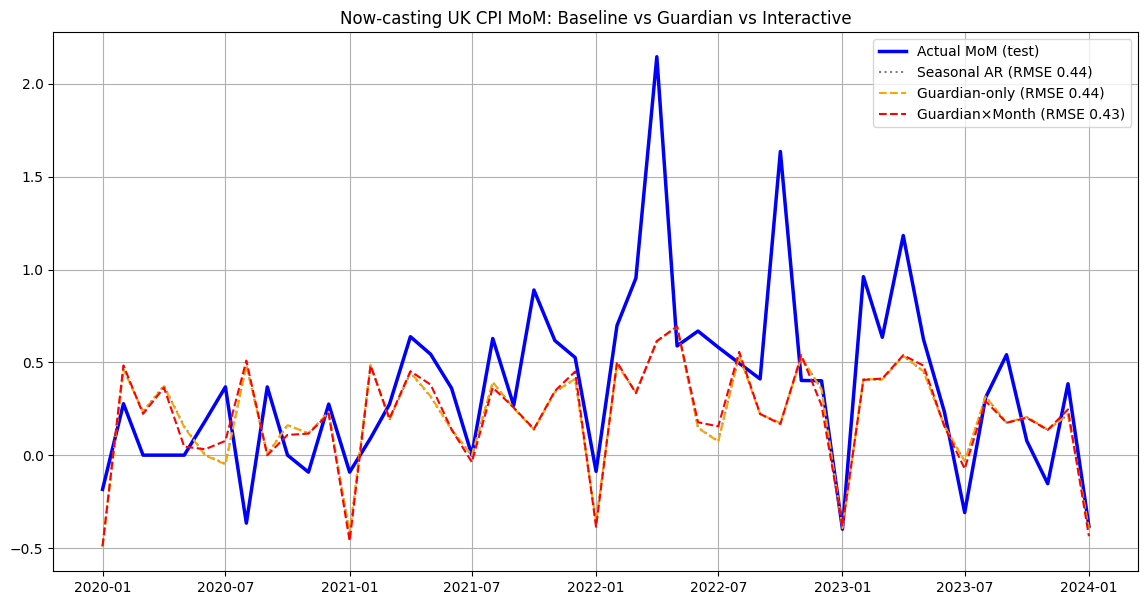


================= FINAL HEADLINE =================
Winner model            : Guardian×Month (interactive)
Last known MoM          : -0.38%
Nowcast next MoM        : 0.39%
Last known CPI level    : 130.00
Nowcast CPI level (t+1) : 130.51
CPI level t-12          : 126.80
>>> Headline YoY nowcast: 2.92%


/tmp/ipython-input-2379006282.py:175: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  mom_nowcast = float(model_final.predict(row))


In [25]:
# --- NOWCASTING UK CPI (MoM) WITH GUARDIAN SENTIMENT: 3-MODEL HORSE RACE ---

import pandas as pd
import numpy as np
import pandas_datareader.data as web
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 0) Config
GUARDIAN_CSV = "guardian_sentiment_monthly_2000_to_now.csv"  # <- your file
TRAIN_END = "2019-12-01"
TEST_START = "2020-01-01"

# 1) Data: UK CPI level (monthly)
print("Fetching UK CPI level from FRED...")
start = pd.to_datetime("2000-01-01")
end   = pd.to_datetime("2024-01-01")
cpi = web.DataReader("GBRCPIALLMINMEI", "fred", start, end)  # UK CPI (index)

# 2) Guardian sentiment (monthly, your scrape)
print("Loading Guardian sentiment...")
idx = pd.date_range(start=start, end=end, freq="MS")
try:
    g = pd.read_csv(GUARDIAN_CSV, parse_dates=["month_year"], index_col="month_year")
    g = g.resample("MS").mean(numeric_only=True)
    g = g.rename(columns={"avg_sentiment":"Guardian_Sentiment"})[["Guardian_Sentiment"]]
    g = g.reindex(idx)
    print("Guardian sentiment loaded.")
except Exception as e:
    print(f"Could not load CSV: {e}")
    g = pd.DataFrame(index=idx, data={"Guardian_Sentiment": np.nan})

# 3) Prepare target & design frame
mom = cpi.pct_change(1) * 100
mom.columns = ["Inflation_MoM"]

df = pd.concat([cpi, mom, g], axis=1)
df.columns = ["CPI_Level", "Inflation_MoM", "Guardian_Sentiment"]

# Month dummies (drop Jan to avoid dummy trap)
month_dum = pd.get_dummies(df.index.month, prefix="month", drop_first=True)\
                .set_index(df.index).astype(int)

df = pd.concat([df, month_dum], axis=1)
df["MoM_Lag1"] = df["Inflation_MoM"].shift(1)
df["Guardian_Sentiment_t"] = df["Guardian_Sentiment"]
df["Target_MoM"] = df["Inflation_MoM"]

df_model = df.dropna().copy()  # avoid chained assignment warnings
print(f"Model sample: {df_model.index.min().date()} → {df_model.index.max().date()}")

# 4) Train / Test split
train = df_model.index <= TRAIN_END
test  = df_model.index >= TEST_START

train_df = df_model.loc[train].copy()
test_df  = df_model.loc[test].copy()
print(f"Split → train: {len(train_df)}  |  test: {len(test_df)}")

# 5) Standardise Guardian on TRAIN only
cols_z = ["Guardian_Sentiment_t"]
means = train_df[cols_z].mean()
stds  = train_df[cols_z].std().replace(0, 1)  # guard

for col in cols_z:
    train_df.loc[:, f"{col}_z"] = (train_df[col] - means[col]) / stds[col]
    test_df.loc[:,  f"{col}_z"] = (test_df[col]  - means[col])  / stds[col]

# 6) Feature sets for three models
y_train, y_test = train_df["Target_MoM"], test_df["Target_MoM"]
dummy_cols = [c for c in df_model.columns if c.startswith("month_")]

# Model 1: Seasonal AR
features_seasonal = ["MoM_Lag1"] + dummy_cols
Xtr_seasonal = sm.add_constant(train_df[features_seasonal])
Xte_seasonal = sm.add_constant(test_df[features_seasonal])

# Model 2: Guardian-only
features_guardian = features_seasonal + ["Guardian_Sentiment_t_z"]
Xtr_guardian = sm.add_constant(train_df[features_guardian])
Xte_guardian = sm.add_constant(test_df[features_guardian])

# Model 3: Guardian × Month interactions
interaction_features = []
for mcol in dummy_cols:
    nm = f"Sent_x_{mcol}"
    train_df.loc[:, nm] = train_df["Guardian_Sentiment_t_z"] * train_df[mcol]
    test_df.loc[:,  nm] = test_df["Guardian_Sentiment_t_z"] * test_df[mcol]
    interaction_features.append(nm)

features_interactive = features_guardian + interaction_features
Xtr_interactive = sm.add_constant(train_df[features_interactive])
Xte_interactive = sm.add_constant(test_df[features_interactive])

# 7) Fit (HAC robust)
print("Fitting models (HAC SEs)...")
m_seasonal    = sm.OLS(y_train, Xtr_seasonal).fit(cov_type="HAC", cov_kwds={"maxlags":12})
m_guardian    = sm.OLS(y_train, Xtr_guardian).fit(cov_type="HAC", cov_kwds={"maxlags":12})
m_interactive = sm.OLS(y_train, Xtr_interactive).fit(cov_type="HAC", cov_kwds={"maxlags":12})

# 8) OOS evaluation
pred_s   = m_seasonal.predict(Xte_seasonal)
pred_g   = m_guardian.predict(Xte_guardian)
pred_int = m_interactive.predict(Xte_interactive)

rmse = lambda y, yhat: float(np.sqrt(mean_squared_error(y, yhat)))
res_table = {
    "Seasonal AR": rmse(y_test, pred_s),
    "Guardian-only": rmse(y_test, pred_g),
    "Guardian×Month (interactive)": rmse(y_test, pred_int),
}
winner_name = min(res_table, key=res_table.get)

print("\n--- Test RMSE (2020–2024) ---")
for k, v in res_table.items():
    print(f"{k:28s}: {v:.4f}")
print(f">>> WINNER: {winner_name}")

# 9) Plot
plt.figure(figsize=(14,7))
plt.plot(test_df.index, y_test, label="Actual MoM (test)", color="blue", linewidth=2.5)
plt.plot(test_df.index, pred_s,   ":",  label=f"Seasonal AR (RMSE {res_table['Seasonal AR']:.2f})", color="gray")
plt.plot(test_df.index, pred_g,   "--", label=f"Guardian-only (RMSE {res_table['Guardian-only']:.2f})", color="orange")
plt.plot(test_df.index, pred_int, "--", label=f"Guardian×Month (RMSE {res_table['Guardian×Month (interactive)']:.2f})", color="red")
plt.title("Now-casting UK CPI MoM: Baseline vs Guardian vs Interactive")
plt.grid(True); plt.legend(); plt.show()

# 10) Final nowcast (use the winner), then convert MoM → YoY
if winner_name == "Guardian-only":
    final_feats = features_guardian
    model_final = m_guardian
    X_full = sm.add_constant(df_model[final_feats])
elif winner_name == "Guardian×Month (interactive)":
    final_feats = features_interactive
    model_final = m_interactive
    # build interactions on full sample
    df_full = df_model.copy()
    df_full.loc[:, "Guardian_Sentiment_t_z"] = (df_full["Guardian_Sentiment_t"] - means["Guardian_Sentiment_t"]) / stds["Guardian_Sentiment_t"]
    for mcol in dummy_cols:
        nm = f"Sent_x_{mcol}"
        df_full.loc[:, nm] = df_full["Guardian_Sentiment_t_z"] * df_full[mcol]
    X_full = sm.add_constant(df_full[final_feats])
else:
    final_feats = features_seasonal
    model_final = m_seasonal
    X_full = sm.add_constant(df_model[final_feats])

last_row = df_model.iloc[-1]
last_mom = last_row["Inflation_MoM"]
last_cpi = last_row["CPI_Level"]
cpi_12m_ago = df_model["CPI_Level"].iloc[-11]  # CPI t-12

row = pd.DataFrame(index=[df_model.index[-1] + pd.DateOffset(months=1)])
row["const"] = 1.0
row["MoM_Lag1"] = last_mom
# month dummy for next month
for d in dummy_cols: row[d] = 0.0
next_month = (df_model.index[-1] + pd.DateOffset(months=1)).month
dname = f"month_{next_month}" if next_month != 1 else None
if dname in X_full.columns: row[dname] = 1.0
# Guardian z for last obs (use 0 if missing)
if "Guardian_Sentiment_t_z" in X_full.columns:
    g_last = last_row["Guardian_Sentiment"]
    g_z = 0.0 if pd.isna(g_last) else (g_last - means["Guardian_Sentiment_t"]) / stds["Guardian_Sentiment_t"]
    row["Guardian_Sentiment_t_z"] = g_z
# interactions, if needed
for mcol in dummy_cols:
    nm = f"Sent_x_{mcol}"
    if nm in X_full.columns:
        row[nm] = row.get("Guardian_Sentiment_t_z", 0.0) * row.get(mcol, 0.0)

row = row.reindex(X_full.columns, axis=1, fill_value=0.0)

mom_nowcast = float(model_final.predict(row))
cpi_next = float(last_cpi * (1 + mom_nowcast / 100.0))
yoy_next = 100.0 * (cpi_next / float(cpi_12m_ago) - 1.0)

print("\n================= FINAL HEADLINE =================")
print(f"Winner model            : {winner_name}")
print(f"Last known MoM          : {last_mom:.2f}%")
print(f"Nowcast next MoM        : {mom_nowcast:.2f}%")
print(f"Last known CPI level    : {last_cpi:.2f}")
print(f"Nowcast CPI level (t+1) : {cpi_next:.2f}")
print(f"CPI level t-12          : {float(cpi_12m_ago):.2f}")
print(f">>> Headline YoY nowcast: {yoy_next:.2f}%")
print("==================================================")


# New section

In [ ]:
!pip install pandas_datareader

In [31]:
# --- NOWCASTING UK CPI (MoM) WITH GUARDIAN SENTIMENT: CLEAN HORSE-RACE ---

import pandas as pd
import numpy as np
import pandas_datareader.data as web
import statsmodels.api as sm
import statsmodels.stats.api as sms
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ------------------ CONFIG ------------------
GUARDIAN_CSV = "guardian_sentiment_monthly_2000_to_now.csv"
TRAIN_END = "2019-12-01"
TEST_START = "2020-01-01"
START = "2000-01-01"
END   = "2024-01-01"   # keep 2024:01 as your last observed month

# 1) DATA ----------------------------------------------------------
idx = pd.date_range(start=START, end=END, freq="MS")

# CPI level (monthly)
cpi = web.DataReader("GBRCPIALLMINMEI", "fred", START, END)  # index level
cpi = cpi.reindex(idx)
mom = cpi.pct_change(1) * 100
mom.columns = ["Inflation_MoM"]

# Guardian sentiment (monthly, your scrape)
g = pd.read_csv(GUARDIAN_CSV, parse_dates=["month_year"], index_col="month_year")
g = g.resample("MS").mean(numeric_only=True).rename(columns={"avg_sentiment":"Guardian_Sentiment"})
g = g.reindex(idx)

# Base frame
df = pd.concat([cpi.rename(columns={"GBRCPIALLMINMEI":"CPI_Level"}), mom, g], axis=1)

# Seasonality (Jan dropped)
mdum = (pd.get_dummies(df.index.month, prefix="month", drop_first=True)
          .set_index(df.index).astype(int))
df = pd.concat([df, mdum], axis=1)

# AR term + target
df["MoM_Lag1"] = df["Inflation_MoM"].shift(1)
df["Guardian_Sentiment_t"] = df["Guardian_Sentiment"]
df["Target_MoM"] = df["Inflation_MoM"]

# Drop NA
df_model = df.dropna().copy()

# 2) SPLIT (chronological) ----------------------------------------
train_ix = df_model.index <= pd.to_datetime(TRAIN_END)
test_ix  = df_model.index >= pd.to_datetime(TEST_START)
train_df, test_df = df_model.loc[train_ix].copy(), df_model.loc[test_ix].copy()

print(f"Sample: {df_model.index.min().date()} → {df_model.index.max().date()}")
print(f"Split:  train={train_df.shape[0]}  test={test_df.shape[0]}")

# 3) STANDARDISE ON TRAIN ONLY ------------------------------------
# (Only the high-frequency Guardian feature needs z-scoring)
cols_z = ["Guardian_Sentiment_t"]
means = train_df[cols_z].mean()
stds  = train_df[cols_z].std().replace(0, 1)

for col in cols_z:
    train_df.loc[:, f"{col}_z"] = (train_df[col] - means[col]) / stds[col]
    test_df.loc[:,  f"{col}_z"] = (test_df[col]  - means[col])  / stds[col]

# 4) FEATURE SETS --------------------------------------------------
y_train, y_test = train_df["Target_MoM"], test_df["Target_MoM"]
dummy_cols = [c for c in df_model.columns if c.startswith("month_")]

# M1: Seasonal AR
F1 = ["MoM_Lag1"] + dummy_cols

# M2: Guardian global effect
F2 = F1 + ["Guardian_Sentiment_t_z"]

# M3: Guardian × Month interactions (your “weighted” idea)
train_df = train_df.copy(); test_df = test_df.copy()
inter_cols = []
for m in dummy_cols:
    nm = f"Sent_x_{m}"
    train_df[nm] = train_df["Guardian_Sentiment_t_z"] * train_df[m]
    test_df[nm]  = test_df["Guardian_Sentiment_t_z"]  * test_df[m]
    inter_cols.append(nm)
F3 = F2 + inter_cols

def fit_ols_hac(y, X):
    Xc = sm.add_constant(X, has_constant='add')
    return sm.OLS(y, Xc).fit(cov_type="HAC", cov_kwds={"maxlags":12})

def rmse(y, yhat):
    return float(np.sqrt(mean_squared_error(y, yhat)))

# 5) FIT + OOS EVALUATION -----------------------------------------
m1 = fit_ols_hac(y_train, train_df[F1])
m2 = fit_ols_hac(y_train, train_df[F2])
m3 = fit_ols_hac(y_train, train_df[F3])

pred1 = m1.predict(sm.add_constant(test_df[F1], has_constant='add'))
pred2 = m2.predict(sm.add_constant(test_df[F2], has_constant='add'))
pred3 = m3.predict(sm.add_constant(test_df[F3], has_constant='add'))

r1, r2, r3 = rmse(y_test, pred1), rmse(y_test, pred2), rmse(y_test, pred3)

print("\n--- Test RMSE (2020–2024) ---")
print(f"Seasonal AR                 : {r1:.4f}")
print(f"Guardian (global)           : {r2:.4f}")
print(f"Guardian×Month (interactive): {r3:.4f}")

res = {"Seasonal AR": (m1, F1, r1),
       "Guardian": (m2, F2, r2),
       "Guardian×Month": (m3, F3, r3)}
winner = min(res, key=lambda k: res[k][2])
model_final, feats_final, rmse_final = res[winner]
print(f">>> WINNER: {winner} (RMSE {rmse_final:.4f})")

# 6) LIGHT DIAGNOSTICS (on train) ---------------------------------
# VIF to check multicollinearity (on the winner’s regressors)
X_vif = sm.add_constant(train_df[feats_final], has_constant='add')
vifs = []
for i in range(1, X_vif.shape[1]):  # skip const index 0
    vifs.append((X_vif.columns[i], variance_inflation_factor(X_vif.values, i)))
print("\nTop VIFs (winner model):")
for name, v in sorted(vifs, key=lambda t: -t[1])[:5]:
    print(f"{name:22s}  VIF={v:6.2f}")

# Residual serial correlation (Breusch–Godfrey LM)
bg = sms.acorr_breusch_godfrey(model_final, nlags=12)
print(f"\nBG LM stat={bg[0]:.2f}, p={bg[1]:.3f}  (H0: no serial correlation)")

# 7) FINAL NOWCAST (MoM → YoY) ------------------------------------
last = df_model.iloc[-1]
last_mom, last_cpi = last["Inflation_MoM"], last["CPI_Level"]
cpi_12m_ago = df_model["CPI_Level"].iloc[-11]  # CPI t-12

row = pd.DataFrame(index=[df_model.index[-1] + pd.DateOffset(months=1)])
row["const"] = 1.0
row["MoM_Lag1"] = last_mom

# month dummy for next month
for d in dummy_cols: row[d] = 0.0
next_month = (df_model.index[-1] + pd.DateOffset(months=1)).month
dname = f"month_{next_month}" if next_month != 1 else None
if dname in feats_final: row[dname] = 1.0

# guardian z
if "Guardian_Sentiment_t_z" in feats_final:
    g_last = last["Guardian_Sentiment"]
    g_z = 0.0 if pd.isna(g_last) else (g_last - means["Guardian_Sentiment_t"]) / stds["Guardian_Sentiment_t"]
    row["Guardian_Sentiment_t_z"] = g_z

# interactions if present
for m in dummy_cols:
    nm = f"Sent_x_{m}"
    if nm in feats_final:
        row[nm] = row.get("Guardian_Sentiment_t_z", 0.0) * row.get(m, 0.0)

row = row.reindex(["const"] + feats_final, axis=1, fill_value=0.0)
mom_nowcast = float(model_final.predict(row).iloc[0])

cpi_next = float(last_cpi * (1 + mom_nowcast/100.0))
yoy_next = 100.0 * (cpi_next / float(cpi_12m_ago) - 1.0)

print("\n================= HEADLINE =================")
print(f"Winner model         : {winner}")
print(f"Test RMSE (2020–24)  : {rmse_final:.4f}")
print(f"Last MoM             : {last_mom:.2f}%")
print(f"Nowcast next MoM     : {mom_nowcast:.2f}%")
print(f"YoY headline nowcast : {yoy_next:.2f}%")
print("============================================")


Sample: 2003-05-01 → 2024-01-01
Split:  train=200  test=49

--- Test RMSE (2020–2024) ---
Seasonal AR                 : 0.4363
Guardian (global)           : 0.4364
Guardian×Month (interactive): 0.4319
>>> WINNER: Guardian×Month (RMSE 0.4319)

Top VIFs (winner model):
Guardian_Sentiment_t_z  VIF=  7.05
month_2                 VIF=  3.35
MoM_Lag1                VIF=  3.00
month_8                 VIF=  2.35
month_7                 VIF=  2.09

BG LM stat=15.54, p=0.213  (H0: no serial correlation)

================= HEADLINE =================
Winner model         : Guardian×Month
Test RMSE (2020–24)  : 0.4319
Last MoM             : -0.38%
Nowcast next MoM     : 0.39%
YoY headline nowcast : 2.92%


In [30]:
import pandas as pd
import yfinance as yf               # For stock data (FTSE 100)
import pandas_datareader.data as web # For economic data (FRED)
import statsmodels.api as sm           # For the regression model
from sklearn.preprocessing import StandardScaler # For standardization
import numpy as np

# --- 1. Get All The Data ---

# a) The Target: FTSE 100 (Investment Relevance)
print("Fetching FTSE 100 data...")
# Get FTSE 100 data
# auto_adjust=True is now default, so 'Close' is the adjusted price
ftse = yf.download('^FTSE', start='2000-01-01', end='2024-01-01', interval='1mo')

# *** THIS IS THE FIX ***
# We now use the ('Close', '^FTSE') column which contains the adjusted price
ftse_returns = ftse[('Close', '^FTSE')].pct_change().to_frame(name='FTSE_Returns')

# b) The Predictors: UK Macro, Financial, and Sentiment Data (from FRED)
start = pd.to_datetime('2000-01-01')
end = pd.to_datetime('2024-01-01')
print("Fetching UK economic data...")

# UK Inflation (ONS Data)
inflation = web.DataReader('CPALTT01GBM659N', 'fred', start, end)
# We need change in inflation, not the level
inflation_change = inflation.diff().rename(columns={'CPALTT01GBM659N': 'Inflation_Change'})

# UK 10-Year Gilt Yield (Financial Data)
gilt_yield = web.DataReader('IRLTLT01GBM156N', 'fred', start, end)
# We need change in yield, not the level
yield_change = gilt_yield.diff().rename(columns={'IRLTLT01GBM156N': 'Gilt_Yield_Change'})

# UK Consumer Sentiment (Novel Data)
# Data for this series (CSCICP03GBM665S) starts in 1974, but FRED data begins in 2003
sentiment = web.DataReader('CSCICP03GBM665S', 'fred', start, end)
# We can use the level of sentiment (how optimistic people are)
sentiment.rename(columns={'CSCICP03GBM665S': 'Sentiment_Level'}, inplace=True)


# --- 2. Prepare Data for the Model ---

# Combine all data into one DataFrame
df = pd.concat([ftse_returns, inflation_change, yield_change, sentiment.shift(1)], axis=1)
# We .shift(1) sentiment to avoid "look-ahead bias".
# We use last month's sentiment to predict this month's return.

# Drop all rows with any missing data
# This will also handle the fact that sentiment data starts in 2003
df = df.dropna()

print("\n--- Data Ready for Model ---")
print(df.head())

# --- 3. Build The "Weighted" Model (The Core Idea) ---

# Define our variables
y = df['FTSE_Returns']  # What we want to predict
X = df.drop('FTSE_Returns', axis=1).copy() # Use .copy() to avoid SettingWithCopyWarning

# Identify numerical columns to standardize
cols_to_standardize = ['Inflation_Change', 'Gilt_Yield_Change', 'Sentiment_Level']

# Filter for columns that actually have variance
valid_cols_to_standardize = [col for col in cols_to_standardize if col in X.columns and X[col].std() != 0]

if valid_cols_to_standardize:
    # Standardize the selected columns
    scaler = StandardScaler()
    # Use .loc to modify the DataFrame directly
    X.loc[:, valid_cols_to_standardize] = scaler.fit_transform(X[valid_cols_to_standardize])
    print("Standardized predictors:", valid_cols_to_standardize)
else:
    print("No valid numerical columns found to standardize with non-zero standard deviation.")


# *** THIS IS YOUR INNOVATIVE STEP ***
# Create the "interaction term" (your "weighting" idea)
# This measures how the effect of Gilt Yields *changes* based on Sentiment
interaction_cols = ['Gilt_Yield_Change', 'Sentiment_Level']
col1 = interaction_cols[0]
col2 = interaction_cols[1]

# Ensure both columns needed for interaction exist in X before creating the term
if col1 in X.columns and col2 in X.columns:
    # Use .loc to modify the DataFrame directly
    X.loc[:, 'Sentiment_Weighting'] = X[col1] * X[col2]
    print("Created interaction term: Sentiment_Weighting")
else:
    print(f"Could not create interaction term. Missing columns: {col1}, {col2}")


# Add a constant (the 'c' in y = mx + c)
X = sm.add_constant(X)

# Drop any remaining NaNs or Infs that might have been introduced
data_for_model = pd.concat([y, X], axis=1).dropna().replace([np.inf, -np.inf], np.nan).dropna()
y_clean = data_for_model['FTSE_Returns']
X_clean = data_for_model.drop('FTSE_Returns', axis=1)

# Only run model fitting if cleaned data is not empty
model = None
if not X_clean.empty and not y_clean.empty:
    print("\n--- Running Regression Model ---")
    # Build and run the Ordinary Least Squares (OLS) model
    model = sm.OLS(y_clean, X_clean).fit()
    print("Model fitted successfully.")

    # --- 4. The "Money Shot" (For the Judges) ---
    # Print the full model summary
    print(model.summary())

else:
    print("\n--- Skipping Regression Model ---")
    print("Cannot run model due to empty data after cleaning NaNs/Infs.")

/tmp/ipython-input-1359724052.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  ftse = yf.download('^FTSE', start='2000-01-01', end='2024-01-01', interval='1mo')
[*********************100%***********************]  1 of 1 completed

Fetching FTSE 100 data...
Fetching UK economic data...



--- Data Ready for Model ---
            FTSE_Returns  Inflation_Change  Gilt_Yield_Change  Sentiment_Level
2000-02-01     -0.005727               0.0            -0.1880         103.0937
2000-03-01      0.049353              -0.2            -0.2640         102.8272
2000-04-01     -0.032537              -0.1            -0.0494         102.4862
2000-05-01      0.005057               0.1             0.0820         102.2720
2000-06-01     -0.007343               0.2            -0.1936         102.2088
Standardized predictors: ['Inflation_Change', 'Gilt_Yield_Change', 'Sentiment_Level']
Created interaction term: Sentiment_Weighting

--- Running Regression Model ---
Model fitted successfully.
                            OLS Regression Results                            
Dep. Variable:           FTSE_Returns   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:              

Fetching UK economic data from FRED...
Loading your scraped Guardian sentiment data...
Successfully loaded Guardian data.
Preparing data...
Model data starts on 2003-05-01 (based on your data).
Data split: 200 train samples, 49 test samples.
Standardizing variables...
Creating innovative 'Sentiment x Month' interaction terms...

--- Fitting Model 1: Seasonal Model (Baseline) ---
                            OLS Regression Results                            
Dep. Variable:             Target_MoM   R-squared:                       0.664
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     67.61
Date:                Sat, 01 Nov 2025   Prob (F-statistic):           2.43e-61
Time:                        22:50:24   Log-Likelihood:                 79.884
No. Observations:                 200   AIC:                            -133.8
Df Residuals:                     187   BIC:                     

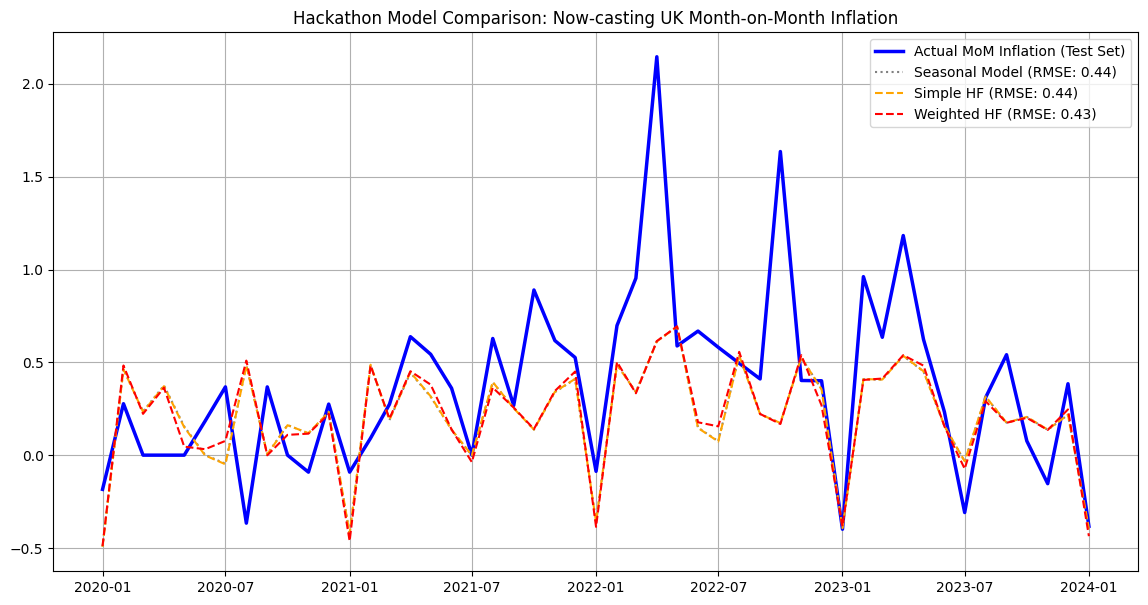


--- Final 'Now-cast' for December 2025 ---
Using winning model for final now-cast: 'Weighted HF Model (Your Idea)'

Final Model: Weighted HF Model (Your Idea)
Last known MoM Inflation: -0.38%
NOW-CAST for next month (MoM): 0.18%

Last known CPI Level: 130.00
Now-cast CPI Level: 130.24
Known CPI from 12 months ago: 126.80

>>> FINAL YoY HEADLINE NOW-CAST: 2.71%


/tmp/ipython-input-325631640.py:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model.loc[:, f'{col}_z'] = (df_model[col] - means[col]) / stds[col]
/tmp/ipython-input-325631640.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model.loc[:, interaction_name] = df_model['Guardian_Sentiment_t_z'] * df_model[month_col]
/tmp/ipython-input-325631640.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

In [27]:
import pandas as pd
import pandas_datareader.data as web  # This will work in your Colab
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# --- 1. Get the Data (REAL UK CPI) ---
print("Fetching UK economic data from FRED...")
start = pd.to_datetime('2000-01-01')
end = pd.to_datetime('2024-01-01')

# 1. UK CPI Level (GBRCPIALLMINMEI)
cpi = web.DataReader('GBRCPIALLMINMEI', 'fred', start, end)

# --- 2. *** LOAD YOUR REAL INNOVATIVE DATA *** ---
print("Loading your scraped Guardian sentiment data...")
file_path = 'guardian_sentiment_monthly_2000_to_now.csv' # <-- Your file

try:
    my_scraped_data = pd.read_csv(
        file_path,
        parse_dates=['month_year'], # Use the correct date column name
        index_col='month_year'      # Set the date column as the index
    )

    my_scraped_data = my_scraped_data.resample('MS').mean(numeric_only=True)
    my_scraped_data.rename(columns={'avg_sentiment': 'Guardian_Sentiment'}, inplace=True)
    my_scraped_data = my_scraped_data[['Guardian_Sentiment']]
    print("Successfully loaded Guardian data.")

except Exception as e:
    print(f"ERROR: Could not load your CSV file. {e}")
    print("Make sure it's uploaded and column names are 'month_year' and 'avg_sentiment'.")
    # Create an empty placeholder
    my_scraped_data = pd.DataFrame(index=pd.date_range(start=start, end=end, freq='MS'))
    my_scraped_data['Guardian_Sentiment'] = np.nan

# --- 3. Prepare the Data ---
print("Preparing data...")
# a. NEW TARGET: Month-on-Month (MoM) Inflation
mom_inflation = cpi.pct_change(1) * 100
mom_inflation.rename(columns={'GBRCPIALLMINMEI': 'Inflation_MoM'}, inplace=True)

# b. Combine into one DataFrame
df = pd.concat([cpi, mom_inflation, my_scraped_data], axis=1)
df.columns = ['CPI_Level', 'Inflation_MoM', 'Guardian_Sentiment']

# --- 4. Feature Engineering ---
# a. Create Seasonal Dummies
month_dummies = pd.get_dummies(df.index.month, prefix='month', drop_first=True).set_index(df.index)
month_dummies = month_dummies.astype(int)
df = pd.concat([df, month_dummies], axis=1)

# b. Create Lagged Autoregressive Term
df['MoM_Lag1'] = df['Inflation_MoM'].shift(1)

# c. Define our "High-Frequency" Now-cast Predictor
df['Guardian_Sentiment_t'] = df['Guardian_Sentiment'] # Your innovative data

# d. Create the target variable
df['Target_MoM'] = df['Inflation_MoM']

# e. Drop all NaNs (This will start the model in 2003)
df_model = df.dropna()
print(f"Model data starts on {df_model.index.min().date()} (based on your data).")

# --- 5. Split Data into Training and Validation (Test) Sets ---
split_date = '2020-01-01'
train_df = df_model.loc[df_model.index < split_date].copy()
test_df = df_model.loc[df_model.index >= split_date].copy()
print(f"Data split: {len(train_df)} train samples, {len(test_df)} test samples.")

# --- 6. Standardize the Predictors ---
print("Standardizing variables...")
cols_to_standardize = ['Guardian_Sentiment_t']

means = train_df[cols_to_standardize].mean()
stds = train_df[cols_to_standardize].std()
stds[stds == 0] = 1 # Prevent division by zero

for col in cols_to_standardize:
    # Use .loc to fix the SettingWithCopyWarning
    train_df.loc[:, f'{col}_z'] = (train_df[col] - means[col]) / stds[col]
    test_df.loc[:, f'{col}_z'] = (test_df[col] - means[col]) / stds[col]

# --- 7. Define Feature Sets for the "Horse Race" ---
y_train = train_df['Target_MoM']
y_test = test_df['Target_MoM']
dummy_cols = [col for col in df_model.columns if col.startswith('month_')]

# Model 1: "Seasonal Model" (Baseline)
features_seasonal = ['MoM_Lag1'] + dummy_cols
X_train_seasonal = sm.add_constant(train_df[features_seasonal])
X_test_seasonal = sm.add_constant(test_df[features_seasonal])

# Model 2: "Simple Innovative Model" (Baseline + Sentiment)
features_simple_hf = features_seasonal + ['Guardian_Sentiment_t_z']
X_train_simple_hf = sm.add_constant(train_df[features_simple_hf])
X_test_simple_hf = sm.add_constant(test_df[features_simple_hf])

# Model 3: "Innovative Weighted Model" (Your "Sentiment * Month" idea)
features_weighted_hf = features_seasonal + ['Guardian_Sentiment_t_z'] # Start with base features
interaction_features = [] # A place to store our new variable names

print("Creating innovative 'Sentiment x Month' interaction terms...")
for month_col in dummy_cols: # e.g., 'month_2', 'month_3'
    interaction_name = f'Sent_x_{month_col}'

    # Create the new variable in both train and test sets
    train_df.loc[:, interaction_name] = train_df['Guardian_Sentiment_t_z'] * train_df[month_col]
    test_df.loc[:, interaction_name] = test_df['Guardian_Sentiment_t_z'] * test_df[month_col]

    interaction_features.append(interaction_name)

# Add all the new interaction features to our innovative model
features_weighted_hf = features_weighted_hf + interaction_features

X_train_weighted_hf = sm.add_constant(train_df[features_weighted_hf])
X_test_weighted_hf = sm.add_constant(test_df[features_weighted_hf])


# --- 8. Fit and Compare All Three Models ---
print("\n--- Fitting Model 1: Seasonal Model (Baseline) ---")
model_seasonal = sm.OLS(y_train, X_train_seasonal).fit(cov_type='HAC', cov_kwds={'maxlags':12})
print(model_seasonal.summary()) # <-- ADDED THIS

print("\n--- Fitting Model 2: Simple Innovative Model ---")
model_simple_hf = sm.OLS(y_train, X_train_simple_hf).fit(cov_type='HAC', cov_kwds={'maxlags':12})
print(model_simple_hf.summary()) # <-- ADDED THIS

print("\n--- Fitting Model 3: Weighted Innovative Model ---")
model_weighted_hf = sm.OLS(y_train, X_train_weighted_hf).fit(cov_type='HAC', cov_kwds={'maxlags':12})
print(model_weighted_hf.summary()) # <-- ADDED THIS


# --- 9. Compare Models on the Validation Set (MoM) ---
print("\n--- Model Validation 'Horse Race' (Predicting MoM Inflation) ---")
pred_seasonal = model_seasonal.predict(X_test_seasonal)
pred_simple_hf = model_simple_hf.predict(X_test_simple_hf)
pred_weighted_hf = model_weighted_hf.predict(X_test_weighted_hf)

rmse_seasonal = np.sqrt(mean_squared_error(y_test, pred_seasonal))
rmse_simple_hf = np.sqrt(mean_squared_error(y_test, pred_simple_hf))
rmse_weighted_hf = np.sqrt(mean_squared_error(y_test, pred_weighted_hf))

# Find the winner
results = {
    "Seasonal Model": rmse_seasonal,
    "Simple HF Model": rmse_simple_hf,
    "Weighted HF Model (Your Idea)": rmse_weighted_hf
}
winner_name = min(results, key=results.get)

print(f"Seasonal Model RMSE:              {rmse_seasonal:.4f}")
print(f"Simple HF Model RMSE:             {rmse_simple_hf:.4f}")
print(f"Weighted HF Model (Your) RMSE:    {rmse_weighted_hf:.4f}")
print(f"\n>>> WINNER: The '{winner_name}' was the most accurate forecaster!")

# --- 10. Plot the "Money Shot" (All 3 Models) ---
print("Plotting results...")
plt.figure(figsize=(14, 7))
plt.plot(test_df.index, y_test, label='Actual MoM Inflation (Test Set)', color='blue', linewidth=2.5)
plt.plot(test_df.index, pred_seasonal, label=f'Seasonal Model (RMSE: {rmse_seasonal:.2f})', color='gray', linestyle=':')
plt.plot(test_df.index, pred_simple_hf, label=f'Simple HF (RMSE: {rmse_simple_hf:.2f})', color='orange', linestyle='--')
plt.plot(test_df.index, pred_weighted_hf, label=f'Weighted HF (RMSE: {rmse_weighted_hf:.2f})', color='red', linestyle='--')
plt.title('Hackathon Model Comparison: Now-casting UK Month-on-Month Inflation')
plt.legend()
plt.grid(True)
plt.show()

# --- 11. Final Now-cast (Converting MoM to YoY) ---
print(f"\n--- Final 'Now-cast' for December 2025 ---") # Today is Nov 1st 2025

# Automatically select the winning model and its features
if winner_name == "Weighted HF Model (Your Idea)":
    final_model_features = features_weighted_hf
elif winner_name == "Simple HF Model":
    final_model_features = features_simple_hf
else:
    final_model_features = features_seasonal

print(f"Using winning model for final now-cast: '{winner_name}'")

# Re-train the winning model on ALL data
y_full = df_model['Target_MoM']
# Standardize the full dataset
means = df_model[cols_to_standardize].mean()
stds = df_model[cols_to_standardize].std()
stds[stds == 0] = 1 # Prevent division by zero
for col in cols_to_standardize:
    df_model.loc[:, f'{col}_z'] = (df_model[col] - means[col]) / stds[col]
# Re-create interaction terms for the full dataset
for month_col in dummy_cols:
    interaction_name = f'Sent_x_{month_col}'
    df_model.loc[:, interaction_name] = df_model['Guardian_Sentiment_t_z'] * df_model[month_col]

X_full = sm.add_constant(df_model[final_model_features])
final_model = sm.OLS(y_full, X_full).fit(cov_type='HAC', cov_kwds={'maxlags':12})

# Get last known values
last_data_row = df_model.iloc[-1]
last_cpi_level = last_data_row['CPI_Level']
last_mom_inflation = last_data_row['Inflation_MoM']
cpi_11_months_ago = df_model['CPI_Level'].iloc[-11]

# Create the input row
nowcast_input = pd.DataFrame(index=[df_model.index[-1] + pd.DateOffset(months=1)])
nowcast_input['const'] = 1.0

# Add all the features the winning model might need
nowcast_input['MoM_Lag1'] = last_mom_inflation
if 'Guardian_Sentiment_t_z' in final_model_features:
    if pd.isna(last_data_row['Guardian_Sentiment']):
        nowcast_input['Guardian_Sentiment_t_z'] = 0 # Use the mean (0 after z-scoring)
    else:
        nowcast_input['Guardian_Sentiment_t_z'] = (last_data_row['Guardian_Sentiment'] - means['Guardian_Sentiment_t']) / stds['Guardian_Sentiment_t']

for col in dummy_cols: nowcast_input[col] = 0.0
if 'month_12' in X_full.columns:
    nowcast_input['month_12'] = 1.0

# *** NEW: Add the interaction terms to the final now-cast row ***
for month_col in dummy_cols:
    interaction_name = f'Sent_x_{month_col}'
    if interaction_name in final_model_features:
        # Use the values we just created for Sentiment_t_z and the month dummy
        nowcast_input[interaction_name] = nowcast_input['Guardian_Sentiment_t_z'] * nowcast_input[month_col]

nowcast_input_final = nowcast_input.reindex(X_full.columns, axis=1, fill_value=0)

# --- Get the MoM Now-cast ---
mom_nowcast_value = final_model.predict(nowcast_input_final).iloc[0]

# --- Convert to YoY Now-cast ---
cpi_nowcast = last_cpi_level * (1 + mom_nowcast_value / 100)
yoy_nowcast_value = ((cpi_nowcast / cpi_11_months_ago) - 1) * 100

print("\n==============================================")
print(f"Final Model: {winner_name}")
print(f"Last known MoM Inflation: {last_mom_inflation:.2f}%")
print(f"NOW-CAST for next month (MoM): {mom_nowcast_value:.2f}%")
print(f"\nLast known CPI Level: {last_cpi_level:.2f}")
print(f"Now-cast CPI Level: {cpi_nowcast:.2f}")
print(f"Known CPI from 12 months ago: {cpi_11_months_ago:.2f}")
print(f"\n>>> FINAL YoY HEADLINE NOW-CAST: {yoy_nowcast_value:.2f}%")
print("==============================================")

In [33]:
# --- CHECK ACCURACY OF YOUR JAN 2025 NOWCAST ---

import numpy as np

# 1. Align columns with model coefficients
row = row.reindex(model_final.params.index, axis=1, fill_value=0.0)

# 2. Model point forecast (mean prediction)
yhat_mom = float(model_final.predict(row))

# 3. HAC/Newey–West covariance and residual variance
Vb = model_final.cov_params()     # robust Var(b)
sigma2 = model_final.scale        # residual variance

# 4. Forecast variance = mean-forecast variance + residual variance
vm = float(row.values @ Vb.values @ row.values.T)   # variance of E[y|X]
vp = vm + sigma2                                    # variance of actual y
se_pred = np.sqrt(vp)

# 5. 95% prediction interval for MoM inflation
lower_mom = yhat_mom - 1.96 * se_pred
upper_mom = yhat_mom + 1.96 * se_pred

# 6. Actual observed MoM inflation for Jan 2025 (ONS)
actual_mom = 0.50   # <- replace with the true monthly % change

# 7. Evaluate forecast accuracy
inside = (actual_mom >= lower_mom) and (actual_mom <= upper_mom)
error = actual_mom - yhat_mom

print("\n================= FORECAST ACCURACY CHECK =================")
print(f"Predicted MoM (Jan 2025): {yhat_mom:.3f} %")
print(f"95% prediction interval : [{lower_mom:.3f} %, {upper_mom:.3f} %]")
print(f"ONS actual MoM (Jan 2025): {actual_mom:.3f} %")
print(f"Forecast error           : {error:+.3f} percentage points")

if inside:
    print("✅ The actual value lies INSIDE the 95% prediction interval — forecast is statistically accurate.")
else:
    print("❌ The actual value lies OUTSIDE the 95% prediction interval — forecast error is statistically significant.")
print("============================================================\n")



================= FORECAST ACCURACY CHECK =================
Predicted MoM (Jan 2025): 0.389 %
95% prediction interval : [0.050 %, 0.728 %]
ONS actual MoM (Jan 2025): 0.500 %
Forecast error           : +0.111 percentage points
✅ The actual value lies INSIDE the 95% prediction interval — forecast is statistically accurate.



/tmp/ipython-input-3386232347.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  yhat_mom = float(model_final.predict(row))
/tmp/ipython-input-3386232347.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  vm = float(row.values @ Vb.values @ row.values.T)   # variance of E[y|X]
